***Analysis of Cricket players***

Analysis of match performance of players data to identify areas of strength and weakness of players from Indian Premier League.

# **1.**  **Read the Data**

Import necessary libraries, making sure matplotlib plot figures inline and prepare the function to save the figures 

In [4]:
import math
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import glob
import time
import difflib
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas_profiling as pp

import matplotlib.pyplot as plt
#to display all rows columns 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
import matplotlib.pyplot as plt
%matplotlib notebook 
%matplotlib inline
import matplotlib.pyplot  as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [5]:
match = pd.read_csv('IPL_ball_by_ball_updated.csv')

In [6]:
match = match[match.innings <= 2]
match.reset_index(inplace = True, drop = True)

In [10]:
 player_profile = pd.read_excel('cricsheet_cricbuzz_mapping_updated.xlsx')

##**1.1**  **Player profile - preprocessing**

In the above data, the players can be segragated based on following parameters

1. Capped - Batters, Bowlers, Allrounders
2. Uncapped- batters, bowlers, Allrounders

The Uncapped players are playing the IPL for the first time, or relavant data isn't available with respect IPL tournment so we have ignored few new player's.


In [11]:
player_profile.tail()

cricsheet_name  cricbuzz_id     cricbuzz_name                  role           bat_style              bowl_style
604  A Dananjaya     8483.0       Akila Dananjaya    Bowler                Left Handed Bat     Right-arm offbreak   
605  A Choudhary     8190.0       Aniket Choudhary   Bowler                Right Handed Bat    Left-arm fast-medium 
606  A Chopra        257.0        Aakash Chopra      Batsman               Right Handed Bat    --                   
607  A Chandila      7905.0       Ajit Chandila      Bowling Allrounder    Right Handed Bat    Right-arm offbreak   
608  A Ashish Reddy  6301.0       Ashish Reddy       Bowling Allrounder    Right Handed Bat    Right-arm medium

In [12]:
# shortname for batting style
player_profile['batting_style'] = player_profile['bat_style']
player_profile['batting_style'] = player_profile['bat_style']

player_profile['batting_style'] = player_profile['batting_style'].replace(' Right Handed Bat ', 'RHB')
player_profile['batting_style'] = player_profile['batting_style'].replace(' Left Handed Bat ', 'LHB')

In [13]:
player_profile.bowl_style.unique()

array([' Left-arm fast-medium ', ' -- ', ' Left-arm orthodox ',
       ' Right-arm legbreak ', ' Right-arm medium ',
       ' Right-arm offbreak ', ' Left-arm medium ', ' Right-arm fast ',
       ' Right-arm fast-medium ', ' Left-arm chinaman ', nan,
       ' Left-arm fast ', ' --'], dtype=object)

In [14]:
player_profile['bowl_style'] = player_profile['bowl_style'].replace([' -- ', 'None'], 'Others')

In [15]:
def get_bowl_type(bowl_type_fullname):
  if bowl_type_fullname in [' Left-arm fast-medium ', ' Left-arm fast ', ' Left-arm medium ', ' Right-arm medium ', ' Right-arm fast-medium ', ' Right-arm fast ' ]:
    return 'Pace'
  elif bowl_type_fullname in [' Left-arm orthodox ', ' Left-arm chinaman ', ' Right-arm legbreak ',  ' Right-arm offbreak ']:
    return 'Spin'
  else:
    return None

In [16]:
player_profile['bowling_style'] = player_profile['bowl_style'].apply(lambda x: get_bowl_type(x))

In [17]:
player_profile.head(2)

cricsheet_name  cricbuzz_id    cricbuzz_name         role           bat_style              bowl_style batting_style bowling_style
0  Z Khan         71.0         Zaheer Khan       Bowler       Right Handed Bat    Left-arm fast-medium   RHB           Pace        
1  YV Takawale    1477.0       Yogesh Takawale  WK-Batsman    Right Handed Bat   Others                  RHB           None

In [18]:
match.head(1)

match_id  season  start_date                  venue  innings  ball                 batting_team           bowling_team     striker non_striker      bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty wicket_type player_dismissed  other_wicket_type  other_player_dismissed
0  335982    2008    18-04-2008  M Chinnaswamy Stadium  2        6.8   Royal Challengers Bangalore  Kolkata Knight Riders  MV Boucher  CL White    AB Agarkar  4             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN

In [19]:
bowler_player_profile = player_profile[['cricsheet_name', 'bowl_style', 'bowling_style']].rename(columns = {'cricsheet_name':'bowler'})
match = match.merge(bowler_player_profile, on = 'bowler', how = 'left')

In [20]:
batsman_player_profile = player_profile[['cricsheet_name', 'bat_style', 'batting_style']].rename(columns = {'cricsheet_name':'striker'})
match = match.merge(batsman_player_profile, on = 'striker', how = 'left')

In [21]:
match.tail(3)

match_id  season  start_date                             venue  innings  ball      batting_team      bowling_team       striker non_striker     bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty wicket_type player_dismissed  other_wicket_type  other_player_dismissed               bowl_style bowling_style           bat_style batting_style
225789  1312200   2022    29-05-2022  Narendra Modi Stadium, Ahmedabad  1        14.2  Rajasthan Royals  Gujarat Titans    R Ashwin      SO Hetmyer  HH Pandya  1             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB         
225790  1312200   2022    29-05-2022  Narendra Modi Stadium, Ahmedabad  1        12.2  Rajasthan Royals  Gujarat Titans    R Ashwin      SO Hetmyer  HH Pandya  0             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB         
225791  1312200   2022    29-05-2022  Narendra Modi Stadium, Ahmedabad  2        18.1  Gujarat Titans    Rajasthan Royals  Shubman Gill  DA Miller   OC McCoy   6             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                      NaN                      NaN            Right Handed Bat   RHB

#**2.** **Data Cleaning**
**Taking quick look of the Data Set**

In [22]:
match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225792 entries, 0 to 225791
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   match_id                225792 non-null  int64  
 1   season                  225792 non-null  int64  
 2   start_date              225792 non-null  object 
 3   venue                   225792 non-null  object 
 4   innings                 225792 non-null  int64  
 5   ball                    225792 non-null  float64
 6   batting_team            225792 non-null  object 
 7   bowling_team            225792 non-null  object 
 8   striker                 225792 non-null  object 
 9   non_striker             225792 non-null  object 
 10  bowler                  225792 non-null  object 
 11  runs_off_bat            225792 non-null  int64  
 12  extras                  225792 non-null  int64  
 13  wides                   7021 non-null    float64
 14  noballs             

In [23]:
match.head()

match_id  season  start_date                  venue  innings  ball                 batting_team           bowling_team     striker non_striker      bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty wicket_type player_dismissed  other_wicket_type  other_player_dismissed               bowl_style bowling_style           bat_style batting_style
0  335982    2008    18-04-2008  M Chinnaswamy Stadium  2        6.8   Royal Challengers Bangalore  Kolkata Knight Riders  MV Boucher  CL White    AB Agarkar  4             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB         
1  335982    2008    18-04-2008  M Chinnaswamy Stadium  2        2.7   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   AB Dinda    1             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB         
2  335982    2008    18-04-2008  M Chinnaswamy Stadium  2        3.1   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   I Sharma    2             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB         
3  335982    2008    18-04-2008  M Chinnaswamy Stadium  2        3.2   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   I Sharma    1             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB         
4  335982    2008    18-04-2008  M Chinnaswamy Stadium  2        3.3   Royal Challengers Bangalore  Kolkata Knight Riders  JH Kallis   W Jaffer    I Sharma    0             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB

##**2.1** **Checking for the Missing Values**

In [24]:
match.isnull().sum()


match_id                  0     
season                    0     
start_date                0     
venue                     0     
innings                   0     
ball                      0     
batting_team              0     
bowling_team              0     
striker                   0     
non_striker               0     
bowler                    0     
runs_off_bat              0     
extras                    0     
wides                     218771
noballs                   224878
byes                      225211
legbyes                   222269
penalty                   225790
wicket_type               214668
player_dismissed          214668
other_wicket_type         225792
other_player_dismissed    225792
bowl_style                10163 
bowling_style             14115 
bat_style                 3853  
batting_style             3853  
dtype: int64

In [25]:
{column: len(match[column].unique()) for column in match.columns}


{'match_id': 950,
 'season': 15,
 'start_date': 706,
 'venue': 49,
 'innings': 2,
 'ball': 180,
 'batting_team': 18,
 'bowling_team': 18,
 'striker': 605,
 'non_striker': 595,
 'bowler': 473,
 'runs_off_bat': 7,
 'extras': 7,
 'wides': 6,
 'noballs': 5,
 'byes': 5,
 'legbyes': 6,
 'penalty': 2,
 'wicket_type': 11,
 'player_dismissed': 574,
 'other_wicket_type': 1,
 'other_player_dismissed': 1,
 'bowl_style': 12,
 'bowling_style': 4,
 'bat_style': 4,
 'batting_style': 4}

In [26]:
match.groupby(['season']).size()

season
2008    13489
2009    13595
2010    14488
2011    17013
2012    17767
2013    18152
2014    14288
2015    13641
2016    14096
2017    13849
2018    14286
2019    14293
2020    14510
2021    14413
2022    17912
dtype: int64

###**2.2** **Checking for Duplicate Values and Remving the Duplicate values** 

In [27]:
player_profile.cricsheet_name.value_counts().head(20)

Z Khan            1
I Sharma          1
IR Jaggi          1
Iqbal Abdulla     1
Imran Tahir       1
IK Pathan         1
IC Porel          1
IC Pandey         1
I Udana           1
I Malhotra        1
M Manhas          1
HV Patel          1
HM Amla           1
HH Pandya         1
HH Gibbs          1
HF Gurney         1
Harpreet Singh    1
Harpreet Brar     1
IS Sodhi          1
Ishan Kishan      1
Name: cricsheet_name, dtype: int64

In [28]:
match.groupby(['venue']).size()

venue
Arun Jaitley Stadium                                    3344 
Arun Jaitley Stadium, Delhi                             988  
Barabati Stadium                                        1695 
Brabourne Stadium                                       2468 
Brabourne Stadium, Mumbai                               4057 
Buffalo Park                                            715  
De Beers Diamond Oval                                   726  
Dr DY Patil Sports Academy                              3993 
Dr DY Patil Sports Academy, Mumbai                      4905 
Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium     3037 
Dubai International Cricket Stadium                     11187
Eden Gardens                                            17988
Eden Gardens, Kolkata                                   508  
Feroz Shah Kotla                                        13950
Green Park                                              921  
Himachal Pradesh Cricket Association Stadium            2159 
Ho

In [29]:
match['venue']=match['venue'].str.replace('Arun Jaitley Stadium, Delhi','Arun Jaitley Stadium')
match['venue']=match['venue'].str.replace('Brabourne Stadium, Mumbai','Brabourne Stadium')
match['venue']=match['venue'].str.replace('Dr DY Patil Sports Academy, Mumbai','Dr DY Patil Sports Academy')
match['venue']=match['venue'].str.replace('Eden Gardens, Kolkata','Eden Gardens')
match['venue']=match['venue'].str.replace('M Chinnaswamy Stadium','M.Chinnaswamy Stadium')
match['venue']=match['venue'].str.replace('MA Chidambaram Stadium, Chepauk','MA Chidambaram Stadium')
match['venue']=match['venue'].str.replace('MA Chidambaram Stadium, Chepauk Chennai','MA Chidambaram Stadium')
match['venue']=match['venue'].str.replace('MA Chidambaram Stadium, Chennai','MA Chidambaram Stadium')
match['venue']=match['venue'].str.replace('Maharashtra Cricket Association Stadium, Pune','Maharashtra Cricket Association Stadium')
match['venue']=match['venue'].str.replace('Punjab Cricket Association IS Bindra Stadium, Mohali','Punjab Cricket Association IS Bindra Stadium')
match['venue']=match['venue'].str.replace('Punjab Cricket Association Stadium, Mohali','Punjab Cricket Association IS Bindra Stadium')
match['venue']=match['venue'].str.replace('Rajiv Gandhi International Stadium, Uppal','Rajiv Gandhi International Stadium')
match['venue']=match['venue'].str.replace('Wankhede Stadium, Mumbai','Wankhede Stadium')


In [30]:
match.groupby(['venue']).size()

venue
Arun Jaitley Stadium                                   4332 
Barabati Stadium                                       1695 
Brabourne Stadium                                      6525 
Buffalo Park                                           715  
De Beers Diamond Oval                                  726  
Dr DY Patil Sports Academy                             8898 
Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium    3037 
Dubai International Cricket Stadium                    11187
Eden Gardens                                           18496
Feroz Shah Kotla                                       13950
Green Park                                             921  
Himachal Pradesh Cricket Association Stadium           2159 
Holkar Cricket Stadium                                 1965 
JSCA International Stadium Complex                     1671 
Kingsmead                                              3643 
M.Chinnaswamy Stadium                                  18389
MA Chidambaram Sta

In [31]:
match.groupby(['batting_team']).size()

batting_team
Chennai Super Kings            25123
Deccan Chargers                9034 
Delhi Capitals                 7572 
Delhi Daredevils               18780
Gujarat Lions                  3558 
Gujarat Titans                 1971 
Kings XI Punjab                22622
Kochi Tuskers Kerala           1582 
Kolkata Knight Riders          26169
Lucknow Super Giants           1840 
Mumbai Indians                 27797
Pune Warriors                  5443 
Punjab Kings                   3388 
Rajasthan Royals               22763
Rising Pune Supergiant         1900 
Rising Pune Supergiants        1580 
Royal Challengers Bangalore    26494
Sunrisers Hyderabad            18176
dtype: int64

In [32]:
match['batting_team']=match['batting_team'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match['batting_team']=match['batting_team'].str.replace('Delhi Daredevils','Delhi Capitals')
match['batting_team']=match['batting_team'].str.replace('Gujarat Lions','Gujarat Titans')
match['batting_team']=match['batting_team'].str.replace('Kings XI Punjab','Punjab Kings')
match['batting_team']=match['batting_team'].str.replace('Pune Warriors','Rising Pune Supergiant')
match['batting_team']=match['batting_team'].str.replace('Rising Pune Supergiants','Rising Pune Supergiant')


In [33]:
match.groupby(['batting_team']).size()

batting_team
Chennai Super Kings            25123
Delhi Capitals                 26352
Gujarat Titans                 5529 
Kochi Tuskers Kerala           1582 
Kolkata Knight Riders          26169
Lucknow Super Giants           1840 
Mumbai Indians                 27797
Punjab Kings                   26010
Rajasthan Royals               22763
Rising Pune Supergiant         8923 
Royal Challengers Bangalore    26494
Sunrisers Hyderabad            27210
dtype: int64

In [34]:
match.groupby(['bowling_team']).size()

bowling_team
Chennai Super Kings            24847
Deccan Chargers                9039 
Delhi Capitals                 7715 
Delhi Daredevils               18718
Gujarat Lions                  3540 
Gujarat Titans                 1907 
Kings XI Punjab                22457
Kochi Tuskers Kerala           1614 
Kolkata Knight Riders          26336
Lucknow Super Giants           1843 
Mumbai Indians                 27826
Pune Warriors                  5457 
Punjab Kings                   3292 
Rajasthan Royals               22845
Rising Pune Supergiant         1928 
Rising Pune Supergiants        1615 
Royal Challengers Bangalore    26693
Sunrisers Hyderabad            18120
dtype: int64

In [35]:
match['bowling_team']=match['bowling_team'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match['bowling_team']=match['bowling_team'].str.replace('Delhi Daredevils','Delhi Capitals')
match['bowling_team']=match['bowling_team'].str.replace('Gujarat Lions','Gujarat Titans')
match['bowling_team']=match['bowling_team'].str.replace('Kings XI Punjab','Punjab Kings')
match['bowling_team']=match['bowling_team'].str.replace('Pune Warriors','Rising Pune Supergiant')
match['bowling_team']=match['bowling_team'].str.replace('Rising Pune Supergiants','Rising Pune Supergiant')

In [36]:
match.groupby(['bowling_team']).size()

bowling_team
Chennai Super Kings            24847
Delhi Capitals                 26433
Gujarat Titans                 5447 
Kochi Tuskers Kerala           1614 
Kolkata Knight Riders          26336
Lucknow Super Giants           1843 
Mumbai Indians                 27826
Punjab Kings                   25749
Rajasthan Royals               22845
Rising Pune Supergiant         9000 
Royal Challengers Bangalore    26693
Sunrisers Hyderabad            27159
dtype: int64

In [37]:
match.isnull().sum()

match_id                  0     
season                    0     
start_date                0     
venue                     0     
innings                   0     
ball                      0     
batting_team              0     
bowling_team              0     
striker                   0     
non_striker               0     
bowler                    0     
runs_off_bat              0     
extras                    0     
wides                     218771
noballs                   224878
byes                      225211
legbyes                   222269
penalty                   225790
wicket_type               214668
player_dismissed          214668
other_wicket_type         225792
other_player_dismissed    225792
bowl_style                10163 
bowling_style             14115 
bat_style                 3853  
batting_style             3853  
dtype: int64

# **3.**  **Data preprocessing**


**List of metrics to calculate for a batsman & Bowlers's : Based on which the performance evaluation takes place**

1. **Batsman's**- Innings Played, Runs scored, Balls faced, Dismissals, batting Strike rate, Batting Avg, Phase wise metrics, Boundary %, Dot ball%.

2. **Bowler's** - Innings Played, Runs conceded, Balls bowled, Dismissals,bowling Strike rate, bowling Avg, Economny, Phase wise metrics, Dot ball%.

**Note:**  Remove innings 3,4,5,6 - super overs, double super overs as those are not considered for the Statistic.

In [38]:
match = match[match.innings <= 2 ]

In [39]:
innings_played_match = match.groupby(['striker'])['match_id'].apply(lambda x: len(set(x))).reset_index().rename(columns = {'match_id':'innings_played'})

**Validating the Data by verifying with Cricbuzz live Data**

In [40]:
innings_played_match

striker  innings_played
0    A Ashish Reddy           23            
1    A Badoni                 11            
2    A Chandila               2             
3    A Chopra                 6             
4    A Choudhary              3             
5    A Dananjaya              1             
6    A Flintoff               3             
7    A Kumble                 15            
8    A Manohar                7             
9    A Mishra                 54            
10   A Mithun                 6             
11   A Mukund                 2             
12   A Nehra                  17            
13   A Nortje                 4             
14   A Singh                  5             
15   A Symonds                36            
16   A Tomar                  1             
17   A Uniyal                 2             
18   A Zampa                  2             
19   AA Bilakhia              7             
20   AA Chavan                3             
21   AA Jhunjhunwala          15            
22   AA Noffke                1             
23   AB Agarkar               18            
24   AB Barath                3             
25   AB Dinda                 16            
26   AB McDonald              9             
27   AB de Villiers           170           
28   AC Blizzard              7             
29   AC Gilchrist             80            
30   AC Thomas                4             
31   AC Voges                 7             
32   AD Hales                 6             
33   AD Mascarenhas           11            
34   AD Mathews               41            
35   AD Nath                  10            
36   AD Russell               81            
37   AF Milne                 6             
38   AG Murtaza               3             
39   AG Paunikar              5             
40   AJ Finch                 90            
41   AJ Turner                4             
42   AJ Tye                   13            
43   AK Markram               18            
44   AL Menaria               23            
45   AM Nayar                 50            
46   AM Rahane                148           
47   AN Ahmed                 6             
48   AN Ghosh                 2             
49   AP Dole                  2             
50   AP Majumdar              4             
51   AP Tare                  27            
52   AR Bawne                 1             
53   AR Patel                 87            
54   AS Joseph                4             
55   AS Rajpoot               7             
56   AS Raut                  16            
57   AS Roy                   1             
58   AS Yadav                 6             
59   AT Carey                 3             
60   AT Rayudu                173           
61   AUK Pathan               7             
62   Abdul Samad              19            
63   Abdur Razzak             1             
64   Abhishek Sharma          34            
65   Akash Deep               1             
66   Aman Hakim Khan          1             
67   Anirudh Singh            4             
68   Ankit Sharma             10            
69   Ankit Soni               3             
70   Anmolpreet Singh         3             
71   Anuj Rawat               9             
72   Anureet Singh            8             
73   Arshdeep Singh           9             
74   Avesh Khan               6             
75   Azhar Mahmood            21            
76   B Akhil                  11            
77   B Chipli                 21            
78   B Indrajith              3             
79   B Kumar                  55            
80   B Laughlin               4             
81   B Lee                    19            
82   B Sai Sudharsan          5             
83   B Stanlake               1             
84   B Sumanth                4             
85   BA Bhatt                 2             
86   BA Stokes                41            
87   BAW Mendis               3             
88   BB McCullum

In [41]:
runs_scored_match = match.groupby(['striker'])['runs_off_bat'].sum().reset_index().rename(columns = {'runs_off_bat':'runs_scored'})
runs_scored_match

striker  runs_scored
0    A Ashish Reddy           280        
1    A Badoni                 161        
2    A Chandila               4          
3    A Chopra                 53         
4    A Choudhary              25         
5    A Dananjaya              4          
6    A Flintoff               62         
7    A Kumble                 35         
8    A Manohar                108        
9    A Mishra                 362        
10   A Mithun                 34         
11   A Mukund                 19         
12   A Nehra                  41         
13   A Nortje                 8          
14   A Singh                  2          
15   A Symonds                974        
16   A Tomar                  4          
17   A Uniyal                 4          
18   A Zampa                  5          
19   AA Bilakhia              69         
20   AA Chavan                12         
21   AA Jhunjhunwala          217        
22   AA Noffke                9          
23   AB Agarkar               179        
24   AB Barath                42         
25   AB Dinda                 26         
26   AB McDonald              123        
27   AB de Villiers           5162       
28   AC Blizzard              120        
29   AC Gilchrist             2069       
30   AC Thomas                20         
31   AC Voges                 181        
32   AD Hales                 148        
33   AD Mascarenhas           79         
34   AD Mathews               724        
35   AD Nath                  90         
36   AD Russell               2035       
37   AF Milne                 23         
38   AG Murtaza               10         
39   AG Paunikar              49         
40   AJ Finch                 2091       
41   AJ Turner                3          
42   AJ Tye                   91         
43   AK Markram               527        
44   AL Menaria               401        
45   AM Nayar                 672        
46   AM Rahane                4074       
47   AN Ahmed                 36         
48   AN Ghosh                 7          
49   AP Dole                  34         
50   AP Majumdar              87         
51   AP Tare                  339        
52   AR Bawne                 12         
53   AR Patel                 1135       
54   AS Joseph                20         
55   AS Rajpoot               26         
56   AS Raut                  194        
57   AS Roy                   0          
58   AS Yadav                 49         
59   AT Carey                 32         
60   AT Rayudu                4190       
61   AUK Pathan               39         
62   Abdul Samad              226        
63   Abdur Razzak             0          
64   Abhishek Sharma          667        
65   Akash Deep               0          
66   Aman Hakim Khan          5          
67   Anirudh Singh            63         
68   Ankit Sharma             87         
69   Ankit Soni               7          
70   Anmolpreet Singh         29         
71   Anuj Rawat               129        
72   Anureet Singh            36         
73   Arshdeep Singh           23         
74   Avesh Khan               31         
75   Azhar Mahmood            388        
76   B Akhil                  76         
77   B Chipli                 280        
78   B Indrajith              21         
79   B Kumar                  241        
80   B Laughlin               5          
81   B Lee                    124        
82   B Sai Sudharsan          145        
83   B Stanlake               5          
84   B Sumanth                35         
85   BA Bhatt                 6          
86   BA Stokes                920        
87   BAW Mendis               3          
88   BB McCullum              2880       
89   BB Samantray             125        
90   BB Sran                  10         
91   BCJ Cutting              238        
92   BE Hendricks             1          
93   BJ Haddin                18         
94   BJ Hodge                 1

**Balls faced** : legal balls, extras (wide, noball, byes, leg byes) all these while calculating the balls faced by batsman. 
- wides
- noballs
- byes
- leg byes
 
 Need to flag the legal ball as - **balls_faced** for Bastman   
   **Balls faced** = not extras + no_balls (with runs scored) + byes + legbyes.

In [42]:
def wides_calc(wides):
  # check if its a nan
  if wides != wides:
    return 1
  else:
    return 0


def noballs_calc(noballs, runs_off_bat):
  # check if its a nan
  if noballs != noballs:
    return 1
  elif runs_off_bat >= 0:
    return 1
  else:
    return 0

def noballs_calc_bowler(noballs):
  # check if its a nan
  if noballs != noballs:
    return 1
  else:
    return 0

def byes_calc(byes):
  # check for nan
    if byes != byes:
      return 1
    elif byes >= 1:
      return 1
    else:
      return 0

def legbyes_calc(leg_byes):
    if leg_byes != leg_byes:
      return 1
    elif leg_byes >= 1:
      return 1
    else:
      return 0

# balls_faced = not extras + no_balls (with runs scored) + byes + legbyes

In [43]:

# Balls_faced
match['wides_cnt_balls'] = match['wides'].apply(lambda x: wides_calc(x))
match['noballs_cnt_balls'] = match.apply(lambda x: noballs_calc(x['noballs'], x['runs_off_bat']), axis = 1 )
match['noballs_cnt_balls_bowler'] = match.apply(lambda x: noballs_calc_bowler(x['noballs']), axis = 1 )
match['byes_cnt_balls'] = match['byes'].apply(lambda x: byes_calc(x))
match['legbyes_cnt_balls'] = match['legbyes'].apply(lambda x: legbyes_calc(x))
# assign legal_ball flag
match['legal_ball'] = match.apply(lambda x: 0 if min(x['wides_cnt_balls'], x['noballs_cnt_balls'], x['byes_cnt_balls'], x['legbyes_cnt_balls']) == 0 else 1, axis = 1)
match['legal_ball_bowler'] = match.apply(lambda x: 0 if min(x['wides_cnt_balls'], x['noballs_cnt_balls_bowler'], x['byes_cnt_balls'], x['legbyes_cnt_balls']) == 0 else 1, axis = 1)

In [44]:
match.head(10)

match_id  season  start_date                  venue  innings  ball                 batting_team           bowling_team     striker non_striker      bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty wicket_type player_dismissed  other_wicket_type  other_player_dismissed               bowl_style bowling_style           bat_style batting_style  wides_cnt_balls  noballs_cnt_balls  noballs_cnt_balls_bowler  byes_cnt_balls  legbyes_cnt_balls  legal_ball  legal_ball_bowler
0  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        6.8   Royal Challengers Bangalore  Kolkata Knight Riders  MV Boucher  CL White    AB Agarkar  4             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                
1  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        2.7   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   AB Dinda    1             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                
2  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        3.1   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   I Sharma    2             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                
3  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        3.2   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   I Sharma    1             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                
4  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        3.3   Royal Challengers Bangalore  Kolkata Knight Riders  JH Kallis   W Jaffer    I Sharma    0             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                
5  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        3.4   Royal Challengers Bangalore  Kolkata Knight Riders  JH Kallis   W Jaffer    I Sharma    0             1      NaN    NaN      NaN    1.0     NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                
6  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        3.5   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   I Sharma    0             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                
7  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2  

**Additional columns are added to compute Overs and balls in order to identify the Power play overs, middle overs and Death Overs.**

In [48]:
match['over_no'] = match['ball'].apply(lambda x: int(str(x).split('.')[0]))
match['ball_no'] = match['ball'].apply(lambda x: int(str(x).split('.')[1]))
#how this base works

**Idenitifying and Classifying different Phases of Match - PP(Power Play), MO (Middle Over), DO(Death Over)**

In [49]:
def phase(over_no):
  if over_no < 6:
    return "PP"
  elif over_no < 16:
    return "MO"
  else:
    return "DO"

In [50]:
match['phase'] = match['over_no'].apply(lambda x: phase(x))

In [51]:
match.head()

match_id  season  start_date                  venue  innings  ball                 batting_team           bowling_team     striker non_striker      bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty wicket_type player_dismissed  other_wicket_type  other_player_dismissed               bowl_style bowling_style           bat_style batting_style  wides_cnt_balls  noballs_cnt_balls  noballs_cnt_balls_bowler  byes_cnt_balls  legbyes_cnt_balls  legal_ball  legal_ball_bowler  over_no  ball_no phase
0  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        6.8   Royal Challengers Bangalore  Kolkata Knight Riders  MV Boucher  CL White    AB Agarkar  4             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  6        8        MO  
1  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        2.7   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   AB Dinda    1             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  2        7        PP  
2  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        3.1   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   I Sharma    2             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  3        1        PP  
3  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        3.2   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   I Sharma    1             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  3        2        PP  
4  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        3.3   Royal Challengers Bangalore  Kolkata Knight Riders  JH Kallis   W Jaffer    I Sharma    0             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  3        3        PP

#**4.** ***Batting Statistics***

In [52]:
def balls_per_dismissal(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1 
    
def balls_per_boundary(balls, boundaries):
    if boundaries > 0:
        return balls/boundaries
    else:
        return balls/1 

def playerStatistics(Bat_stat):
    
    Bat_stat['isDot'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 0 else 0)
    Bat_stat['isOne'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 1 else 0)
    Bat_stat['isTwo'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 2 else 0)
    Bat_stat['isThree'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 3 else 0)
    Bat_stat['isFour'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 4 else 0)
    Bat_stat['isSix'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 6 else 0)

    # consider all extras 
    Bat_stat['wides_cnt_balls'] = Bat_stat['wides'].apply(lambda x: wides_calc(x))
    Bat_stat['noballs_cnt_balls'] = Bat_stat.apply(lambda x: noballs_calc(x['noballs'], x['runs_off_bat']), axis = 1 )
    Bat_stat['byes_cnt_balls'] = Bat_stat['byes'].apply(lambda x: byes_calc(x))
    Bat_stat['legbyes_cnt_balls'] = Bat_stat['legbyes'].apply(lambda x: legbyes_calc(x))
    # assign legal_ball flag
    Bat_stat['legal_ball'] = Bat_stat.apply(lambda x: 0 if min(x['wides_cnt_balls'], x['noballs_cnt_balls'], x['byes_cnt_balls'], x['legbyes_cnt_balls']) == 0 else 1, axis = 1)

    balls = Bat_stat.groupby(['striker'])['legal_ball'].sum().reset_index().rename(columns = {'legal_ball':'balls'})
    
    runs = pd.DataFrame(Bat_stat.groupby(['striker'])['runs_off_bat'].sum().reset_index()).groupby(['striker'])['runs_off_bat'].sum().reset_index().rename(columns={'runs_off_bat':'runs'})
    innings = pd.DataFrame(Bat_stat.groupby(['striker'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    #balls = pd.DataFrame(Bat_stat.groupby(['striker'])['legal_ball'].count()).reset_index().rename(columns = {'legal_ball':'balls'})
    #dismissals = pd.DataFrame(Bat_stat.groupby(['striker'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    dismissals = Bat_stat['player_dismissed'].value_counts().reset_index().rename(columns = {'player_dismissed':'dismissals', 'index' : 'striker'})


    dots = pd.DataFrame(Bat_stat.groupby(['striker'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(Bat_stat.groupby(['striker'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(Bat_stat.groupby(['striker'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(Bat_stat.groupby(['striker'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(Bat_stat.groupby(['striker'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(Bat_stat.groupby(['striker'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    Bat_stat = pd.merge(innings, runs, on = 'striker').merge(balls, on = 'striker').merge(dismissals, on = 'striker').merge(dots, on = 'striker').merge(ones, on = 'striker').merge(twos, on = 'striker').merge(threes, on = 'striker').merge(fours, on = 'striker').merge(sixes, on = 'striker')
    
    #StrikeRate
    Bat_stat['SR'] = Bat_stat.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)
    
    #Batting Average
    Bat_stat['AVG'] = Bat_stat.apply(lambda x: x['runs'] if x['dismissals'] == 0 else x['runs']/x['dismissals'], axis = 1)

    #balls per dismissals
    Bat_stat['BPD'] = Bat_stat.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    Bat_stat['BPB'] = Bat_stat.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return Bat_stat

In [53]:
Bat_stat = playerStatistics(match)

In [54]:
Bat_stat

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD        BPB
0    A Ashish Reddy           23       280   193    15          61    83    20    1       16     15     145.077720  18.666667  12.866667  6.225806 
1    A Badoni                 11       161   130    8           57    53    11    0       11     7      123.846154  20.125000  16.250000  7.222222 
2    A Chopra                 6        53    71     6           45    21    2     0       7      0      74.647887   8.833333   11.833333  10.142857
3    A Choudhary              3        25    20     1           4     13    1     0       1      1      125.000000  25.000000  20.000000  10.000000
4    A Flintoff               3        62    53     2           24    23    2     1       5      2      116.981132  31.000000  26.500000  7.571429 
5    A Kumble                 15       35    47     3           24    21    1     0       3      0      74.468085   11.666667  15.666667  15.666667
6    A Manohar                7        108   75     6           30    30    2     0       14     3      144.000000  18.000000  12.500000  4.411765 
7    A Mishra                 54       362   389    31          182   172   22    0       29     5      93.059126   11.677419  12.548387  11.441176
8    A Mithun                 6        34    26     5           11    8     2     0       4      1      130.769231  6.800000   5.200000   5.200000 
9    A Mukund                 2        19    22     2           9     11    2     0       1      0      86.363636   9.500000   11.000000  22.000000
10   A Nehra                  17       41    62     7           37    21    1     0       3      1      66.129032   5.857143   8.857143   15.500000
11   A Nortje                 4        8     12     1           9     2     0     2       0      0      66.666667   8.000000   12.000000  12.000000
12   A Singh                  5        2     10     4           8     2     0     0       0      0      20.000000   0.500000   2.500000   10.000000
13   A Symonds                36       974   750    27          308   288   66    4       74     41     129.866667  36.074074  27.777778  6.521739 
14   A Tomar                  1        4     8      1           7     0     0     0       1      0      50.000000   4.000000   8.000000   8.000000 
15   A Uniyal                 2        4     7      1           3     4     0     0       0      0      57.142857   4.000000   7.000000   7.000000 
16   A Zampa                  2        5     8      2           6     1     0     0       1      0      62.500000   2.500000   4.000000   8.000000 
17   AA Bilakhia              7        69    85     5           43    31    9     0       5      0      81.176471   13.800000  17.000000  17.000000
18   AA Chavan                3        12    11     2           5     4     0     0       2      0      109.090909  6.000000   5.500000   5.500000 
19   AA Jhunjhunwala          15       217   210    13          98    82    13    1       19     5      103.333333  16.692308  16.153846  8.750000 
20   AA Noffke                1        9     10     1           6     5     0     0       1      0      90.000000   9.000000   10.000000  10.000000
21   AB Agarkar               18       179   154    10          60    67    15    0       13     5      116.233766  17.900000  15.400000  8.555556 
22   AB Barath                3        42    42     2           22    14    1     0       5      1      100.000000  21.000000  21.000000  7.000000 
23   AB Dinda                 16       26    48     10          31    16    1     0       2      0      54.166667   2.600000   4.800000   24.000000
24   AB McDonald              9        123   100    5           38    42    9     1       9      4      123.000000  24.600000  20.000000  7.692308 
25   AB de Villiers           170      5162  3403   130         1113  1417  268   17      413    251    151.689686  39.707692  26.176923  5.125000 
26   AC Blizzard         

In [55]:
Bat_stat.head(2)

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
0  A Ashish Reddy  23       280   193    15          61    83    20    1       16     15     145.077720  18.666667  12.866667  6.225806
1  A Badoni        11       161   130    8           57    53    11    0       11     7      123.846154  20.125000  16.250000  7.222222

**Highest Runs in  IPL from (2008-2022)**

In [56]:
# top 10 highest run Scores.
Top_Runs_scorer = Bat_stat.sort_values("runs", ascending = False)
Top_Runs_scorer.head(10)

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
538  V Kohli         215      6624  5129   183         1886  2181  378   19      579    219    129.147982  36.196721  28.027322  6.427318
435  S Dhawan        205      6244  4942   179         1958  1981  279   23      701    137    126.345609  34.882682  27.608939  5.897375
124  DA Warner       162      5881  4180   140         1633  1513  345   23      577    216    140.693780  42.007143  29.857143  5.271122
405  RG Sharma       221      5879  4526   194         1778  1835  248   7       519    241    129.893946  30.304124  23.329897  5.955263
466  SK Raina        200      5528  4043   170         1475  1708  270   11      506    203    136.730151  32.517647  23.782353  5.702398
25   AB de Villiers  170      5162  3403   130         1113  1417  268   17      413    251    151.689686  39.707692  26.176923  5.125000
321  MS Dhoni        205      4978  3682   127         1370  1509  333   15      346    229    135.198262  39.196850  28.992126  6.403478
103  CH Gayle        141      4965  3333   125         1634  1012  91    3       405    357    148.964896  39.720000  26.664000  4.374016
425  RV Uthappa      197      4952  3799   180         1598  1416  230   15      481    182    130.350092  27.511111  21.105556  5.730015
241  KD Karthik      207      4376  3299   163         1219  1355  240   6       426    134    132.646256  26.846626  20.239264  5.891071

In [57]:
fig = px.bar(Top_Runs_scorer.head(10), x="striker", y="runs",
                hover_data=['striker'],color='striker', text_auto='runs',labels={
                     "striker": "Batsman",
                     "runs": "Runs" },  title ="Top 10 Most run scorer in the IPL history (2008-2022)")
fig.show()

**Highest Strike Rate  in  IPL from (2008-2022)**

In [58]:
# top 10 highest SR
Top_strikerate = Bat_stat[Bat_stat.innings >= 20].sort_values("SR", ascending = False)
Top_strikerate.head(10)

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
34   AD Russell      81       2035  1144   67          507   343   47    0       137    175    177.884615  30.373134  17.074627  3.666667
232  K Gowtham       20       186   111    14          44    32    12    2       13     12     167.567568  13.285714  7.928571   4.440000
274  LS Livingstone  23       549   329    20          133   127   12    2       38     40     166.869301  27.450000  16.450000  4.217949
480  SP Narine       82       1025  630    69          321   141   25    1       112    63     162.698413  14.855072  9.130435   3.600000
206  JC Archer       21       195   124    13          46    47    10    0       11     14     157.258065  15.000000  9.538462   4.960000
540  V Sehwag        104      2728  1755   99          737   558   96    2       334    106    155.441595  27.555556  17.727273  3.988636
104  CH Morris       49       618   398    28          134   163   39    1       41     35     155.276382  22.071429  14.214286  5.236842
173  GJ Maxwell      105      2319  1507   91          601   527   113   4       198    127    153.881885  25.483516  16.560440  4.636923
367  PJ Cummins      29       379   249    20          110   73    27    0       24     26     152.208835  18.950000  12.450000  4.980000
476  SO Hetmyer      43       831   546    27          216   210   43    1       55     52     152.197802  30.777778  20.222222  5.102804

In [59]:
fig = px.bar(Top_strikerate.head(10), x="striker", y="SR",
                hover_data=['striker'],color='striker',text_auto='SR',labels={
                     "striker": "Batsman",
                     "SR": "Strike Rate" },  title = "Highest Strike Rate in  IPL history (2008-2022)")
fig.show()

**Highest Batting Average  in  IPL from (2008-2022)**

In [60]:
Top_Avg = Bat_stat[Bat_stat.innings >= 20].sort_values("AVG", ascending = False)
Top_Avg.head(5)

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
248  KL Rahul     99       3889  2855   81          1040  1200  191   5       327    164    136.217163  48.012346  35.246914  5.814664
124  DA Warner    162      5881  4180   140         1633  1513  345   23      577    216    140.693780  42.007143  29.857143  5.271122
270  LMP Simmons  29       1079  852    27          402   269   52    2       109    44     126.643192  39.962963  31.555556  5.568627
463  SE Marsh     69       2477  1866   62          734   724   99    6       266    78     132.743837  39.951613  30.096774  5.424419
207  JC Buttler   81       2831  1891   71          775   628   132   4       278    135    149.709149  39.873239  26.633803  4.578692

In [61]:
fig = px.bar(Top_Avg.head(10), x="striker", y="AVG",
                hover_data=['striker'],color='striker',text_auto='AVG',labels={
                     "striker": "Batsman",
                       "AVG": "Batting Average" },  title = "Highest Batting Average in IPL history (2008-2022)")
fig.show()

**Season-wise Top Run Scorer (Orange Cap)**

In [62]:
top_scorers={}
for i in list(match.season.unique()): 
    df=match[match.season==i] 
    ts=df.groupby(['striker'], as_index=False)['runs_off_bat'].sum().sort_values('runs_off_bat', ascending=False).head(1)
    #finding the top scorer each season and adding the to the dictionary created before
    top_scorers[(ts['striker'].iloc[0]+str(' ')+str(i))]=ts['runs_off_bat'].iloc[0]
    top_scorers
    

In [63]:
top_scorers


{'SE Marsh 2008': 616,
 'ML Hayden 2009': 572,
 'SR Tendulkar 2010': 617,
 'CH Gayle 2011': 608,
 'CH Gayle 2012': 733,
 'MEK Hussey 2013': 733,
 'RV Uthappa 2014': 660,
 'DA Warner 2015': 562,
 'V Kohli 2016': 973,
 'DA Warner 2017': 641,
 'KS Williamson 2018': 735,
 'DA Warner 2019': 692,
 'KL Rahul 2020': 670,
 'RD Gaikwad 2021': 635,
 'JC Buttler 2022': 863}

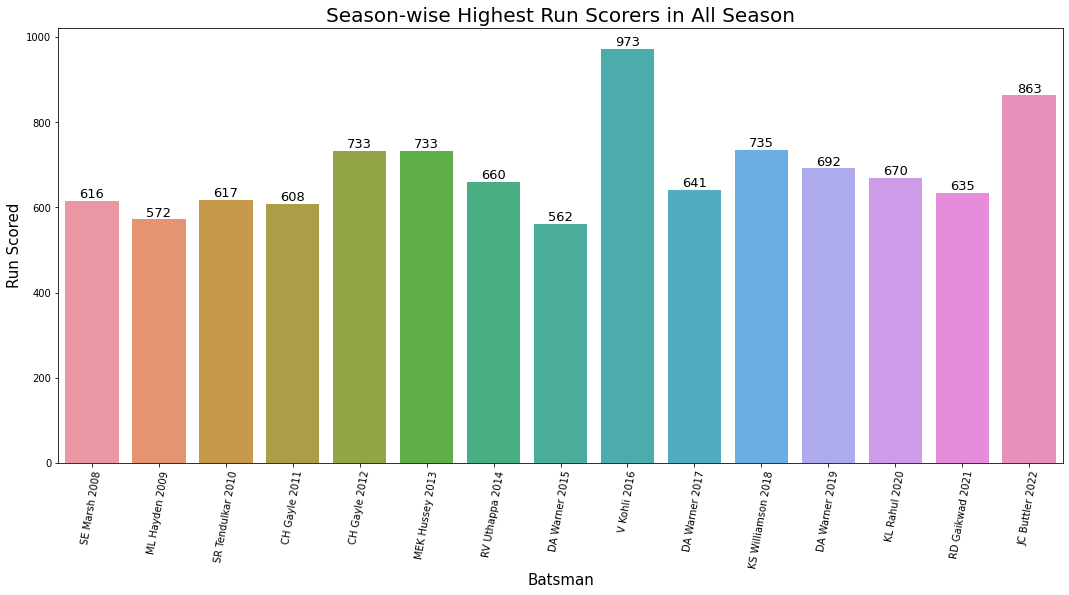

In [64]:
plt.figure(figsize=(18,8))
x=list(top_scorers.keys())
y=list(top_scorers.values())

graph = sns.barplot(x=x, y=y )
plt.xticks(rotation=90)
plt.title('Season-wise Highest Run Scorers in All Season', fontsize=20)
plt.ylabel('Run Scored', fontsize=15 )
plt.xlabel('Batsman', fontsize=15);
plt.xticks(rotation=80);
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', fontsize=13)

##**4.1** **Batting Performance**

In [65]:
fig = px.box(Bat_stat, x="SR")
fig.show()

**Min-Max Scalar**

 **Calculating Min Max Values**

In [66]:
def minmax(col):
  max_v = max(col)
  min_v = min(col)

  print("min max", min_v, max_v)

  minmax_values = []

  for i in col:
    minmax_values.append((i - min_v) / (max_v - min_v))

  return minmax_values

def minmax_reverse(col):
  max_v = max(col)
  min_v = min(col)

  minmax_values = []

  for i in col:
    minmax_values.append(1- (i - min_v) / (max_v - min_v))

  return minmax_values

def bowlers_minmax(col):

  # check for NaNs in the col
  col = [i if i == i else 100 for i in col]
  col = [100 if i == np.inf else i for i in col]

  max_v = max(col)
  min_v = min(col)

  minmax_values = []

  for i in col:
    minmax_values.append((i - min_v) / (max_v - min_v))

  return minmax_values

def bowlers_minmax_reverse(col):

  # check for NaNs in the col
  col = [i if i == i else 100 for i in col]
  col = [100 if i == np.inf else i for i in col]
  
  max_v = max(col)
  min_v = min(col)

  minmax_values = []

  for i in col:
    minmax_values.append(1- (i - min_v) / (max_v - min_v))

  return minmax_values

### **4.2** **Batting Performance in different phases of play**

In [67]:
def phasesOfplay(Bat_stat, current_phase):
    
    Bat_stat = Bat_stat[Bat_stat.phase == current_phase]
    Bat_stat.reset_index(inplace = True, drop = True)
    
    Bat_stat['isDot'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 0 else 0)
    Bat_stat['isOne'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 1 else 0)
    Bat_stat['isTwo'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 2 else 0)
    Bat_stat['isThree'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 3 else 0)
    Bat_stat['isFour'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 4 else 0)
    Bat_stat['isSix'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 6 else 0)

    # consider all extras 
    Bat_stat['wides_cnt_balls'] = Bat_stat['wides'].apply(lambda x: wides_calc(x))
    Bat_stat['noballs_cnt_balls'] = Bat_stat.apply(lambda x: noballs_calc(x['noballs'], x['runs_off_bat']), axis = 1 )
    Bat_stat['byes_cnt_balls'] = Bat_stat['byes'].apply(lambda x: byes_calc(x))
    Bat_stat['legbyes_cnt_balls'] = Bat_stat['legbyes'].apply(lambda x: legbyes_calc(x))
    # assign legal_ball flag
    Bat_stat['legal_ball'] = Bat_stat.apply(lambda x: 0 if min(x['wides_cnt_balls'], x['noballs_cnt_balls'], x['byes_cnt_balls'], x['legbyes_cnt_balls']) == 0 else 1, axis = 1)

    balls = Bat_stat.groupby(['striker'])['legal_ball'].sum().reset_index().rename(columns = {'legal_ball':'balls'})
    
    runs = pd.DataFrame(Bat_stat.groupby(['striker', 'match_id'])['runs_off_bat'].sum().reset_index()).groupby(['striker'])['runs_off_bat'].sum().reset_index().rename(columns={'runs_off_bat':'runs'})
    innings = pd.DataFrame(Bat_stat.groupby(['striker'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    # balls = pd.DataFrame(Bat_stat.groupby(['striker'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    #dismissals = pd.DataFrame(Bat_stat.groupby(['striker'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    dismissals = Bat_stat['player_dismissed'].value_counts().reset_index().rename(columns = {'player_dismissed':'dismissals', 'index' : 'striker'})

    dots = pd.DataFrame(Bat_stat.groupby(['striker'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(Bat_stat.groupby(['striker'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(Bat_stat.groupby(['striker'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(Bat_stat.groupby(['striker'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(Bat_stat.groupby(['striker'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(Bat_stat.groupby(['striker'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    Bat_stat = pd.merge(innings, runs, on = 'striker').merge(balls, on = 'striker').merge(dismissals, on = 'striker').merge(dots, on = 'striker').merge(ones, on = 'striker').merge(twos, on = 'striker').merge(threes, on = 'striker').merge(fours, on = 'striker').merge(sixes, on = 'striker')
    
    #StrikeRate
    Bat_stat['SR'] = Bat_stat.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    Bat_stat['AVG'] = Bat_stat.apply(lambda x: x['runs'] if x['dismissals'] == 0 else x['runs']/x['dismissals'], axis = 1)

    #balls per dismissals
    Bat_stat['BPD'] = Bat_stat.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    Bat_stat['BPB'] = Bat_stat.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return Bat_stat

In [68]:
Bat_stat['sr_mnmx'] = minmax(Bat_stat.SR)
Bat_stat['AVG_mnmx'] = minmax(Bat_stat.AVG)
Bat_stat['bpd_mnmx'] = minmax(Bat_stat.BPD)
Bat_stat['bpb_mnmx'] = minmax_reverse(Bat_stat.BPB)

min max 0.0 210.1123595505618
min max 0.0 55.666666666666664
min max 1.0 44.0


In [69]:
PP_match = phasesOfplay(match,'PP')
MO_match = phasesOfplay(match,'MO')
DO_match = phasesOfplay(match,'DO')

In [70]:
PP_match.head()

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR   AVG   BPD       BPB
0  A Ashish Reddy  1        5     6      1           5     1     0     0       1      0      83.333333   5.0   6.0   6.000000
1  A Badoni        2        1     6      1           6     1     0     0       0      0      16.666667   1.0   6.0   6.000000
2  A Chopra        5        27    39     3           26    11    0     0       4      0      69.230769   9.0   13.0  9.750000
3  A Manohar       1        12    12     1           6     4     0     0       2      0      100.000000  12.0  12.0  6.000000
4  A Symonds       15       72    82     1           55    15    3     1       12     0      87.804878   72.0  82.0  6.833333

In [71]:
MO_match.head()

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD        BPB
0  A Ashish Reddy  8        83    60     3           21    23    7     0       4      5      138.333333  27.666667  20.000000  6.666667 
1  A Badoni        8        76    74     3           32    30    5     0       6      2      102.702703  25.333333  24.666667  9.250000 
2  A Chopra        3        26    32     3           19    10    2     0       3      0      81.250000   8.666667   10.666667  10.666667
3  A Flintoff      2        26    27     2           10    14    2     0       2      0      96.296296   13.000000  13.500000  13.500000
4  A Manohar       3        59    40     2           16    17    1     0       7      2      147.500000  29.500000  20.000000  4.444444

In [72]:
DO_match.head()

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD        BPB
0  A Ashish Reddy  19       192   127    11          35    59    13    1       11     10     151.181102  17.454545  11.545455  6.047619 
1  A Badoni        7        84    50     4           19    22    6     0       5      5      168.000000  21.000000  12.500000  5.000000 
2  A Choudhary     3        24    19     1           4     12    1     0       1      1      126.315789  24.000000  19.000000  9.500000 
3  A Kumble        14       29    39     3           19    19    1     0       2      0      74.358974   9.666667   13.000000  19.500000
4  A Manohar       4        37    23     3           8     9     1     0       5      1      160.869565  12.333333  7.666667   3.833333

### **4.3** **Batting Performance by opposition**

In [73]:
def ByOpposition(Bat_stat, current_opposition):
    
    Bat_stat= Bat_stat[Bat_stat.bowling_team == current_opposition]
    Bat_stat.reset_index(inplace = True, drop = True)
    
    Bat_stat['isDot'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 0 else 0)
    Bat_stat['isOne'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 1 else 0)
    Bat_stat['isTwo'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 2 else 0)
    Bat_stat['isThree'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 3 else 0)
    Bat_stat['isFour'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 4 else 0)
    Bat_stat['isSix'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 6 else 0)

    # consider all extras 
    Bat_stat['wides_cnt_balls'] = Bat_stat['wides'].apply(lambda x: wides_calc(x))
    Bat_stat['noballs_cnt_balls'] = Bat_stat.apply(lambda x: noballs_calc(x['noballs'], x['runs_off_bat']), axis = 1 )
    Bat_stat['byes_cnt_balls'] = Bat_stat['byes'].apply(lambda x: byes_calc(x))
    Bat_stat['legbyes_cnt_balls'] = Bat_stat['legbyes'].apply(lambda x: legbyes_calc(x))
    # assign legal_ball flag
    Bat_stat['legal_ball'] = Bat_stat.apply(lambda x: 0 if min(x['wides_cnt_balls'], x['noballs_cnt_balls'], x['byes_cnt_balls'], x['legbyes_cnt_balls']) == 0 else 1, axis = 1)

    balls = Bat_stat.groupby(['striker'])['legal_ball'].sum().reset_index().rename(columns = {'legal_ball':'balls'})
    
    runs = pd.DataFrame(Bat_stat.groupby(['striker', 'match_id'])['runs_off_bat'].sum().reset_index()).groupby(['striker'])['runs_off_bat'].sum().reset_index().rename(columns={'runs_off_bat':'runs'})
    innings = pd.DataFrame(Bat_stat.groupby(['striker'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    # balls = pd.DataFrame(Bat_stat.groupby(['striker'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    #dismissals = pd.DataFrame(Bat_stat.groupby(['striker'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    dismissals = Bat_stat['player_dismissed'].value_counts().reset_index().rename(columns = {'player_dismissed':'dismissals', 'index' : 'striker'})

    dots = pd.DataFrame(Bat_stat.groupby(['striker'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(Bat_stat.groupby(['striker'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(Bat_stat.groupby(['striker'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(Bat_stat.groupby(['striker'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(Bat_stat.groupby(['striker'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(Bat_stat.groupby(['striker'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    Bat_stat = pd.merge(innings, runs, on = 'striker').merge(balls, on = 'striker').merge(dismissals, on = 'striker').merge(dots, on = 'striker').merge(ones, on = 'striker').merge(twos, on = 'striker').merge(threes, on = 'striker').merge(fours, on = 'striker').merge(sixes, on = 'striker')
    
    # StrikeRate
    Bat_stat['SR'] = Bat_stat.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    # runs per innings
    Bat_stat['AVG'] = Bat_stat.apply(lambda x: x['runs'] if x['dismissals'] == 0 else x['runs']/x['dismissals'], axis = 1)

    # balls per dismissals
    Bat_stat['BPD'] = Bat_stat.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    # balls per boundary
    Bat_stat['BPB'] = Bat_stat.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return Bat_stat

In [74]:
 Against_CSK = ByOpposition(match,'Chennai Super Kings').sort_values("runs", ascending = False)
Against_CSK.head()

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
253  S Dhawan    28       1029  787    23          296   340   49    3       114    21     130.749682  44.739130  34.217391  5.829630
306  V Kohli     29       979   781    25          301   328   63    5       72     37     125.352113  39.160000  31.240000  7.165138
235  RG Sharma   31       770   614    28          236   261   37    1       69     26     125.407166  27.500000  21.928571  6.463158
131  KD Karthik  28       647   479    23          191   173   38    2       71     18     135.073069  28.130435  20.826087  5.382022
129  KA Pollard  23       583   339    16          135   118   15    1       42     44     171.976401  36.437500  21.187500  3.941860

In [75]:
fig = px.bar(Against_CSK.head(10), x="striker", y="runs",
                hover_data=['striker'],color='striker',text_auto= 'runs',labels={
                     "striker": "Batsman",
                     "runs": "Runs" },  title ="Top 10 Higest Run scorer Against Chennai Super Kings (2008-2022)")
fig.show()

In [76]:
Against_MI = ByOpposition(match,'Mumbai Indians').sort_values("runs", ascending = False)
Against_MI.head()

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
265  S Dhawan        27       871   682    22          273   258   46    3       95     22     127.712610  39.590909  31.000000  5.829060
147  KL Rahul        16       867   638    10          224   279   53    2       68     34     135.893417  86.700000  63.800000  6.254902
280  SK Raina        34       824   591    28          223   247   40    5       68     35     139.424704  29.428571  21.107143  5.737864
14   AB de Villiers  24       785   530    18          182   221   29    2       71     36     148.113208  43.611111  29.444444  4.953271
319  V Kohli         29       769   612    26          235   263   38    4       64     27     125.653595  29.576923  23.538462  6.725275

In [77]:
fig = px.bar(Against_MI.head(10), x="striker", y="runs",
                hover_data=['striker'],color='striker',text_auto= 'runs',labels={
                     "striker": "Batsman",
                     "runs": "Runs" },  title ="Top 10 Higest Run scorer Against Mumbai Indians(2008-2022)")
fig.show()

In [78]:
Against_kkr = ByOpposition(match,'Kolkata Knight Riders').sort_values("runs", ascending = False)
Against_kkr.head()

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
223  RG Sharma  30       1020  786    24          314   313   41    1       100    37     129.770992  42.500000  32.750000  5.737226
62   DA Warner  26       1018  699    23          265   254   56    4       100    40     145.636624  44.260870  30.391304  4.992857
253  SK Raina   23       829   607    19          216   254   40    1       81     28     136.573311  43.631579  31.947368  5.568807
237  S Dhawan   29       810   691    28          290   280   30    2       86     20     117.221418  28.928571  24.678571  6.518868
292  V Kohli    27       786   607    22          206   259   53    3       70     22     129.489292  35.727273  27.590909  6.597826

In [79]:
fig = px.bar(Against_kkr.head(10), x="striker", y="runs",
                hover_data=['striker'],color='striker',text_auto= 'runs',labels={
                     "striker": "Batsman",
                     "runs": "Runs" },  title ="Top 10 Higest Run scorer Against Kolkata Knight Rider(2008-2022)")
fig.show()

In [80]:
Against_rcb = ByOpposition(match,'Royal Challengers Bangalore').sort_values("runs", ascending = False)
Against_rcb.head()

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
188  MS Dhoni   30       838   595    21          217   248   52    2       51     46     140.840336  39.904762  28.333333  6.134021
65   DA Warner  20       820   508    18          189   175   44    1       74     43     161.417323  45.555556  28.222222  4.341880
235  RG Sharma  29       785   568    27          226   220   34    0       72     34     138.204225  29.074074  21.037037  5.358491
33   AT Rayudu  23       714   583    22          225   258   31    0       55     29     122.469983  32.454545  26.500000  6.940476
264  SK Raina   29       702   547    23          229   218   23    0       63     31     128.336380  30.521739  23.782609  5.819149

In [81]:
fig = px.bar(Against_rcb.head(10), x="striker", y="runs",
                hover_data=['striker'],color='striker',text_auto= 'runs',labels={
                     "striker": "Batsman",
                     "runs": "Runs" },  title ="Top 10 Higest Run scorer Against Royal Challengers Bangalore(2008-2022)")
fig.show()

In [82]:
Against_Pbk = ByOpposition(match,'Punjab Kings').sort_values("runs", ascending = False)
Against_Pbk.head()

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
66   DA Warner  23       1005  707    20          289   248   51    3       106    37     142.149929  50.250000  35.350000  4.944056
241  S Dhawan   26       894   645    23          221   273   48    2       103    17     138.604651  38.869565  28.043478  5.375000
256  SK Raina   24       822   546    20          188   235   35    1       76     35     150.549451  41.100000  27.300000  4.918919
296  V Kohli    29       802   627    26          254   246   39    0       85     23     127.910686  30.846154  24.115385  5.805556
50   CH Gayle   16       797   456    15          205   130   23    1       63     61     174.780702  53.133333  30.400000  3.677419

In [83]:
fig = px.bar(Against_Pbk.head(10), x="striker", y="runs",
                hover_data=['striker'],color='striker',text_auto= 'runs',labels={
                     "striker": "Batsman",
                     "runs": "Runs" },  title ="Top 10 Higest Run scorer Against Punjab Kings(2008-2022)")
fig.show()

In [84]:
Against_Dc = ByOpposition(match,'Delhi Capitals').sort_values("runs", ascending = False)
Against_Dc.head()

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
313  V Kohli     25       925   690    18          208   342   41    1       84     27     134.057971  51.388889  38.333333  6.216216
234  RG Sharma   32       912   700    29          268   294   34    2       73     42     130.285714  31.448276  24.137931  6.086957
30   AM Rahane   19       792   602    13          202   276   43    2       82     16     131.561462  60.923077  46.307692  6.142857
246  RV Uthappa  27       740   593    25          239   236   31    2       76     22     124.789207  29.600000  23.720000  6.051020
266  SK Raina    26       661   491    23          183   195   41    2       57     25     134.623218  28.739130  21.347826  5.987805

In [85]:
fig = px.bar(Against_Dc.head(10), x="striker", y="runs",
                hover_data=['striker'],color='striker',text_auto= 'runs',labels={
                     "striker": "Batsman",
                     "runs": "Runs" },  title ="Top 10 Higest Run scorer Against Delhi Capitals(2008-2022)")
fig.show()

In [86]:
Against_RR = ByOpposition(match,'Rajasthan Royals').sort_values("runs", ascending = False)
Against_RR.head()

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
10   AB de Villiers  20       652   443    14          144   180   45    6       55     24     147.178330  46.571429  31.642857  5.607595
229  SK Raina        23       630   468    23          177   192   37    1       65     16     134.615385  27.391304  20.347826  5.777778
115  KD Karthik      26       614   454    19          172   177   36    1       56     23     135.242291  32.315789  23.894737  5.746835
264  V Kohli         26       600   520    22          210   212   39    2       49     18     115.384615  27.272727  23.636364  7.761194
216  S Dhawan        22       576   455    20          200   166   16    1       76     11     126.593407  28.800000  22.750000  5.229885

In [87]:
fig = px.bar(Against_RR.head(10), x="striker", y="runs",
                hover_data=['striker'],color='striker',text_auto= 'runs',labels={
                     "striker": "Batsman",
                     "runs": "Runs" },  title ="Top 10 Higest Run scorer Against Rajasthan Royals(2008-2022)")
fig.show()

In [88]:
Against_SRH = ByOpposition(match,'Sunrisers Hyderabad').sort_values("runs", ascending = False)
Against_SRH.head()

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
311  V Kohli         30       875   638    27          252   238   58    1       77     35     137.147335  32.407407  23.629630  5.696429
181  MS Dhoni        28       769   584    19          221   237   53    2       60     30     131.678082  40.473684  30.736842  6.488889
268  SK Raina        29       763   548    25          183   248   30    1       74     26     139.233577  30.520000  21.920000  5.480000
12   AB de Villiers  24       693   475    21          157   208   32    1       58     31     145.894737  33.000000  22.619048  5.337079
289  SV Samson       19       670   502    15          186   197   57    1       50     26     133.466135  44.666667  33.466667  6.605263

In [89]:
fig = px.bar(Against_SRH.head(10), x="striker", y="runs",
                hover_data=['striker'],color='striker',text_auto= 'runs',labels={
                     "striker": "Batsman",
                     "runs": "Runs" },  title ="Top 10 Higest Run scorer Against Sunrisers Hyderabad(2008-2022)")
fig.show()

### **4.4** **Batting Performance in 1st/2nd**


In [90]:
def ByInning(Bat_stat, current_inning):
    
    Bat_stat = Bat_stat[Bat_stat.innings == current_inning]
    Bat_stat.reset_index(inplace = True, drop = True)
    
    Bat_stat['isDot'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 0 else 0)
    Bat_stat['isOne'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 1 else 0)
    Bat_stat['isTwo'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 2 else 0)
    Bat_stat['isThree'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 3 else 0)
    Bat_stat['isFour'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 4 else 0)
    Bat_stat['isSix'] = Bat_stat['runs_off_bat'].apply(lambda x: 1 if x == 6 else 0)

    # consider all extras 
    Bat_stat['wides_cnt_balls'] = Bat_stat['wides'].apply(lambda x: wides_calc(x))
    Bat_stat['noballs_cnt_balls'] = Bat_stat.apply(lambda x: noballs_calc(x['noballs'], x['runs_off_bat']), axis = 1 )
    Bat_stat['byes_cnt_balls'] = Bat_stat['byes'].apply(lambda x: byes_calc(x))
    Bat_stat['legbyes_cnt_balls'] = Bat_stat['legbyes'].apply(lambda x: legbyes_calc(x))
    # assign legal_ball flag
    Bat_stat['legal_ball'] = Bat_stat.apply(lambda x: 0 if min(x['wides_cnt_balls'], x['noballs_cnt_balls'], x['byes_cnt_balls'], x['legbyes_cnt_balls']) == 0 else 1, axis = 1)

    balls = Bat_stat.groupby(['striker'])['legal_ball'].sum().reset_index().rename(columns = {'legal_ball':'balls'})
    
    runs = pd.DataFrame(Bat_stat.groupby(['striker', 'match_id'])['runs_off_bat'].sum().reset_index()).groupby(['striker'])['runs_off_bat'].sum().reset_index().rename(columns={'runs_off_bat':'runs'})
    innings = pd.DataFrame(Bat_stat.groupby(['striker'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    # balls = pd.DataFrame(Bat_stat.groupby(['striker'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    #dismissals = pd.DataFrame(Bat_stat.groupby(['striker'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    dismissals = Bat_stat['player_dismissed'].value_counts().reset_index().rename(columns = {'player_dismissed':'dismissals', 'index' : 'striker'})

    dots = pd.DataFrame(match.groupby(['striker'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(match.groupby(['striker'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(match.groupby(['striker'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(match.groupby(['striker'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(match.groupby(['striker'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(match.groupby(['striker'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    Bat_stat = pd.merge(innings, runs, on = 'striker').merge(balls, on = 'striker').merge(dismissals, on = 'striker').merge(dots, on = 'striker').merge(ones, on = 'striker').merge(twos, on = 'striker').merge(threes, on = 'striker').merge(fours, on = 'striker').merge(sixes, on = 'striker')
    
    #StrikeRate
    Bat_stat['SR'] = Bat_stat.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    Bat_stat['AVG'] = Bat_stat.apply(lambda x: x['runs'] if x['dismissals'] == 0 else x['runs']/x['dismissals'], axis = 1)

    #balls per dismissals
    Bat_stat['BPD'] = Bat_stat.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    Bat_stat['BPB'] = Bat_stat.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return Bat_stat

In [91]:
ing1_match = ByInning(match, 1)
ing2_match = ByInning(match, 2)

In [92]:
ing1_match.head()

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
0  A Ashish Reddy  13       166   113    7           61    83    20    1       16     15     146.902655  23.714286  16.142857  3.645161
1  A Badoni        5        106   86     4           57    53    11    0       11     7      123.255814  26.500000  21.500000  4.777778
2  A Chopra        5        51    68     5           45    21    2     0       7      0      75.000000   10.200000  13.600000  9.714286
3  A Kumble        5        11    15     2           24    21    1     0       3      0      73.333333   5.500000   7.500000   5.000000
4  A Manohar       4        81    55     4           30    30    2     0       14     3      147.272727  20.250000  13.750000  3.235294

In [93]:
ing2_match.head()

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR    AVG   BPD       BPB
0  A Ashish Reddy  10       114   80     8           61    83    20    1       16     15     142.500000  14.25  10.0  2.580645
1  A Badoni        6        55    44     4           57    53    11    0       11     7      125.000000  13.75  11.0  2.444444
2  A Chopra        1        2     3      1           45    21    2     0       7      0      66.666667   2.00   3.0   0.428571
3  A Choudhary     2        10    8      1           4     13    1     0       1      1      125.000000  10.00  8.0   4.000000
4  A Flintoff      2        40    40     2           24    23    2     1       5      2      100.000000  20.00  20.0  5.714286

In [94]:
comp = ing1_match[['striker', 'AVG']].merge(ing2_match[['striker', 'AVG']], on = 'striker', how = 'inner').rename(columns = {'AVG_x':'1st_AVG', 'AVG_y':'2nd_AVG' })

In [95]:
comp

striker    1st_AVG    2nd_AVG
0    A Ashish Reddy     23.714286  14.250000
1    A Badoni           26.500000  13.750000
2    A Chopra           10.200000  2.000000 
3    A Kumble           5.500000   24.000000
4    A Manohar          20.250000  13.500000
5    A Mishra           8.529412   15.500000
6    A Mithun           8.000000   6.500000 
7    A Mukund           19.000000  0.000000 
8    A Nehra            2.000000   8.750000 
9    A Singh            1.000000   0.333333 
10   A Symonds          47.846154  25.142857
11   AA Bilakhia        9.666667   20.000000
12   AA Chavan          8.000000   4.000000 
13   AA Jhunjhunwala    23.666667  10.714286
14   AB Agarkar         19.500000  15.500000
15   AB Dinda           1.400000   3.800000 
16   AB McDonald        24.666667  24.500000
17   AB de Villiers     45.840580  32.770492
18   AC Blizzard        21.500000  15.400000
19   AC Gilchrist       23.575000  31.277778
20   AC Voges           69.000000  21.500000
21   AD Hales           17.333333  32.000000
22   AD Mascarenhas     11.000000  7.000000 
23   AD Mathews         24.117647  22.428571
24   AD Nath            11.000000  6.000000 
25   AD Russell         34.966667  26.648649
26   AG Paunikar        8.000000   12.500000
27   AJ Finch           24.533333  25.307692
28   AJ Turner          0.000000   1.500000 
29   AJ Tye             7.600000   13.250000
30   AK Markram         29.600000  47.375000
31   AL Menaria         17.857143  21.571429
32   AM Nayar           21.000000  15.000000
33   AM Rahane          30.376812  31.396825
34   AN Ghosh           7.000000   0.000000 
35   AP Dole            4.000000   30.000000
36   AP Majumdar        30.000000  19.000000
37   AP Tare            13.133333  15.777778
38   AR Patel           19.962963  18.625000
39   AS Rajpoot         2.333333   9.500000 
40   AS Raut            19.750000  23.000000
41   AT Carey           28.000000  4.000000 
42   AT Rayudu          27.702703  30.140845
43   AUK Pathan         1.000000   12.333333
44   Abdul Samad        20.000000  11.454545
45   Abhishek Sharma    29.777778  21.000000
46   Anirudh Singh      20.000000  11.500000
47   Ankit Sharma       14.500000  9.666667 
48   Anmolpreet Singh   8.000000   10.500000
49   Anuj Rawat         6.250000   20.800000
50   Arshdeep Singh     7.000000   2.000000 
51   Avesh Khan         7.000000   24.000000
52   Azhar Mahmood      21.454545  19.000000
53   B Akhil            10.333333  15.000000
54   B Chipli           17.555556  20.333333
55   B Indrajith        6.000000   7.500000 
56   B Kumar            7.000000   9.375000 
57   B Lee              12.800000  12.000000
58   B Sai Sudharsan    76.000000  23.000000
59   BA Stokes          21.000000  29.200000
60   BB McCullum        30.017857  24.979167
61   BB Samantray       27.500000  15.000000
62   BCJ Cutting        20.714286  23.250000
63   BJ Hodge           31.142857  35.523810
64   BJ Rohrer          45.500000  25.500000
65   BMAJ Mendis        11.000000  6.000000 
66   BR Dunk            15.000000  12.500000
67   Bipul Sharma       17.000000  29.750000
68   C Munro            16.857143  11.800000
69   C Sakariya         3.750000   1.000000 
70   C de Grandhomme    16.625000  21.250000
71   CA Ingram          19.500000  15.875000
72   CA Lynn            34.388889  33.809524
73   CA Pujara          17.333333  26.000000
74   CH Gayle           40.464789  38.740741
75   CH Morris          17.687500  27.916667
76   CJ Anderson        25.583333  23.100000
77   CJ Ferguson        10.500000  28.000000
78   CJ Jordan          12.250000  6.500000 
79   CK Kapugedera      4.000000   8.000000 
80   CL White           35.052632  16.941176
81   CM Gautam          15.600000  18.200000
82   CR Brathwaite      16.333333  8.500000 
83   CR Woakes          12.250000  14.500000
84   CV Varun           6.500000   11.000000
85   D Brevis           13.666667  30.000000
86   D Padikkal         28.516129  26.857143
87   D Pretorius        0.000000   14.666667
88   D Wie

In [96]:
fig = px.scatter(comp, x="1st_AVG", y="2nd_AVG",
                hover_data=['striker'],color='striker',labels={
                     "1st_AVG": "Fisrt Innings Average",
                     "2st_AVG": "Second Innings Average" },  title ="Comparision of Avg Runs - 1st Ing vs 2nd Ing")
fig.show()

In [97]:
fig = px.scatter(Bat_stat, x="AVG", y="SR",
                hover_data=['striker'],color='striker',labels={
                     "AVG": "Batting Average",
                     "SR": "Batsman Strike Rate" },  title ="Comparision of Average VS Strike Rate")
fig.show()

#**5.** **Best Batting Options**

In [98]:
def best_batting_options(match, min_balls = 100, min_innings = 1, bowling_style = None,  season = None, bowling_team = None, venue = None, innings = None, phase = None, bowlers = None, worst = None, sorter = None ):
  
  # season
  if season != None:
    match = match[match.season == season]

  # innings
  if innings != None:
    match = match[match.innings == innings]
  
  # phase
  if phase != None:
    match = match[match.phase == phase]

  # bowl type
  if bowling_style != None:
    match = match[match.bowling_style == bowling_style]

  # bowling team
  if bowling_team != None:
    match = match[match.bowling_team == bowling_team]

  # venue
  if venue != None:
    match = match[match.venue == venue]

  # bowlers - list
  if bowlers != None:
    match = match[match.bowler.isin(bowlers)]
  
  # calculation
  match = playerStatistics(match)
  match = match[match.balls >= min_balls]
  match = match[match.innings >= min_innings]

  # count of rows
  print("no of rows after all filters:", len(match))
  if len(match) == 0:
    print("No players found with these filters")
    return None
  elif len(match) == 1:
    print("only one player found with these filters")
    # preview df
    print(match.head())
    return None

  match['AVG_mnmx'] = minmax(match.AVG)
  match['sr_mnmx'] = minmax(match.SR)
  match['bpd_mnmx'] = minmax(match.BPD)
  match['bpb_mnmx'] = minmax_reverse(match.BPB)

  match['total_score'] = match['AVG_mnmx'] + match['sr_mnmx'] + match['bpd_mnmx']

  if sorter != None:
    match.sort_values(sorter, ascending = False, inplace = True)
    return match

  if worst != None:
    match.sort_values('total_score', ascending = True, inplace = True)
  else:
    match.sort_values('total_score', ascending = False, inplace = True)

  return match



In [99]:
Bat_stat.head(1)

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes         SR        AVG        BPD       BPB   sr_mnmx  AVG_mnmx  bpd_mnmx  bpb_mnmx
0  A Ashish Reddy  23       280   193    15          61    83    20    1       16     15     145.07772  18.666667  12.866667  6.225806  0.690477  0.335329  0.275969  0.93852

**Best Batting Options Against Mumbai Indians based on Batting Average**

In [100]:
Best_MI = best_batting_options(match, min_balls = 150, min_innings = 20, bowling_team ='Mumbai Indians', sorter = 'AVG')
Best_MI.head(10)

no of rows after all filters: 16
min max 18.235294117647058 43.611111111111114
min max 115.30864197530863 148.11320754716982
min max 15.352941176470589 31.41176470588235


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
14   AB de Villiers  24       785   530    18          182   221   29    2       71     36     148.113208  43.611111  29.444444  4.953271  1.000000  1.000000  0.877493  1.000000  2.877493   
60   CH Gayle        20       708   534    17          281   167   13    1       62     44     132.584270  41.647059  31.411765  5.037736  0.922601  0.526623  1.000000  0.971424  2.449224   
71   DA Warner       20       666   482    16          194   179   39    1       64     25     138.174274  41.625000  30.125000  5.415730  0.921732  0.697026  0.919872  0.843543  2.538630   
265  S Dhawan        27       871   682    22          273   258   46    3       95     22     127.712610  39.590909  31.000000  5.829060  0.841573  0.378117  0.974359  0.703707  2.194050   
186  MK Pandey       22       709   548    19          192   244   42    1       57     25     129.379562  37.315789  28.842105  6.682927  0.751916  0.428932  0.839985  0.414830  2.020833   
196  MS Dhoni        34       746   576    21          242   230   42    0       57     34     129.513889  35.523810  27.428571  6.329670  0.681299  0.433027  0.751962  0.534343  1.866288   
336  YK Pathan       22       472   332    15          120   148   12    0       45     20     142.168675  31.466667  22.133333  5.107692  0.521417  0.818789  0.422222  0.947757  1.762428   
26   AM Rahane       22       625   516    20          214   201   30    4       70     12     121.124031  31.250000  25.800000  6.292683  0.512878  0.177274  0.650549  0.546856  1.340702   
319  V Kohli         29       769   612    26          235   263   38    4       64     27     125.653595  29.576923  23.538462  6.725275  0.446946  0.315351  0.509721  0.400503  1.272018   
280  SK Raina        34       824   591    28          223   247   40    5       68     35     139.424704  29.428571  21.107143  5.737864  0.441100  0.735143  0.358320  0.734560  1.534564

In [101]:
fig = px.bar(Best_MI.head(10), x="striker", y="AVG",
                hover_data=['striker'],color='striker',text_auto= 'AVG',labels={
                     "striker": "Batsman",
                     "AVG": "Batting Average" },  title ="Best Batting average  Against Mumbai Indians(2008-2022)")
fig.show()

**Best Batting Options Against Chennai Super Kings based on Batting Average**

In [102]:
Best_CSK = best_batting_options(match, min_balls = 150, min_innings = 20, bowling_team ='Chennai Super Kings', sorter = 'AVG')
Best_CSK.head(10)

no of rows after all filters: 7
min max 23.130434782608695 44.73913043478261
min max 125.35211267605635 171.976401179941
min max 15.391304347826088 34.21739130434783


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
253  S Dhawan        28       1029  787    23          296   340   49    3       114    21     130.749682  44.739130  34.217391  5.829630  1.000000  0.115767  1.000000  0.414332  2.115767   
306  V Kohli         29       979   781    25          301   328   63    5       72     37     125.352113  39.160000  31.240000  7.165138  0.741811  0.000000  0.841848  0.000000  1.583658   
129  KA Pollard      23       583   339    16          135   118   15    1       42     44     171.976401  36.437500  21.187500  3.941860  0.615820  1.000000  0.307881  1.000000  1.923701   
251  RV Uthappa      22       547   415    19          176   147   29    2       54     20     131.807229  28.789474  21.842105  5.608108  0.261887  0.138450  0.342652  0.483058  0.742989   
131  KD Karthik      28       647   479    23          191   173   38    2       71     18     135.073069  28.130435  20.826087  5.382022  0.231388  0.208496  0.288684  0.553199  0.728567   
235  RG Sharma       31       770   614    28          236   261   37    1       69     26     125.407166  27.500000  21.928571  6.463158  0.202213  0.001181  0.347245  0.217784  0.550639   
10   AB de Villiers  25       532   354    23          126   125   40    3       42     25     150.282486  23.130435  15.391304  5.283582  0.000000  0.534708  0.000000  0.583740  0.534708

In [103]:
fig = px.bar(Best_CSK.head(10), x="striker", y="AVG",
                hover_data=['striker'],color='striker',text_auto= 'AVG',labels={
                     "striker": "Batsman",
                     "AVG": "Batting Average" },  title ="Best Batting average  Against Chennai Super kings(2008-2022)")
fig.show()

In [104]:
best_batting_options(match, min_balls = 150, min_innings = 50, phase = 'PP', sorter = 'BPB').head(10)

no of rows after all filters: 41
min max 19.65625 56.92857142857143
min max 98.50746268656717 147.38903394255877
min max 17.0625 48.94117647058823


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
103  KD Karthik  61       396   402    11          228   109   10    2       55     6      98.507463   36.000000  36.545455  6.590164  0.438496  0.000000  0.611159  0.000000  1.049655   
132  MEK Hussey  55       828   767    19          409   218   35    8       105    16     107.953064  43.578947  40.368421  6.338843  0.641835  0.193234  0.731082  0.097165  1.566152   
23   AT Rayudu   82       777   732    23          395   215   23    0       93     24     106.147541  33.782609  31.826087  6.256410  0.379004  0.156298  0.463118  0.129035  0.998420   
125  M Vijay     102      1574  1375   50          717   375   87    15      176    46     114.472727  31.480000  27.500000  6.193694  0.317226  0.326611  0.327413  0.153282  0.971250   
222  SS Iyer     79       858   773    24          411   233   30    4       107    20     110.996119  35.750000  32.208333  6.086614  0.431788  0.255488  0.475109  0.194681  1.162385   
90   JH Kallis   82       1036  982    34          559   259   36    5       150    15     105.498982  30.470588  28.882353  5.951515  0.290144  0.143030  0.370776  0.246912  0.803950   
209  SE Marsh    64       767   730    19          395   203   25    2       115    8      105.068493  40.368421  38.421053  5.934959  0.555698  0.134223  0.669995  0.253313  1.359916   
245  V Kohli     164      2125  1825   58          878   593   84    10      269    43     116.438356  36.637931  31.465517  5.849359  0.455611  0.366823  0.451807  0.286408  1.274241   
139  MK Pandey   102      1087  953    30          510   256   49    6       142    22     114.060860  36.233333  31.766667  5.810976  0.444756  0.318185  0.461254  0.301247  1.224195   
18   AM Rahane   139      2049  1783   65          890   550   76    11      273    37     114.918676  31.523077  27.430769  5.751613  0.318382  0.335734  0.325242  0.324198  0.979357

In [105]:
best_batting_options(match, min_balls = 150, min_innings = 50, phase = 'PP', sorter = 'SR').head(5)

no of rows after all filters: 41
min max 19.65625 56.92857142857143
min max 98.50746268656717 147.38903394255877
min max 17.0625 48.94117647058823


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
174  PP Shaw      63       1129  766    40          345   208   41    3       155    35     147.389034  28.225000  19.150000  4.031579  0.229896  1.000000  0.065483  0.989192  1.295378   
246  V Sehwag     103      1593  1105   61          547   279   56    2       230    46     144.162896  26.114754  18.114754  4.003623  0.173279  0.934001  0.033008  1.000000  1.140288   
87   JC Buttler   62       1229  854    26          433   203   30    1       157    55     143.911007  47.269231  32.846154  4.028302  0.740844  0.928848  0.495116  0.990459  2.164808   
183  RA Tripathi  51       779   549    24          254   154   32    1       96     29     141.894353  32.458333  22.875000  4.392000  0.343474  0.887592  0.182332  0.849847  1.413398   
206  SA Yadav     51       727   516    14          254   133   15    4       105    22     140.891473  51.928571  36.857143  4.062992  0.865852  0.867075  0.620937  0.977047  2.353864

**Batsmen with the highest strike rate in the powerplay IPL 2022**

In [106]:
batsman_strikerate_2022 = best_batting_options(match, season = 2022, min_balls = 30, phase = 'PP', sorter = 'SR')
batsman_strikerate_2022.head(6)

no of rows after all filters: 39
min max 6.333333333333333 83.5
min max 55.88235294117647 212.12121212121212
min max 11.333333333333334 59.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR    AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
28  LS Livingstone  6        70    33     1           15    6     0     2       7      5      212.121212  70.00  33.000000  2.750000  0.825054  1.000000  0.454545  1.000000  2.279599   
50  RR Pant         7        55    31     1           12    9     0     0       10     1      177.419355  55.00  31.000000  2.818182  0.630670  0.777892  0.412587  0.997818  1.821149   
21  JM Bairstow     9        181   106    4           50    21    3     0       25     9      170.754717  45.25  26.500000  3.117647  0.504320  0.735236  0.318182  0.988235  1.557737   
18  GJ Maxwell      5        78    46     2           18    14    3     0       10     3      169.565217  39.00  23.000000  3.538462  0.423326  0.727622  0.244755  0.974769  1.395704   
34  MM Ali          8        111   67     3           35    11    3     0       13     7      165.671642  37.00  22.333333  3.350000  0.397408  0.702702  0.230769  0.980800  1.330879   
13  DA Warner       12       225   146    5           73    39    2     2       32     8      154.109589  45.00  29.200000  3.650000  0.501080  0.628699  0.374825  0.971200  1.504604

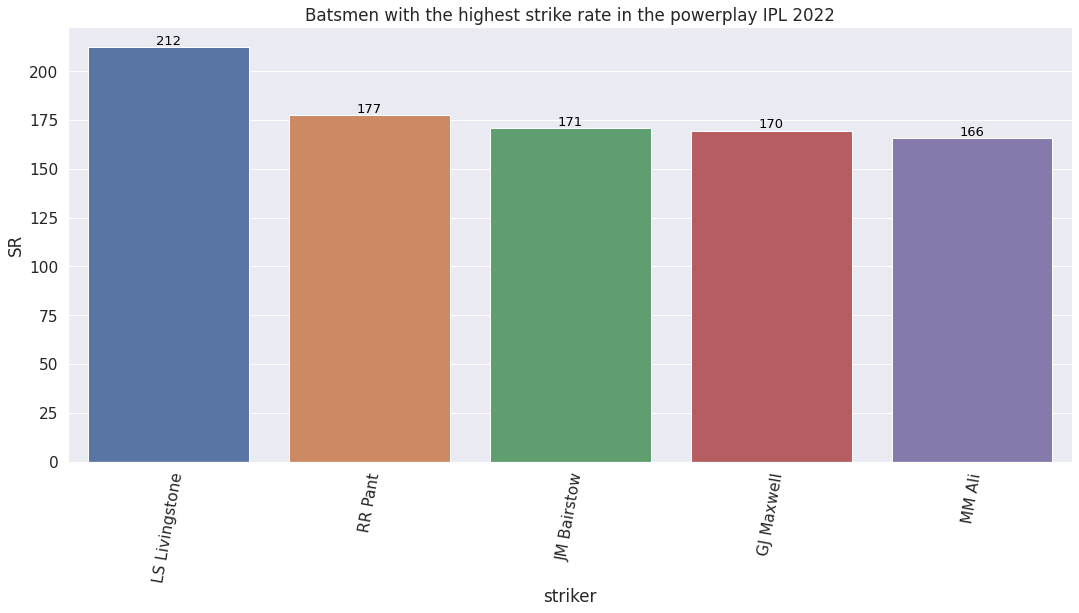

In [107]:
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4)
graph = sns.barplot(x='striker', y='SR', data=batsman_strikerate_2022.head(5))
plt.title("Batsmen with the highest strike rate in the powerplay IPL 2022")
plt.xticks(rotation=80);
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', fontsize=13)

**Batsmen with the most powerplay runs in IPL 2022**

In [108]:
batsman_runs_2022 =best_batting_options(match, season = 2022, min_balls = 30, phase = 'PP', sorter = 'runs')
batsman_runs_2022.head(6)

no of rows after all filters: 39
min max 6.333333333333333 83.5
min max 55.88235294117647 212.12121212121212
min max 11.333333333333334 59.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
20  JC Buttler       17       374   280    7           156   57    11    1       43     20     133.571429  53.428571  40.000000  4.444444  0.610305  0.497246  0.601399  0.945778  1.708950   
44  Q de Kock        15       257   188    9           86    58    10    1       26     12     136.702128  28.555556  20.888889  4.947368  0.287977  0.517283  0.200466  0.929684  1.005727   
6   Abhishek Sharma  14       255   203    6           99    54    12    1       39     3      125.615764  42.500000  33.833333  4.833333  0.468683  0.446326  0.472028  0.933333  1.387036   
52  S Dhawan         14       242   207    6           107   63    10    1       27     8      116.908213  40.333333  34.500000  5.914286  0.440605  0.390593  0.486014  0.898743  1.317212   
49  RG Sharma        14       227   183    9           109   38    7     1       25     12     124.043716  25.222222  20.333333  4.945946  0.244780  0.436264  0.188811  0.929730  0.869855   
13  DA Warner        12       225   146    5           73    39    2     2       32     8      154.109589  45.000000  29.200000  3.650000  0.501080  0.628699  0.374825  0.971200  1.504604

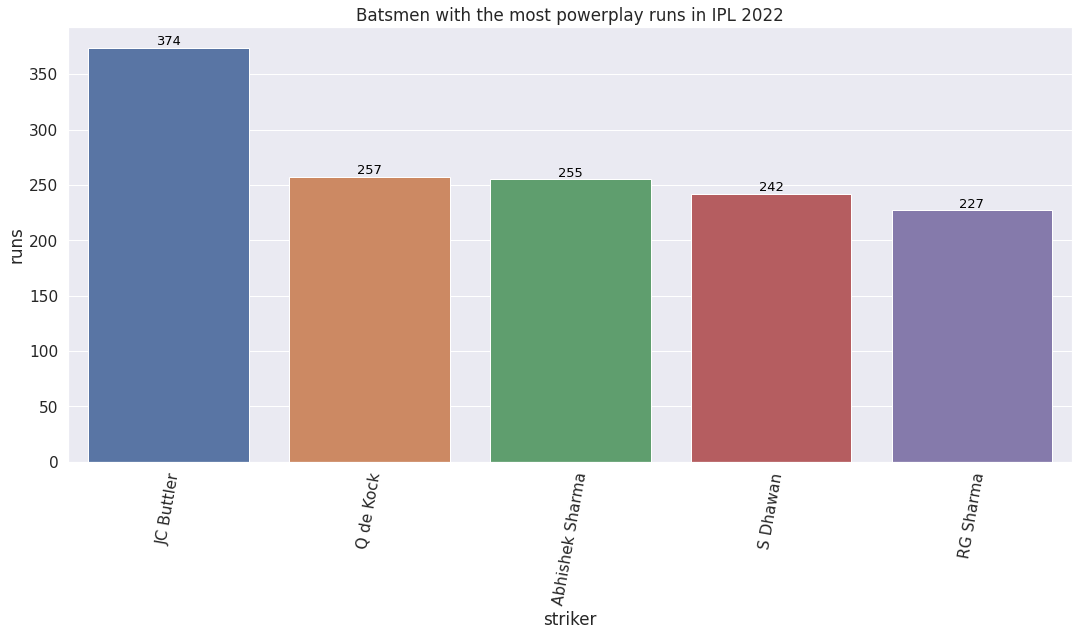

In [109]:
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4)
graph = sns.barplot(x='striker', y='runs', data=batsman_runs_2022.head(5))
plt.title("Batsmen with the most powerplay runs in IPL 2022")
plt.xticks(rotation=80);
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', fontsize=13)

**Batsmen with the highest strike rate in the death overs in IPL 2022**

In [110]:
Batsman_SR_DO_2022 = best_batting_options(match, season = 2022, min_balls = 50, phase = 'DO', sorter = 'SR')
Batsman_SR_DO_2022.head(6)

no of rows after all filters: 16
min max 12.0 80.66666666666667
min max 129.0909090909091 236.53846153846155
min max 7.9 36.666666666666664


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
27  JC Buttler  6        123   52     4           12    19    5     0       10     9      236.538462  30.750000  13.000000  2.736842  0.273058  1.000000  0.177289  1.000000  1.450347   
37  KD Karthik  13       242   110    3           38    32    10    0       19     19     220.000000  80.666667  36.666667  2.894737  1.000000  0.846079  1.000000  0.943782  2.846079   
89  SO Hetmyer  12       218   106    4           40    40    6     0       13     19     205.660377  54.500000  26.500000  3.312500  0.618932  0.712622  0.646582  0.795038  1.978136   
2   AD Russell  5        114   57     3           23    14    5     0       9      9      200.000000  38.000000  19.000000  3.166667  0.378641  0.659941  0.385863  0.846962  1.424445   
41  KL Rahul    6        121   61     3           13    31    3     0       12     6      198.360656  40.333333  20.333333  3.388889  0.412621  0.644684  0.432213  0.767840  1.489519   
57  N Pooran    9        109   58     4           22    19    5     0       8      8      187.931034  27.250000  14.500000  3.625000  0.222087  0.547617  0.229432  0.683773  0.999137

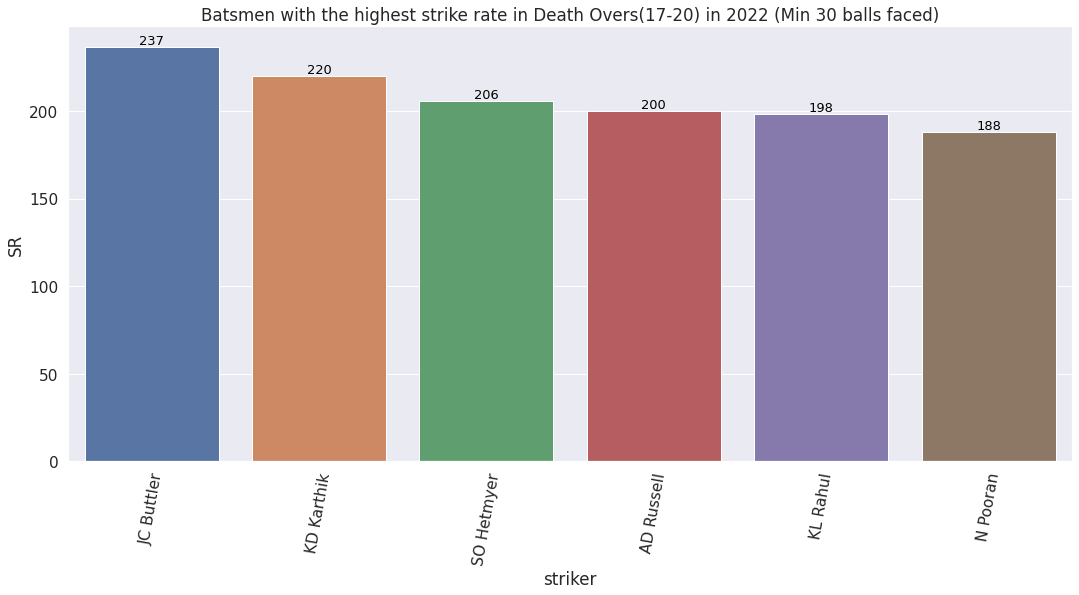

In [111]:
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4)
graph = sns.barplot(x='striker', y='SR', data=Batsman_SR_DO_2022.head(6))
plt.title("Batsmen with the highest strike rate in Death Overs(17-20) in 2022 (Min 30 balls faced)")
plt.xticks(rotation=80);
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', fontsize=13)
              

**Batsmen with the most runs in the death overs in IPL 2022**

In [112]:
Batsman_Runs_DO_2022=best_batting_options(match, season = 2022, min_balls = 30, phase = 'DO', sorter = 'runs')
Batsman_Runs_DO_2022.head()

no of rows after all filters: 33
min max 11.857142857142858 80.66666666666667
min max 129.0909090909091 247.82608695652172
min max 6.571428571428571 36.666666666666664


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
37  KD Karthik  13       242   110    3           38    32    10    0       19     19     220.000000  80.666667  36.666667  2.894737  1.000000  0.765646  1.000000  0.951816  2.765646   
89  SO Hetmyer  12       218   106    4           40    40    6     0       13     19     205.660377  54.500000  26.500000  3.312500  0.619723  0.644876  0.662184  0.863556  1.926783   
15  DA Miller   12       174   100    3           28    40    13    0       15     8      174.000000  58.000000  33.333333  4.347826  0.670588  0.378229  0.889241  0.644825  1.938058   
73  R Tewatia   11       158   88     6           34    32    7     0       16     8      179.545455  26.333333  14.666667  3.666667  0.210381  0.424933  0.268987  0.788732  0.904301   
55  MS Dhoni    11       153   87     7           35    25    10    0       15     8      175.862069  21.857143  12.428571  3.782609  0.145329  0.393912  0.194620  0.764238  0.733861

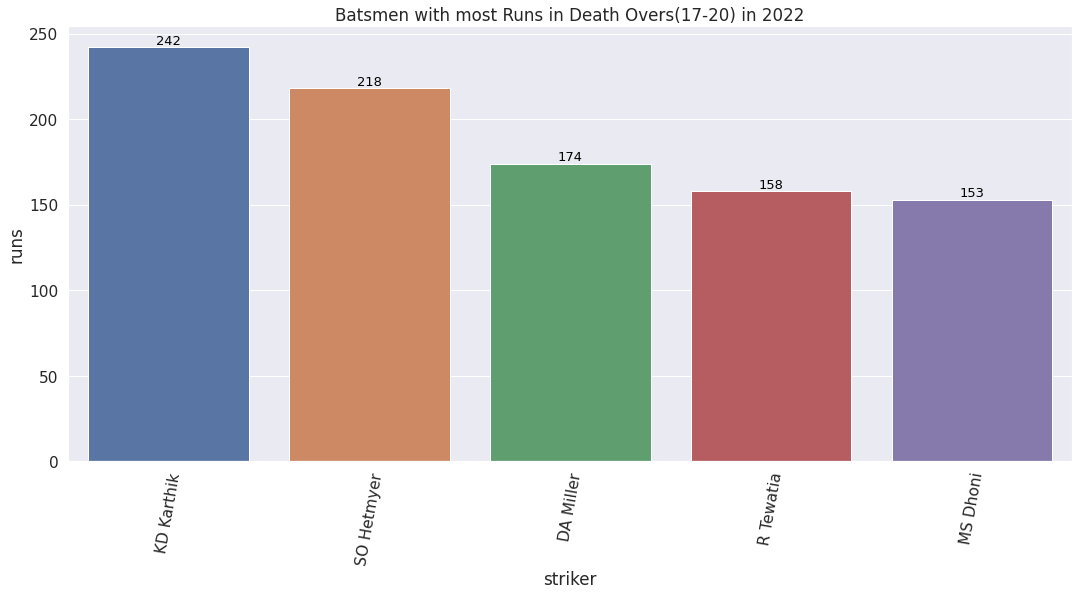

In [113]:
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4)
graph = sns.barplot(x='striker', y='runs', data=Batsman_Runs_DO_2022.head(5))
plt.title("Batsmen with most Runs in Death Overs(17-20) in 2022")
plt.xticks(rotation=80);
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', fontsize=13)

**Most runs in PP in IPL History**

In [114]:
Best_PP_runs =best_batting_options(match,  phase = 'PP', sorter = 'runs')
Best_PP_runs.head(6)

no of rows after all filters: 107
min max 12.333333333333334 78.4
min max 76.79324894514767 173.62924281984334
min max 10.63888888888889 58.8


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
201  S Dhawan   198      3157  2584   86          1223  840   88    15      415    71     122.174923  36.709302  30.046512  5.316872  0.368960  0.468645  0.402973  0.690404  1.240578   
50   DA Warner  153      2892  2106   65          1020  568   124   19      370    89     137.321937  44.492308  32.400000  4.588235  0.486766  0.625064  0.451840  0.791646  1.563669   
43   CH Gayle   135      2373  1761   64          1015  373   40    2       264    143    134.752981  37.078125  27.515625  4.326781  0.374543  0.598535  0.350422  0.827974  1.323500   
70   G Gambhir  147      2277  1868   69          893   593   105   10      310    34     121.895075  33.000000  27.072464  5.430233  0.312815  0.465755  0.341221  0.674653  1.119791   
245  V Kohli    164      2125  1825   58          878   593   84    10      269    43     116.438356  36.637931  31.465517  5.849359  0.367880  0.409405  0.432437  0.616417  1.209721   
18   AM Rahane  139      2049  1783   65          890   550   76    11      273    37     114.918676  31.523077  27.430769  5.751613  0.290460  0.393711  0.348661  0.629998  1.032832

In [115]:
fig = px.bar(Best_PP_runs.head(10), x="striker", y="runs",
                hover_data=['striker'],color='striker',text_auto='runs',labels={
                     "striker": "Batsman",
                     "runs": "Runs" },  title ="Most Runs in Power Play in IPL History(2008-2022)")
fig.show()

**Highest Avg in Power Play in IPL History**

In [116]:
Best_PP_avg =best_batting_options(match,min_innings = 20, phase = 'PP', sorter = 'AVG')
Best_PP_avg.head(6)

no of rows after all filters: 81
min max 12.333333333333334 78.4
min max 76.79324894514767 173.62924281984334
min max 10.63888888888889 58.8


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
108  KP Pietersen  28       392   294    5           134   89    16    2       47     12     133.333333  78.400000  58.800000  4.983051  1.000000  0.583875  1.000000  0.692541  2.583875   
106  KL Rahul      88       1594  1274   28          599   405   60    3       172    62     125.117739  56.928571  45.500000  5.444444  0.675004  0.499034  0.723844  0.617656  1.897882   
83   Ishan Kishan  45       679   551    12          288   146   20    3       88     22     123.230490  56.583333  45.916667  5.009091  0.669778  0.479545  0.732495  0.688315  1.881818   
178  R Dravid      64       905   832    17          470   196   31    1       148    7      108.774038  53.235294  48.941176  5.367742  0.619101  0.330257  0.795295  0.630105  1.744654   
206  SA Yadav      51       727   516    14          254   133   15    4       105    22     140.891473  51.928571  36.857143  4.062992  0.599322  0.661926  0.544386  0.841870  1.805634   
191  RR Pant       44       351   280    7           145   76    14    1       49     8      125.357143  50.142857  40.000000  4.912281  0.572293  0.501507  0.609644  0.704028  1.683444

In [117]:
fig = px.bar(Best_PP_avg.head(10), x="striker", y="AVG",
                hover_data=['striker'],color='striker',text_auto='AVG',labels={
                     "striker": "Batsman",
                     "AVG": "Batting Average" },  title ="Highest Average in Power Play in IPL History(2008-2022)")
fig.show()

**Highest Strike Rate in Powerplay in IPL History**

In [118]:
Best_PP_SR =best_batting_options(match, min_balls = 30,min_innings =20, phase = 'PP', sorter = 'SR')
Best_PP_SR.head(6)

no of rows after all filters: 81
min max 12.333333333333334 78.4
min max 76.79324894514767 173.62924281984334
min max 10.63888888888889 58.8


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
218  SP Narine    42       665   383    36          200   63    11    1       86     38     173.629243  18.472222  10.638889  3.088710  0.092920  1.000000  0.000000  1.000000  1.092920   
93   JM Bairstow  36       695   470    14          231   117   17    4       88     30     147.872340  49.642857  33.571429  3.983051  0.564725  0.734015  0.476163  0.854845  1.774904   
174  PP Shaw      63       1129  766    40          345   208   41    3       155    35     147.389034  28.225000  19.150000  4.031579  0.240540  0.729024  0.176722  0.846969  1.146286   
65   E Lewis      22       420   286    13          145   70    11    2       49     21     146.853147  32.307692  22.000000  4.085714  0.302336  0.723490  0.235898  0.838182  1.261725   
41   CA Lynn      40       779   540    17          271   131   15    0       99     37     144.259259  45.823529  31.764706  3.970588  0.506915  0.696704  0.438649  0.856868  1.642268   
246  V Sehwag     103      1593  1105   61          547   279   56    2       230    46     144.162896  26.114754  18.114754  4.003623  0.208599  0.695709  0.155226  0.851506  1.059534

In [119]:
fig = px.bar(Best_PP_SR.head(10), x="striker", y="SR",
                hover_data=['striker'],color='striker',text_auto='SR',labels={
                     "striker": "Batsman",
                     "SR": " Strike Rate" },  title ="Highest Strike Rate in Power Play in IPL History(2008-2022)")
fig.show()

**Batsmen with the most runs in the death overs in IPL**

In [120]:
Best_DO_runs = best_batting_options(match,  phase = 'DO', sorter = 'runs')
Best_DO_runs.head(6)

no of rows after all filters: 106
min max 7.9 39.72727272727273
min max 101.75438596491229 232.56955810147298
min max 5.944444444444445 24.363636363636363


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
265  MS Dhoni        150      2530  1352   73          415   480   173   4       195    152    187.130178  34.657534  18.520548  3.896254  0.840711  0.652644  0.682772  0.855374  2.176127   
194  KA Pollard      117      1708  941    69          344   323   87    3       110    127    181.509033  24.753623  13.637681  3.970464  0.529534  0.609674  0.417675  0.845559  1.556883   
20   AB de Villiers  75       1421  611    37          157   198   59    3       106    112    232.569558  38.405405  16.513514  2.802752  0.958467  1.000000  0.573807  1.000000  2.532275   
199  KD Karthik      97       1282  695    54          215   253   64    1       121    69     184.460432  23.740741  12.870370  3.657895  0.497710  0.632236  0.376017  0.886899  1.505962   
330  RA Jadeja       111      1155  730    52          219   333   71    2       86     55     158.219178  22.211538  14.038462  5.177305  0.449663  0.431638  0.439434  0.685942  1.320735   
335  RG Sharma       73       1145  581    48          170   217   50    0       90     78     197.074010  23.854167  12.104167  3.458333  0.501273  0.728659  0.334419  0.913293  1.564351

In [121]:
fig = px.bar(Best_DO_runs.head(10), x="striker", y="runs",
                hover_data=['striker'],color='striker',text_auto='runs',labels={
                     "striker": "Batsman",
                     "runs": "Runs" },  title ="Most Runs in Death over in IPL History(2008-2022)")
fig.show()

**Highest Average at the Death Over in IPL History**

In [122]:
Best_DO_avg = best_batting_options(match, min_balls= 30, min_innings = 20,phase = 'DO', sorter = 'AVG')
Best_DO_avg.head(6)

no of rows after all filters: 94
min max 3.8461538461538463 39.72727272727273
min max 75.75757575757575 232.56955810147298
min max 5.076923076923077 24.363636363636363


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
356  S Dhawan        32       437   268    11          71    110   34    1       43     14     163.059701  39.727273  24.363636  4.701754  1.000000  0.556731  1.000000  0.901079  2.556731   
20   AB de Villiers  75       1421  611    37          157   198   59    3       106    112    232.569558  38.405405  16.513514  2.802752  0.963160  1.000000  0.592978  1.000000  2.556137   
265  MS Dhoni        150      2530  1352   73          415   480   173   4       195    152    187.130178  34.657534  18.520548  3.896254  0.858707  0.710230  0.697041  0.943039  2.265978   
205  KL Rahul        33       552   283    16          73    114   29    0       50     30     195.053004  34.500000  17.687500  3.537500  0.854317  0.760755  0.653848  0.961726  2.268919   
83   CH Gayle        24       404   196    12          68    73    5     1       27     35     206.122449  33.666667  16.333333  3.161290  0.831092  0.831345  0.583635  0.981323  2.246073   
245  MC Henriques    24       290   166    9           41    64    23    0       27     12     174.698795  32.222222  18.444444  4.256410  0.790836  0.630954  0.693095  0.924278  2.114885

In [123]:
fig = px.bar(Best_DO_avg.head(10), x="striker", y="AVG",
                hover_data=['striker'],color='striker',text_auto='AVG',labels={
                     "striker": "Batsman",
                     "AVG": "Average" },  title ="Highest average in Death over in IPL History(2008-2022)")
fig.show()

**Highest Strike Rate at the Death Over in IPL History**

In [124]:
Best_DO_SR = best_batting_options(match, min_balls= 30,min_innings = 20, phase = 'DO', sorter = 'SR')
Best_DO_SR.head(6)

no of rows after all filters: 94
min max 3.8461538461538463 39.72727272727273
min max 75.75757575757575 232.56955810147298
min max 5.076923076923077 24.363636363636363


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
20   AB de Villiers  75       1421  611    37          157   198   59    3       106    112    232.569558  38.405405  16.513514  2.802752  0.963160  1.000000  0.592978  1.000000  2.556137   
27   AD Russell      49       854   408    36          171   114   19    0       60     77     209.313725  23.722222  11.333333  2.978102  0.553942  0.851696  0.324390  0.990866  1.730028   
83   CH Gayle        24       404   196    12          68    73    5     1       27     35     206.122449  33.666667  16.333333  3.161290  0.831092  0.831345  0.583635  0.981323  2.246073   
342  RR Pant         40       534   264    25          95    77    20    1       48     37     202.272727  21.360000  10.560000  3.105882  0.488108  0.806795  0.284293  0.984210  1.579196   
439  V Kohli         62       991   491    38          125   180   69    3       70     64     201.832994  26.078947  12.921053  3.664179  0.619624  0.803991  0.406712  0.955128  1.830326   
169  JC Buttler      22       328   163    12          55    52    19    0       25     23     201.226994  27.333333  13.583333  3.395833  0.654583  0.800126  0.441050  0.969106  1.895760

In [125]:
fig = px.bar(Best_DO_SR.head(10), x="striker", y="SR",
                hover_data=['striker'],color='striker',text_auto='SR',labels={
                     "striker": "Batsman",
                     "SR": "Strike Rate" },  title ="Highest Strike Rate in Death over in IPL History(2008-2022)")
fig.show()

In [126]:
match.head(1)

match_id  season  start_date                  venue  innings  ball                 batting_team           bowling_team     striker non_striker      bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty wicket_type player_dismissed  other_wicket_type  other_player_dismissed               bowl_style bowling_style           bat_style batting_style  wides_cnt_balls  noballs_cnt_balls  noballs_cnt_balls_bowler  byes_cnt_balls  legbyes_cnt_balls  legal_ball  legal_ball_bowler  over_no  ball_no phase  isDot  isOne  isTwo  isThree  isFour  isSix
0  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        6.8   Royal Challengers Bangalore  Kolkata Knight Riders  MV Boucher  CL White    AB Agarkar  4             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  6        8        MO    0      0      0      0        1       0

In [127]:
min_innings =20
fig = px.scatter(DO_match[DO_match.innings >= min_innings], x="AVG", y="SR",
                hover_data=['striker'],color='striker',labels={
                     "AVG": "Batting Average",
                     "SR": "Strike Rate" },  title ="Comparision of Average VS Strike Rate in Death Over")
fig.show()

##**5.1** **Best Batting Option in PowerPlay Against Pace**

**Best Batting Option in PowerPlay Innings 1**



In [128]:
best_batting_options(match, min_balls = 30,innings = 1, phase = 'PP').head()

no of rows after all filters: 137
min max 5.25 152.0
min max 43.75 184.44444444444446
min max 9.0 107.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR    AVG    BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
59   HM Amla       8        152   107    1           52    30    4     0       21     5      142.056075  152.0  107.0  4.115385  1.000000  0.698720  1.000000  0.952033  2.698720   
174  SPD Smith     16       206   160    2           61    68    4     2       25     4      128.750000  103.0  80.0   5.517241  0.666099  0.604146  0.724490  0.877409  1.994735   
161  SA Asnodkar   8        173   114    2           56    21    7     0       24     7      151.754386  86.5   57.0   3.677419  0.553663  0.767652  0.489796  0.975346  1.811111   
148  RM Patidar    6        86    65     1           32    17    1     1       13     2      132.307692  86.0   65.0   4.333333  0.550256  0.629433  0.571429  0.940431  1.751117   
96   MC Henriques  9        82    71     1           34    27    3     1       7      3      115.492958  82.0   71.0   7.100000  0.522998  0.509920  0.632653  0.793156  1.665572

**Best Batting Option in PowerPlay Innings 2**

In [129]:
best_batting_options(match, min_balls = 30, innings = 2, phase = 'PP').head()

no of rows after all filters: 140
min max 6.666666666666667 213.0
min max 58.82352941176471 181.3008130081301
min max 10.333333333333334 160.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR    AVG    BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
91   KP Pietersen  16       213   160    1           74    50    7     1       26     7      133.125000  213.0  160.0  4.848485  1.000000  0.606655  1.000000  0.929242  2.606655   
10   AD Hales      3        87    49     1           20    13    3     0       8      6      177.551020  87.0   49.0   3.500000  0.389338  0.969384  0.258352  0.977157  1.617073   
78   JP Duminy     11       111   110    1           66    28    6     1       14     2      100.909091  111.0  110.0  6.875000  0.505654  0.343619  0.665924  0.857234  1.515198   
89   KL Rahul      41       872   634    10          278   207   35    3       88     39     137.539432  87.2   63.4   4.992126  0.390307  0.642698  0.354566  0.924138  1.387571   
124  MR Marsh      5        85    63     1           30    18    2     1       6      6      134.920635  85.0   63.0   5.250000  0.379645  0.621316  0.351893  0.914975  1.352854

**Best Bastmen Against Pace in Power Play Considering minimum Innings played is 20 and minimum balls played is 30**

In [130]:
PP_pace = best_batting_options(match, min_balls = 30,min_innings = 20, bowling_style = 'Pace', phase = 'PP')
PP_pace.head(10)

no of rows after all filters: 76
min max 15.5 120.5
min max 73.03370786516854 156.66666666666666
min max 11.0 95.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR         AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
99   KP Pietersen  24       241   190    2           92    52    11    2       27     8      126.842105  120.500000  95.000000  5.428571  1.000000  0.643387  1.000000  0.669563  2.643387   
129  ML Hayden     31       500   361    6           185   91    18    1       70     15     138.504155  83.333333   60.166667  4.247059  0.646032  0.782831  0.585317  0.862474  2.014180   
74   Ishan Kishan  41       487   374    6           194   92    16    3       63     17     130.213904  81.166667   62.333333  4.675000  0.625397  0.683704  0.611111  0.792602  1.920212   
84   JM Bairstow   35       517   330    10          153   82    15    3       69     20     156.666667  51.700000   33.000000  3.707865  0.344762  1.000000  0.261905  0.950511  1.606667   
35   CA Lynn       39       585   388    11          196   89    11    0       78     27     150.773196  53.181818   35.272727  3.695238  0.358874  0.929532  0.288961  0.952573  1.577367   
50   DJ Hussey     21       122   103    2           58    22    5     0       18     3      118.446602  61.000000   51.500000  4.904762  0.433333  0.543002  0.482143  0.755088  1.458479   
192  SA Yadav      46       510   354    11          185   73    12    3       77     16     144.067797  46.363636   32.181818  3.806452  0.293939  0.849355  0.252165  0.934414  1.395459   
164  R Dravid      61       768   692    13          401   147   26    1       130    6      110.982659  59.076923   53.230769  5.088235  0.415018  0.453756  0.502747  0.725131  1.371521   
97   KL Rahul      87       1256  1040   23          502   323   53    3       134    47     120.769231  54.608696   45.217391  5.745856  0.372464  0.570774  0.407350  0.617759  1.350588   
78   JC Buttler    61       915   638    21          338   133   22    1       124    39     143.416928  43.571429   30.380952  3.914110  0.267347  0.841573  0.230726  0.916836  1.339645

##**5.2** **Best Batting Option in PowerPlay Against Spin**

**Best Bastmen Against Spin in Power Play Considering minimum Innings played is 20 and minimum balls played is 30** 

In [131]:
best_batting_options(match, min_balls = 30,min_innings = 20, bowling_style = 'Spin', phase = 'PP').head(10)

no of rows after all filters: 46
min max 16.2 271.0
min max 89.23076923076924 245.8823529411765
min max 9.444444444444445 171.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR         AVG         BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
51   KL Rahul    38       271   171    1           59    67    5     0       29     13     158.479532  271.000000  171.000000  4.071429  1.000000  0.442056  1.000000  0.762223  2.442056   
42   JH Kallis   28       134   127    1           61    48    7     0       12     4      105.511811  134.000000  127.000000  7.937500  0.462323  0.103932  0.727648  0.244075  1.293903   
83   R Dravid    26       115   105    1           46    41    4     0       15     1      109.523810  115.000000  105.000000  6.562500  0.387755  0.129543  0.591472  0.428358  1.108769   
73   N Rana      21       104   74     1           36    22    0     0       10     7      140.540541  104.000000  74.000000   4.352941  0.344584  0.327541  0.399587  0.724493  1.071712   
104  SP Narine   21       209   85     9           28    18    3     1       20     17     245.882353  23.222222   9.444444    2.297297  0.027560  1.000000  0.000000  1.000000  1.027560   
21   D Padikkal  20       98    97     1           41    41    5     1       11     0      101.030928  98.000000   97.000000   8.818182  0.321036  0.075327  0.541953  0.126042  0.938317   
105  SPD Smith   24       83    80     1           34    37    0     0       7      3      103.750000  83.000000   80.000000   8.000000  0.262166  0.092685  0.436726  0.235698  0.791578   
23   DA Warner   86       625   452    9           215   133   19    2       73     26     138.274336  69.444444   50.222222   4.565657  0.208966  0.313074  0.252407  0.695984  0.774447   
61   MEK Hussey  31       217   197    3           88    71    12    2       20     6      110.152284  72.333333   65.666667   7.576923  0.220304  0.133554  0.348006  0.292401  0.701863   
94   SA Yadav    27       171   122    3           51    47    1     0       23     5      140.163934  57.000000   40.666667   4.357143  0.160126  0.325137  0.193260  0.723930  0.678522

##**5.3** **Best Batting Option in Death Over Against Spin**

**Best Bastmen Against Spin in Death Over Considering minimum Innings played is 20 and minimum balls played is 30**

In [132]:
best_batting_options(match, min_balls = 30,min_innings = 20, bowling_style = 'Spin', phase = 'DO').head(10)

no of rows after all filters: 15
min max 9.428571428571429 69.33333333333333
min max 126.92307692307692 195.15151515151516
min max 7.428571428571429 37.666666666666664


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
91   JP Duminy       30       208   113    3           18    53    19    1       9      13     184.070796  69.333333  37.666667  5.136364  1.000000  0.837594  1.000000  0.585492  2.837594   
220  V Kohli         26       178   94     3           25    42    7     0       8      15     189.361702  59.333333  31.333333  4.086957  0.833068  0.915141  0.790551  0.904483  2.538760   
70   HH Pandya       25       116   71     2           26    31    2     1       6      9      163.380282  58.000000  35.500000  4.733333  0.810811  0.534340  0.928346  0.708002  2.273498   
95   KA Pollard      45       322   165    9           54    52    18    2       12     30     195.151515  35.777778  18.333333  3.928571  0.439852  1.000000  0.360630  0.952628  1.800482   
82   JA Morkel       21       128   66     4           21    22    11    0       3      12     193.939394  32.000000  16.500000  4.400000  0.376789  0.982234  0.300000  0.809326  1.659023   
97   KD Karthik      29       177   97     6           23    41    13    0       17     7      182.474227  29.500000  16.166667  4.041667  0.335056  0.814193  0.288976  0.918250  1.438226   
51   DJ Bravo        20       110   59     4           17    19    9     1       4      9      186.440678  27.500000  14.750000  4.538462  0.301669  0.872328  0.242126  0.767238  1.416124   
9    AB de Villiers  32       150   83     6           27    32    6     0       13     9      180.722892  25.000000  13.833333  3.772727  0.259936  0.788525  0.211811  1.000000  1.260272   
23   AT Rayudu       30       136   76     6           18    34    9     0       9      8      178.947368  22.666667  12.666667  4.470588  0.220986  0.762502  0.173228  0.787870  1.156716   
132  MS Dhoni        52       294   190    12          70    76    15    0       17     20     154.736842  24.500000  15.833333  5.135135  0.251590  0.407656  0.277953  0.585866  0.937199

**Best Batting Option in Death Overs Innings 1**

In [133]:
best_batting_options(match, min_balls = 30, innings = 1, phase = 'DO').head()

no of rows after all filters: 191
min max 3.8 78.0
min max 48.64864864864865 246.0
min max 4.428571428571429 61.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR   AVG   BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
120  Harpreet Brar  6        78    61     1           30    20    7     0       5      4      127.868852  78.0  61.0  6.777778  1.000000  0.401417  1.000000  0.863083  2.401417   
15   AC Voges       4        66    44     1           11    19    6     1       5      2      150.000000  66.0  44.0  6.285714  0.838275  0.513558  0.699495  0.879279  2.051328   
46   B Chipli       5        61    33     1           3     18    3     1       7      1      184.848485  61.0  33.0  4.125000  0.770889  0.690139  0.505051  0.950398  1.966079   
214  MN van Wyk     3        54    35     1           8     14    7     0       5      1      154.285714  54.0  35.0  5.833333  0.676550  0.535274  0.540404  0.894169  1.752228   
32   AS Raut        5        54    39     1           20    14    4     0       2      4      138.461538  54.0  39.0  6.500000  0.676550  0.455091  0.611111  0.872226  1.742752

**Best Batting Option in Death Overs Innings 2**

In [134]:
best_batting_options(match,min_balls = 30, innings = 2, phase = 'DO').head()

no of rows after all filters: 157
min max 2.4285714285714284 131.0
min max 52.94117647058824 244.11764705882354
min max 4.571428571428571 61.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR    AVG   BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
115  GJ Maxwell  9        131   61     1           14    19    8     0       18     4      214.754098  131.0  61.0  2.772727  1.000000  0.846406  1.000000  0.994377  2.846406   
30   AK Markram  6        93    45     1           6     23    3     0       7      6      206.666667  93.0   45.0  3.461538  0.704444  0.804103  0.716456  0.980174  2.225003   
358  TM Dilshan  4        71    30     1           9     7     4     0       8      4      236.666667  71.0   30.0  2.500000  0.533333  0.961026  0.450633  1.000000  1.944992   
222  MV Boucher  8        130   73     2           16    30    15    0       7      7      178.082192  65.0   36.5  5.214286  0.486667  0.654584  0.565823  0.944035  1.707073   
299  S Dhawan    13       132   93     2           32    36    13    0       13     3      141.935484  66.0   46.5  5.812500  0.494444  0.465509  0.743038  0.931701  1.702991

##**5.4** **Best Batting Option in Death Over Against Pace**

**Best Bastmen Against Pace in Death Over Considering minimum Innings played is 20 and minimum balls played is 30**

In [135]:
best_batting_options(match, min_balls = 30,min_innings = 20, bowling_style = 'Pace', phase = 'DO').head(10)

no of rows after all filters: 86
min max 3.8 39.0
min max 77.77777777777779 238.28920570264765
min max 4.8 19.654545454545456


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
19   AB de Villiers    67       1170  491    30          123   155   48    3       88     93     238.289206  39.000000  16.366667  2.712707  1.000000  1.000000  0.778662  1.000000  2.778662   
251  MS Dhoni          135      2099  1081   55          314   377   153   4       168    122    194.172063  38.163636  19.654545  3.727586  0.976240  0.725146  1.000000  0.923620  2.701386   
371  SO Hetmyer        28       401   198    11          67    69    22    0       24     32     202.525253  36.454545  18.000000  3.535714  0.927686  0.777187  0.888617  0.938061  2.593490   
75   CH Gayle          21       286   142    8           51    55    3     1       18     25     201.408451  35.750000  17.750000  3.302326  0.907670  0.770230  0.871787  0.955625  2.549687   
93   DA Miller         54       632   351    19          99    134   45    0       45     38     180.056980  33.263158  18.473684  4.228916  0.837022  0.637208  0.920505  0.885890  2.394735   
362  SK Raina          46       494   291    15          77    130   33    0       46     19     169.759450  32.933333  19.400000  4.476923  0.827652  0.573054  0.982864  0.867225  2.383569   
193  KL Rahul          33       510   257    16          67    100   27    0       47     28     198.443580  31.875000  16.062500  3.426667  0.797585  0.751758  0.758185  0.946267  2.307529   
157  JC Buttler        20       252   122    8           43    38    14    0       18     19     206.557377  31.500000  15.250000  3.297297  0.786932  0.802308  0.703488  0.956004  2.292728   
108  DPMD Jayawardene  21       247   135    8           38    49    17    0       32     6      182.962963  30.875000  16.875000  3.552632  0.769176  0.655313  0.812882  0.936787  2.237371   
338  S Dhawan          30       323   195    11          54    76    23    1       36     9      165.641026  29.363636  17.727273  4.333333  0.726240  0.547396  0.870257  0.878032  2.143892

**Considering the players statistics and upcoming bowling attack from Mumbai Indians team.** 
  **JC Archer and JJ Bumrah as the Death Over specialists -
Best batsmen's listed  against these two Bowler's**

In [136]:
best_batting_options(match, min_balls = 20, phase = 'PP', bowlers=['JC Archer', 'JJ Bumrah']).head()

no of rows after all filters: 19
min max 6.5 60.0
min max 46.42857142857143 157.89473684210526
min max 8.666666666666666 41.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR   AVG   BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
32  V Kohli    12       60    38     1           19    8     0     0       10     2      157.894737  60.0  38.0  3.166667  1.000000  1.000000  0.907216  1.000000  2.907216   
3   CA Lynn    8        47    34     1           17    9     1     0       6      2      138.235294  47.0  34.0  4.250000  0.757009  0.823629  0.783505  0.942478  2.364143   
0   AM Rahane  12       45    40     1           20    13    1     2       6      0      112.500000  45.0  40.0  6.666667  0.719626  0.592749  0.969072  0.814159  2.281447   
33  WP Saha    6        44    31     1           13    10    1     0       5      2      141.935484  44.0  31.0  4.428571  0.700935  0.856824  0.690722  0.932996  2.248480   
6   DA Warner  9        41    41     1           20    13    2     0       6      0      100.000000  41.0  41.0  6.833333  0.644860  0.480607  1.000000  0.805310  2.125467

In [137]:
# if bowlers are included in the input, change the min balls bowled
best_batting_options(match, min_balls = 12,  phase = 'DO', bowlers=['JC Archer', 'JJ Bumrah']).head(10)

no of rows after all filters: 24
min max 4.0 88.0
min max 57.14285714285714 241.66666666666666
min max 4.0 38.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG   BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
0   AB de Villiers  7        88    38     1           11    11    2     1       7      7      231.578947  88.000000  38.0  2.714286  1.000000  0.945331  1.000000  0.991778  2.945331   
1   AD Russell      7        54    30     1           11    10    1     0       6      3      180.000000  54.000000  30.0  3.333333  0.595238  0.665806  0.764706  0.947242  2.025750   
31  KL Rahul        11       99    54     2           16    19    9     0       11     3      183.333333  49.500000  27.0  3.857143  0.541667  0.683871  0.676471  0.909558  1.902008   
43  PJ Cummins      6        41    21     1           8     5     4     0       1      4      195.238095  41.000000  21.0  4.200000  0.440476  0.748387  0.500000  0.884892  1.688863   
47  RA Jadeja       9        42    29     1           11    12    3     0       6      0      144.827586  42.000000  29.0  4.833333  0.452381  0.475195  0.735294  0.839329  1.662870   
49  RR Pant         3        29    12     1           5     2     1     1       1      3      241.666667  29.000000  12.0  3.000000  0.297619  1.000000  0.235294  0.971223  1.532913   
53  SA Yadav        4        28    13     1           7     2     0     0       2      3      215.384615  28.000000  13.0  2.600000  0.285714  0.857568  0.264706  1.000000  1.407988   
59  SPD Smith       4        32    23     1           6     10    4     0       2      1      139.130435  32.000000  23.0  7.666667  0.333333  0.444320  0.558824  0.635492  1.336477   
36  MS Dhoni        15       82    66     3           23    30    10    0       5      2      124.242424  27.333333  22.0  9.428571  0.277778  0.363636  0.529412  0.508736  1.170826   
26  JP Faulkner     4        26    18     1           6     10    1     0       2      1      144.444444  26.000000  18.0  6.000000  0.261905  0.473118  0.411765  0.755396  1.146788

In [138]:
best_batting_options(match, min_balls = 12, phase = 'PP', bowlers=['JC Archer'])

no of rows after all filters: 6
min max 4.5 35.0
min max 64.70588235294117 166.66666666666669
min max 6.0 21.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR   AVG   BPD   BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
11  Q de Kock    4        35    21     1           12    1     2     0       3      3      166.666667  35.0  21.0  3.5   1.000000  1.000000  1.000000  1.000000  3.000000   
3   DA Warner    3        13    16     1           10    3     1     0       2      0      81.250000   13.0  16.0  8.0   0.278689  0.162260  0.666667  0.526316  1.107615   
5   JM Bairstow  3        12    13     1           8     2     1     0       2      0      92.307692   12.0  13.0  6.5   0.245902  0.270710  0.466667  0.684211  0.983278   
10  PP Shaw      4        12    12     2           6     4     0     0       2      0      100.000000  6.0   6.0   6.0   0.049180  0.346154  0.000000  0.736842  0.395334   
2   CH Gayle     5        11    17     2           12    3     0     0       2      0      64.705882   5.5   8.5   8.5   0.032787  0.000000  0.166667  0.473684  0.199454   
9   N Rana       4        9     13     2           9     1     2     0       1      0      69.230769   4.5   6.5   13.0  0.000000  0.044379  0.033333  0.000000  0.077712

In [139]:
best_batting_options(match, min_balls = 12, phase = 'DO', bowlers=['JC Archer'])

no of rows after all filters: 3
min max 15.5 22.0
min max 129.41176470588235 166.66666666666669
min max 11.5 17.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR   AVG   BPD   BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
9   MP Stoinis  4        22    17     1           3     10    2     0       2      0      129.411765  22.0  17.0  8.50  1.000000  0.000000  1.000000  0.000000  2.000000   
11  N Pooran    3        20    12     1           6     2     1     0       1      2      166.666667  20.0  12.0  4.00  0.692308  1.000000  0.090909  1.000000  1.783217   
4   HH Pandya   6        31    23     2           8     11    1     0       3      1      134.782609  15.5  11.5  5.75  0.000000  0.144165  0.000000  0.611111  0.144165

In [140]:
best_batting_options(match, min_balls = 12, phase = 'PP', bowlers=['JJ Bumrah']).head()

no of rows after all filters: 15
min max 4.5 59.0
min max 69.23076923076923 187.5
min max 6.5 50.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR   AVG   BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
23  V Kohli      9        59    33     1           15    7     0     0       10     2      178.787879  59.0  33.0  2.750000  1.000000  0.926337  0.609195  0.992647  2.535532   
24  WP Saha      6        44    31     1           13    10    1     0       5      2      141.935484  44.0  31.0  4.428571  0.724771  0.614739  0.563218  0.844538  1.902728   
18  S Dhawan     13       44    50     1           28    17    0     1       6      0      88.000000   44.0  50.0  8.333333  0.724771  0.158699  1.000000  0.500000  1.883470   
1   BB McCullum  4        30    16     1           9     2     1     0       5      1      187.500000  30.0  16.0  2.666667  0.467890  1.000000  0.218391  1.000000  1.686281   
20  SPD Smith    7        29    25     1           12    9     2     0       1      2      116.000000  29.0  25.0  8.333333  0.449541  0.395447  0.425287  0.500000  1.270276

In [141]:
best_batting_options(match, min_balls = 12, phase = 'DO', bowlers=['JJ Bumrah']).head()

no of rows after all filters: 17
min max 4.0 80.0
min max 66.66666666666666 230.76923076923075
min max 4.333333333333333 36.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR   AVG   BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
0   AB de Villiers  6        80    36     1           11    11    1     1       7      6      222.222222  80.0  36.0  2.769231  1.000000  0.947917  1.000000  1.000000  2.947917   
1   AD Russell      5        42    25     1           10    8     1     0       5      2      168.000000  42.0  25.0  3.571429  0.500000  0.617500  0.652632  0.936987  1.770132   
34  PJ Cummins      4        30    13     1           6     2     2     0       0      4      230.769231  30.0  13.0  3.250000  0.342105  1.000000  0.273684  0.962236  1.615789   
49  SPD Smith       4        32    23     1           6     10    4     0       2      1      139.130435  32.0  23.0  7.666667  0.368421  0.441576  0.589474  0.615307  1.399471   
37  RA Jadeja       5        29    19     1           8     7     3     0       4      0      152.631579  29.0  19.0  4.750000  0.328947  0.523849  0.463158  0.844411  1.315954

In [142]:
best_batting_options(match, min_balls = 10, bowling_team = 'Mumbai Indians', venue = 'Wankhede Stadium', phase = 'DO', bowlers = ['JJ Bumrah'])

no of rows after all filters: 4
min max 10.0 28.0
min max 107.6923076923077 158.33333333333331
min max 7.0 18.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR   AVG   BPD   BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
8   KL Rahul   3        28    18     1           8     6     2     0       3      1      155.555556  28.0  18.0  4.5   1.000000  0.945148  1.000000  0.894737  2.945148   
11  MS Dhoni   3        19    12     1           6     3     2     0       0      2      158.333333  19.0  12.0  6.0   0.500000  1.000000  0.454545  0.736842  1.954545   
2   AR Patel   4        14    13     1           3     8     1     0       1      0      107.692308  14.0  13.0  13.0  0.222222  0.000000  0.545455  0.000000  0.767677   
9   MK Tiwary  3        20    14     2           6     4     0     0       4      0      142.857143  10.0  7.0   3.5   0.000000  0.694394  0.000000  1.000000  0.694394

In [143]:
best_batting_options(match, min_balls = 12, bowling_team = 'Chennai Super Kings', phase = 'DO', bowlers = ['DJ Bravo']).head()

no of rows after all filters: 16
min max 6.0 51.0
min max 93.33333333333333 258.33333333333337
min max 6.0 31.0


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
23  HH Pandya   7        51    31     1           9     13    6     0       2      3      164.516129  51.000000  31.000000  6.200000  1.000000  0.431411  1.000000  0.685714  2.431411   
80  V Shankar   4        43    17     1           4     7     1     0       1      5      252.941176  43.000000  17.000000  2.833333  0.822222  0.967320  0.440000  0.948052  2.229542   
31  KA Pollard  9        80    41     3           15    13    1     1       5      7      195.121951  26.666667  13.666667  3.416667  0.459259  0.616901  0.306667  0.902597  1.382827   
73  SPD Smith   4        25    13     1           4     4     1     1       1      2      192.307692  25.000000  13.000000  4.333333  0.422222  0.599845  0.280000  0.831169  1.302067   
6   AT Rayudu   5        27    19     1           4     11    1     0       2      1      142.105263  27.000000  19.000000  6.333333  0.466667  0.295587  0.520000  0.675325  1.282254

#**6.** **Bowling Statistics**

In [144]:
match.wicket_type.unique()


array([nan, 'caught', 'bowled', 'run out', 'lbw', 'stumped',
       'retired hurt', 'caught and bowled', 'hit wicket',
       'obstructing the field', 'retired out'], dtype=object)

In [145]:
# replace NaNs to 0
# match['byes'].fillna(0, inplace = True)
# match['legbyes'].fillna(0, inplace = True)

def total_runs_calc(runs_off_bat, extras, byes, legbyes):
  
  total_runs = runs_off_bat + extras
  if byes != byes:
    total_runs = total_runs + 0
  else:
    total_runs = total_runs - byes

  if legbyes != legbyes:
    total_runs = total_runs + 0
  else:
    total_runs = total_runs - legbyes

  return total_runs

  


# match['total_runs']= (match['runs_off_bat'] + match['extras'] - match['byes'] - match['legbyes'])
match['total_runs']= match.apply(lambda x: total_runs_calc(x['runs_off_bat'], x['extras'], x['byes'], x['legbyes']), axis =1 )

In [146]:
match.innings.value_counts()

1    116882
2    108910
Name: innings, dtype: int64

In [147]:
match.head()


match_id  season  start_date                  venue  innings  ball                 batting_team           bowling_team     striker non_striker      bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty wicket_type player_dismissed  other_wicket_type  other_player_dismissed               bowl_style bowling_style           bat_style batting_style  wides_cnt_balls  noballs_cnt_balls  noballs_cnt_balls_bowler  byes_cnt_balls  legbyes_cnt_balls  legal_ball  legal_ball_bowler  over_no  ball_no phase  isDot  isOne  isTwo  isThree  isFour  isSix  total_runs
0  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        6.8   Royal Challengers Bangalore  Kolkata Knight Riders  MV Boucher  CL White    AB Agarkar  4             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  6        8        MO    0      0      0      0        1       0      4.0       
1  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        2.7   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   AB Dinda    1             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  2        7        PP    0      1      0      0        0       0      1.0       
2  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        3.1   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   I Sharma    2             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  3        1        PP    0      0      1      0        0       0      2.0       
3  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        3.2   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   I Sharma    1             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  3        2        PP    0      1      0      0        0       0      1.0       
4  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        3.3   Royal Challengers Bangalore  Kolkata Knight Riders  JH Kallis   W Jaffer    I Sharma    0             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  3        3        PP    1      0      0      0        0       0      0.0

In [148]:
def is_wicket(player_dismissed, wicket_type):
    if type(player_dismissed) != str:
        return 0
    elif ~(type(player_dismissed) != str) & (wicket_type not in ['run out', 'retired hurt', 'obstructing the field']):
        return 1
    else:
        return 0

In [149]:
match['isBowlerWk'] = match.apply(lambda x: is_wicket(x['player_dismissed'], x['wicket_type']), axis = 1)

In [150]:
match[match.wicket_type == 'run out'].head(2)

match_id  season  start_date                  venue  innings  ball                 batting_team           bowling_team    striker non_striker      bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty wicket_type player_dismissed  other_wicket_type  other_player_dismissed          bowl_style bowling_style           bat_style batting_style  wides_cnt_balls  noballs_cnt_balls  noballs_cnt_balls_bowler  byes_cnt_balls  legbyes_cnt_balls  legal_ball  legal_ball_bowler  over_no  ball_no phase  isDot  isOne  isTwo  isThree  isFour  isSix  total_runs  isBowlerWk
84   335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        11.1  Royal Challengers Bangalore  Kolkata Knight Riders  AA Noffke  P Kumar     SC Ganguly  1             0      NaN    NaN      NaN   NaN      NaN       run out     AA Noffke       NaN                NaN                       Right-arm medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  11       1        MO    0      1      0      0        0       0      1.0         0         
315  335984    2008    19-04-2008  Feroz Shah Kotla       1        6.2   Rajasthan Royals             Delhi Capitals         SR Watson  M Kaif      R Bhatia    1             0      NaN    NaN      NaN   NaN      NaN       run out     SR Watson       NaN                NaN                       Right-arm medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  6        2        MO    0      1      0      0        0       0      1.0         0

In [151]:
match[match.wicket_type == 'lbw'].head(2)

match_id  season  start_date                                         venue  innings  ball         batting_team    bowling_team     striker non_striker       bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty wicket_type player_dismissed  other_wicket_type  other_player_dismissed               bowl_style bowling_style           bat_style batting_style  wides_cnt_balls  noballs_cnt_balls  noballs_cnt_balls_bowler  byes_cnt_balls  legbyes_cnt_balls  legal_ball  legal_ball_bowler  over_no  ball_no phase  isDot  isOne  isTwo  isThree  isFour  isSix  total_runs  isBowlerWk
247  335984    2008    19-04-2008  Feroz Shah Kotla                              1        7.4   Rajasthan Royals     Delhi Capitals  DS Lehmann  M Kaif      MF Maharoof  0             0      NaN    NaN      NaN   NaN      NaN       lbw         DS Lehmann      NaN                NaN                       Right-arm fast-medium   Pace           Left Handed Bat    LHB           1                1                  1                         1               1                  1           1                  7        4        MO    1      0      0      0        0       0      0.0         1         
556  335983    2008    19-04-2008  Punjab Cricket Association IS Bindra Stadium  1        7.1   Chennai Super Kings  Punjab Kings    MS Dhoni    MEK Hussey  JR Hopes     0             0      NaN    NaN      NaN   NaN      NaN       lbw         MS Dhoni        NaN                NaN                       Right-arm medium        Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  7        1        MO    1      0      0      0        0       0      0.0         1

In [152]:
def isOut(player_dismissed):
    try:
        x = math.isnan(player_dismissed)
        return 0
    except:
        return 1

In [153]:
match['isOut'] = match['player_dismissed'].apply(lambda x: isOut(x)) 

 **Bowler Statistic- 
Parameter used to meausre the bolwer performance**
- balls per dismissal
-ball per boundary 
- Dot ball percentage 
- Economy 
- Bowling Average 
- Bowling Strike rate 


In [154]:
# runs conceeded by a bowler in each season
match[(match.bowler == "A Kumble") & (match.season == 2008)].sort_values('start_date', ascending = True).groupby(['bowler', 'match_id', 'start_date'])['total_runs'].sum().reset_index().rename(columns = {'total_runs':'runs_conceeded'})

bowler  match_id  start_date  runs_conceeded
0  A Kumble  335992    26-04-2008  22.0          
1  A Kumble  336002    25-05-2008  33.0          
2  A Kumble  336006    05-05-2008  36.0          
3  A Kumble  336010    08-05-2008  21.0          
4  A Kumble  336012    28-05-2008  45.0          
5  A Kumble  336016    12-05-2008  36.0          
6  A Kumble  336023    17-05-2008  32.0          
7  A Kumble  336026    19-05-2008  18.0          
8  A Kumble  336029    21-05-2008  14.0          
9  A Kumble  336034    03-05-2008  47.0

In [155]:
Balls_bowled = match.groupby(['bowler'])['legal_ball_bowler'].sum().reset_index().rename(columns = {'legal_ball_bowler':'balls_bowled'})
Balls_bowled

bowler  balls_bowled
0    A Ashish Reddy           262         
1    A Badoni                 12          
2    A Chandila               234         
3    A Choudhary              101         
4    A Dananjaya              24          
5    A Flintoff               66          
6    A Kumble                 965         
7    A Mishra                 3245        
8    A Mithun                 288         
9    A Nehra                  1908        
10   A Nel                    18          
11   A Nortje                 682         
12   A Singh                  473         
13   A Symonds                527         
14   A Uniyal                 36          
15   A Zampa                  287         
16   AA Chavan                248         
17   AA Jhunjhunwala          85          
18   AA Kazi                  12          
19   AA Noffke                24          
20   AB Agarkar               782         
21   AB Dinda                 1516        
22   AB McDonald              186         
23   AC Gilchrist             1           
24   AC Thomas                315         
25   AC Voges                 54          
26   AD Mascarenhas           308         
27   AD Mathews               791         
28   AD Russell               1430        
29   AF Milne                 207         
30   AG Murtaza               264         
31   AJ Finch                 43          
32   AJ Tye                   684         
33   AK Markram               60          
34   AL Menaria               110         
35   AM Nayar                 229         
36   AM Rahane                6           
37   AM Salvi                 150         
38   AN Ahmed                 344         
39   AP Dole                  66          
40   AR Patel                 2553        
41   AS Joseph                232         
42   AS Rajpoot               529         
43   AS Raut                  30          
44   AS Roy                   54          
45   AU Rashid                18          
46   AUK Pathan               39          
47   Abdul Samad              54          
48   Abdur Razzak             12          
49   Abhishek Sharma          156         
50   Akash Deep               113         
51   Akash Singh              24          
52   Aman Hakim Khan          6           
53   Anand Rajan              149         
54   Ankit Sharma             367         
55   Ankit Soni               109         
56   Anureet Singh            412         
57   Arshdeep Singh           757         
58   Avesh Khan               832         
59   Azhar Mahmood            537         
60   B Akhil                  188         
61   B Chipli                 6           
62   B Geeves                 48          
63   B Kumar                  3262        
64   B Laughlin               168         
65   B Lee                    875         
66   B Stanlake               144         
67   BA Bhatt                 296         
68   BA Stokes                683         
69   BAW Mendis               240         
70   BB Sran                  483         
71   BCJ Cutting              281         
72   BE Hendricks             150         
73   BJ Hodge                 234         
74   BJ Rohrer                6           
75   BMAJ Mendis              30          
76   BW Hilfenhaus            372         
77   Basil Thampi             521         
78   Bipul Sharma             426         
79   C Ganapathy              6           
80   C Munro                  12          
81   C Nanda                  48          
82   C Sakariya               378         
83   C de Grandhomme          216         
84   CH Gayle                 554         
85   CH Morris                1720        
86   CJ Anderson              297         
87   CJ Dala                  18          
88   CJ Green                 17          
89   CJ Jordan                536         
90   CJ McKay                 42          
91   CK Kapugedera            17          
92   CK Langeveldt     

In [156]:
def balls_per_dismissal(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1
    
def balls_per_boundary(balls, boundaries):
    if boundaries > 0:
        return balls/boundaries
    else:
        return balls/1 

def get_dot_percentage(dots, balls):
    if balls > 0:
        return dots/balls
    else:
        return 0
    
def runs_per_ball(balls, runs_conceeded):
    if balls > 0:
        return runs_conceeded/balls
    else:
        return math.inf
    
def runs_per_dismissal(runs_conceeded, dismissals):
    if dismissals > 0:
        return runs_conceeded/dismissals
    else:
        return math.inf

def playerStatistics_bowler(bowl_stat):
    
    bowl_stat['isDot'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 0 else 0)
    bowl_stat['isOne'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 1 else 0)
    bowl_stat['isTwo'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 2 else 0)
    bowl_stat['isThree'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 3 else 0)
    bowl_stat['isFour'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 4 else 0)
    bowl_stat['isSix'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(bowl_stat.groupby(['bowler', 'match_id'])['total_runs'].sum().reset_index()).groupby(['bowler'])['total_runs'].sum().reset_index().rename(columns={'total_runs':'runs'})
    innings = pd.DataFrame(bowl_stat.groupby(['bowler'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    # balls = pd.DataFrame(bowl_stat.groupby(['bowler'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    
    # -------------- balls face -----------------

    # Balls_faced
    bowl_stat['wides_cnt_balls'] = bowl_stat['wides'].apply(lambda x: wides_calc(x))
    # bowl_stat['noballs_cnt_balls'] = bowl_stat.apply(lambda x: noballs_calc(x['noballs'], x['runs_off_bat']), axis = 1 )
    bowl_stat['noballs_cnt_balls_bowler'] = bowl_stat.apply(lambda x: noballs_calc_bowler(x['noballs']), axis = 1 )
    bowl_stat['byes_cnt_balls'] = bowl_stat['byes'].apply(lambda x: byes_calc(x))
    bowl_stat['legbyes_cnt_balls'] = bowl_stat['legbyes'].apply(lambda x: legbyes_calc(x))
    # assign legal_ball flag
    # bowl_stat['legal_ball'] = bowl_stat.apply(lambda x: 0 if min(x['wides_cnt_balls'], x['noballs_cnt_balls'], x['byes_cnt_balls'], x['legbyes_cnt_balls']) == 0 else 1, axis = 1)
    bowl_stat['legal_ball_bowler'] = bowl_stat.apply(lambda x: 0 if min(x['wides_cnt_balls'], x['noballs_cnt_balls_bowler'], x['byes_cnt_balls'], x['legbyes_cnt_balls']) == 0 else 1, axis = 1)
    # balls bowled
    balls = bowl_stat.groupby(['bowler'])['legal_ball_bowler'].sum().reset_index().rename(columns = {'legal_ball_bowler':'balls_bowled'})

    # -------------------------------------------

    
    dismissals = pd.DataFrame(bowl_stat.groupby(['bowler'])['isBowlerWk'].sum()).reset_index().rename(columns = {'isBowlerWk':'dismissals'})
    
    dots = pd.DataFrame(bowl_stat.groupby(['bowler'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(bowl_stat.groupby(['bowler'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(bowl_stat.groupby(['bowler'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(bowl_stat.groupby(['bowler'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(bowl_stat.groupby(['bowler'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(bowl_stat.groupby(['bowler'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    bowl_stat = pd.merge(innings, runs, on = 'bowler').merge(balls, on = 'bowler').merge(dismissals, on = 'bowler').merge(dots, on = 'bowler').merge(ones, on = 'bowler').merge(twos, on = 'bowler').merge(threes, on = 'bowler').merge(fours, on = 'bowler').merge(sixes, on = 'bowler')
    
    # Dot Percentage = Number of dots in total deliveries
    bowl_stat['Dot%'] = bowl_stat.apply(lambda x: get_dot_percentage(x['dots'], x['balls_bowled'])*100, axis = 1)
    
    # Average = Runs per wicket
    bowl_stat['Avg'] = bowl_stat.apply(lambda x: runs_per_dismissal(x['runs'], x['dismissals']), axis = 1)
    
    # StrikeRate = Balls per wicket
    bowl_stat['SR'] = bowl_stat.apply(lambda x: balls_per_dismissal(x['balls_bowled'], x['dismissals']), axis = 1)

    # Economy = runs per over
    bowl_stat['Eco'] = bowl_stat.apply(lambda x: runs_per_ball(x['balls_bowled'], x['runs'])*6, axis = 1)
    
    return bowl_stat

In [157]:
bowl_stat= playerStatistics_bowler(match)

In [158]:
bowl_stat

bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes        Dot%         Avg         SR        Eco
0    A Ashish Reddy           20       396.0   262           18          89    110   23    2       26     20     33.969466   22.000000   14.555556  9.068702 
1    A Badoni                 2        11.0    12            2           4     5     3     0       0      0      33.333333   5.500000    6.000000   5.500000 
2    A Chandila               12       242.0   234           11          105   91    10    1       17     10     44.871795   22.000000   21.272727  6.205128 
3    A Choudhary              5        144.0   101           5           49    31    9     0       13     6      48.514851   28.800000   20.200000  8.554455 
4    A Dananjaya              1        47.0    24            0           7     10    2     0       2      4      29.166667   inf         24.000000  11.750000
5    A Flintoff               3        105.0   66            2           21    27    4     0       7      7      31.818182   52.500000   33.000000  9.545455 
6    A Kumble                 42       1058.0  965           45          410   406   57    3       72     35     42.487047   23.511111   21.444444  6.578238 
7    A Mishra                 154      3976.0  3245          166         1244  1415  248   6       228    176    38.335901   23.951807   19.548193  7.351618 
8    A Mithun                 16       472.0   288           7           114   117   17    1       42     21     39.583333   67.428571   41.142857  9.833333 
9    A Nehra                  88       2495.0  1908          106         888   621   103   6       279    76     46.540881   23.537736   18.000000  7.845912 
10   A Nel                    1        31.0    18            1           7     5     1     0       3      2      38.888889   31.000000   18.000000  10.333333
11   A Nortje                 30       916.0   682           43          314   228   31    6       93     34     46.041056   21.302326   15.860465  8.058651 
12   A Singh                  23       620.0   473           28          212   148   41    1       67     17     44.820296   22.142857   16.892857  7.864693 
13   A Symonds                30       674.0   527           20          219   207   36    1       44     33     41.555977   33.700000   26.350000  7.673624 
14   A Uniyal                 2        66.0    36            2           11    14    4     0       6      3      30.555556   33.000000   18.000000  11.000000
15   A Zampa                  14       370.0   287           21          98    138   20    1       15     20     34.146341   17.619048   13.666667  7.735192 
16   AA Chavan                13       326.0   248           8           117   79    14    1       28     16     47.177419   40.750000   31.000000  7.887097 
17   AA Jhunjhunwala          10       129.0   85            1           31    31    10    0       10     5      36.470588   129.000000  85.000000  9.105882 
18   AA Kazi                  1        21.0    12            0           3     6     2     0       1      1      25.000000   inf         12.000000  10.500000
19   AA Noffke                1        40.0    24            1           8     11    2     0       2      2      33.333333   40.000000   24.000000  10.000000
20   AB Agarkar               42       1151.0  782           29          310   305   46    4       113    41     39.641944   39.689655   26.965517  8.831202 
21   AB Dinda                 75       2073.0  1516          69          711   483   95    6       232    58     46.899736   30.043478   21.971014  8.204485 
22   AB McDonald              10       261.0   186           11          54    93    10    0       20     11     29.032258   23.727273   16.909091  8.419355 
23   AC Gilchrist             1        0.0     1             1           1     0     0     0       0      0      100.000000  0.000000    1.000000   0.000000 
24   AC Thomas                15       406.0   315           14         

In [159]:
bowl_stat.sort_values('balls_bowled', ascending = False).head(20)

bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco
318  R Ashwin         181      4534.0  3900          157         1548  1799  225   10      272    170    39.692308  28.878981  24.840764  6.975385
402  SP Narine        147      3820.0  3457          152         1468  1410  227   8       263    134    42.464565  25.131579  22.743421  6.630026
149  Harbhajan Singh  160      4030.0  3416          150         1390  1468  185   12      296    145    40.690867  26.866667  22.773333  7.078454
311  PP Chawla        164      4301.0  3274          157         1206  1349  244   8       319    182    36.835675  27.394904  20.853503  7.882101
63   B Kumar          146      3971.0  3262          154         1581  1054  223   12      400    112    48.467198  25.785714  21.181818  7.304108
7    A Mishra         154      3976.0  3245          166         1244  1415  248   6       228    176    38.335901  23.951807  19.548193  7.351618
334  RA Jadeja        181      4064.0  3205          132         1134  1459  241   8       247    173    35.382215  30.787879  24.280303  7.608112
109  DJ Bravo         158      4360.0  3120          183         1225  1291  269   6       349    155    39.262821  23.825137  17.049180  8.384615
469  YS Chahal        130      3624.0  2856          166         1129  1242  171   10      209    179    39.530812  21.831325  17.204819  7.613445
394  SL Malinga       122      3371.0  2827          170         1357  1022  187   7       314    86     48.001415  19.829412  16.629412  7.154581
444  UT Yadav         132      3918.0  2810          135         1277  933   161   10      428    129    45.444840  29.022222  20.814815  8.365836
178  JJ Bumrah        120      3379.0  2742          145         1218  984   213   12      305    101    44.420131  23.303448  18.910345  7.393873
40   AR Patel         121      3083.0  2553          101         919   1201  149   6       194    124    35.996866  30.524752  25.277228  7.245593
298  P Kumar          119      3251.0  2524          90          1260  759   159   16      338    104    49.920761  36.122222  28.044444  7.728209
415  Sandeep Sharma   104      3002.0  2318          114         1062  778   149   8       296    106    45.815358  26.333333  20.333333  7.770492
472  Z Khan           99       2782.0  2200          102         1005  743   142   9       312    64     45.681818  27.274510  21.568627  7.587273
356  Rashid Khan      92       2333.0  2195          112         911   959   111   2       155    81     41.503417  20.830357  19.598214  6.377221
128  DW Steyn         95       2508.0  2176          97          1159  638   129   13      283    54     53.262868  25.855670  22.432990  6.915441
333  R Vinay Kumar    104      2966.0  2121          105         850   753   171   8       296    98     40.075436  28.247619  20.200000  8.390382
159  IK Pathan        101      2649.0  2043          80          954   666   115   3       293    82     46.696035  33.112500  25.537500  7.779736

In [160]:
bowl_stat.sort_values('Dot%', ascending = False).head(20)

bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes        Dot%        Avg         SR        Eco
104  DA Warner        1        2.0    1             0           1     1     0     0       0      0      100.000000  inf        1.000000   12.000000
23   AC Gilchrist     1        0.0    1             1           1     0     0     0       0      0      100.000000  0.000000   1.000000   0.000000 
409  SS Mundhe        1        6.0    6             1           5     1     0     0       1      0      83.333333   6.000000   6.000000   6.000000 
226  LA Carseldine    1        6.0    6             1           5     1     0     0       1      0      83.333333   6.000000   6.000000   6.000000 
285  NB Singh         2        15.0   24            1           17    6     0     0       2      0      70.833333   15.000000  24.000000  3.750000 
397  SM Harwood       3        73.0   60            3           41    12    5     1       6      2      68.333333   24.333333  20.000000  7.300000 
327  R Sanjay Yadav   1        23.0   12            0           8     1     1     0       3      1      66.666667   inf        12.000000  11.500000
408  SS Iyer          1        7.0    6             0           4     1     0     0       0      1      66.666667   inf        6.000000   7.000000 
245  M Pathirana      2        52.0   41            2           27    13    2     0       6      0      65.853659   26.000000  20.500000  7.609756 
423  Shoaib Akhtar    3        54.0   42            5           27    8     3     0       6      2      64.285714   10.800000  8.400000   7.714286 
131  FH Edwards       6        154.0  140           5           84    36    8     0       20     2      60.000000   30.800000  28.000000  6.600000 
426  Sohail Tanvir    11       266.0  247           22          148   70    13    0       27     7      59.919028   12.090909  11.227273  6.461538 
413  SW Tait          21       640.0  473           23          281   143   25    1       71     12     59.408034   27.826087  20.565217  8.118393 
189  JW Hastings      3        66.0   58            3           34    13    3     0       11     0      58.620690   22.000000  19.333333  6.827586 
279  Monu Kumar       1        20.0   12            0           7     6     1     0       2      0      58.333333   inf        12.000000  10.000000
407  SS Cottrell      6        176.0  120           6           70    31    3     0       19     8      58.333333   29.333333  20.000000  8.800000 
278  Mohsin Khan (2)  9        197.0  198           14          115   55    11    2       18     5      58.080808   14.071429  14.142857  5.969697 
425  Simarjeet Singh  6        138.0  108           4           61    26    4     1       17     4      56.481481   34.500000  27.000000  7.666667 
114  DJ Muthuswami    6        101.0  84            4           47    14    5     1       14     3      55.952381   25.250000  21.000000  7.214286 
287  NJ Rimmington    1        19.0   18            0           10    3     2     0       3      0      55.555556   inf        18.000000  6.333333

In [161]:
fig = px.scatter(bowl_stat, x="dismissals", y="Dot%",
                hover_data=['bowler'],color='bowler',labels={
                     "dismissals": "Wickets taken",
                     "Dot%": "Dot Ball percentage" },  title ="Comparision of bowlers Dot% VS Dismissals")
fig.show()


##**6.1** **Bowling Performance**

**Best bowling options in**


1.   Power play - innings 1 & 2 
2.   Death overs - innings 1 & 2



In [162]:
bowl_stat.head()

bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%   Avg         SR        Eco
0  A Ashish Reddy  20       396.0  262           18          89    110   23    2       26     20     33.969466  22.0  14.555556  9.068702 
1  A Badoni        2        11.0   12            2           4     5     3     0       0      0      33.333333  5.5   6.000000   5.500000 
2  A Chandila      12       242.0  234           11          105   91    10    1       17     10     44.871795  22.0  21.272727  6.205128 
3  A Choudhary     5        144.0  101           5           49    31    9     0       13     6      48.514851  28.8  20.200000  8.554455 
4  A Dananjaya     1        47.0   24            0           7     10    2     0       2      4      29.166667  inf   24.000000  11.750000

###**6.2** **Bowling Performance in differernt  phases of play**





In [163]:
def phasesOfplay_bowlers(bowl_stat, current_phase):
    
    bowl_stat = bowl_stat[bowl_stat.phase == current_phase]
    bowl_stat.reset_index(inplace = True, drop = True)
    
    bowl_stat['isDot'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 0 else 0)
    bowl_stat['isOne'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 1 else 0)
    bowl_stat['isTwo'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 2 else 0)
    bowl_stat['isThree'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 3 else 0)
    bowl_stat['isFour'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 4 else 0)
    bowl_stat['isSix'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 6 else 0)

    # consider all extras 
    bowl_stat['wides_cnt_balls'] = bowl_stat['wides'].apply(lambda x: wides_calc(x))
    bowl_stat['noballs_cnt_balls'] = bowl_stat.apply(lambda x: noballs_calc(x['noballs'], x['runs_off_bat']), axis = 1 )
    bowl_stat['byes_cnt_balls'] = bowl_stat['byes'].apply(lambda x: byes_calc(x))
    bowl_stat['legbyes_cnt_balls'] = bowl_stat['legbyes'].apply(lambda x: legbyes_calc(x))
    # assign legal_ball flag
    bowl_stat['legal_ball'] = bowl_stat.apply(lambda x: 0 if min(x['wides_cnt_balls'], x['noballs_cnt_balls'], x['byes_cnt_balls'], x['legbyes_cnt_balls']) == 0 else 1, axis = 1)

    balls = bowl_stat.groupby(['bowler'])['legal_ball'].sum().reset_index().rename(columns = {'legal_ball':'balls'})
    
    runs = pd.DataFrame(match.groupby(['bowler', 'match_id'])['total_runs'].sum().reset_index()).groupby(['bowler'])['total_runs'].sum().reset_index().rename(columns={'total_runs':'runs'})
    #runs = pd.DataFrame(bowl_stat.groupby(['bowler', 'match_id'])['runs_off_bat'].sum().reset_index()).groupby(['bowler'])['runs_off_bat'].sum().reset_index().rename(columns={'runs_off_bat':'runs'})
    innings = pd.DataFrame(bowl_stat.groupby(['bowler'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    # balls = pd.DataFrame(Bat_stat.groupby(['striker'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(bowl_stat.groupby(['bowler'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})

    dots = pd.DataFrame(bowl_stat.groupby(['bowler'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(bowl_stat.groupby(['bowler'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(bowl_stat.groupby(['bowler'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(bowl_stat.groupby(['bowler'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(bowl_stat.groupby(['bowler'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(bowl_stat.groupby(['bowler'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    bowl_stat = pd.merge(innings, runs, on = 'bowler').merge(balls, on = 'bowler').merge(dismissals, on = 'bowler').merge(dots, on = 'bowler').merge(ones, on = 'bowler').merge(twos, on = 'bowler').merge(threes, on = 'bowler').merge(fours, on = 'bowler').merge(sixes, on = 'bowler')

     # Dot Percentage = Number of dots in total deliveries
    bowl_stat['Dot%'] = bowl_stat.apply(lambda x: get_dot_percentage(x['dots'], x['balls'])*100, axis = 1)
    
    # Average = Runs per wicket
    bowl_stat['Avg'] = bowl_stat.apply(lambda x: runs_per_dismissal(x['runs'], x['dismissals']), axis = 1)
    
    # StrikeRate = Balls per wicket
    bowl_stat['SR'] = bowl_stat.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    # Economy = runs per over
    bowl_stat['Eco'] = bowl_stat.apply(lambda x: runs_per_ball(x['balls'], x['runs'])*6, axis = 1)
    
    return bowl_stat

In [164]:
bowl_stat['Dot%_mnmx'] = bowlers_minmax(bowl_stat['Dot%'])
bowl_stat['Avg_mnmx'] = bowlers_minmax_reverse(bowl_stat.Avg)
bowl_stat['sr_mnmx'] = bowlers_minmax(bowl_stat.SR)
bowl_stat['Eco_mnmx'] = bowlers_minmax_reverse(bowl_stat.Eco)

In [165]:
bowl_stat.head(1)

bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%   Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx
0  A Ashish Reddy  20       396.0  262           18          89    110   23    2       26     20     33.969466  22.0  14.555556  9.068702  0.339695   0.838235  0.161376  0.748092

In [169]:
pp_bowling_match = phasesOfplay_bowlers(match, 'PP')
mid_Bowling_match = phasesOfplay_bowlers(match, 'MO')
dth_Bowling_match = phasesOfplay_bowlers(match, 'DO')

In [170]:
pp_bowling_match.head()

bowler  innings   runs  balls  dismissals  dots  ones  twos  threes  fours  sixes       Dot%   Avg         SR         Eco
0  A Ashish Reddy  1        396.0  6      0           2     0     0     0       2      2      33.333333  inf   6.000000   396.000000
1  A Chandila      12       242.0  144    10          71    51    5     0       13     4      49.305556  24.2  14.400000  10.083333 
2  A Choudhary     4        144.0  37     3           19    9     2     0       5      2      51.351351  48.0  12.333333  23.351351 
3  A Dananjaya     1        47.0   6      0           2     2     0     0       1      1      33.333333  inf   6.000000   47.000000 
4  A Flintoff      2        105.0  12     0           3     5     1     0       2      1      25.000000  inf   12.000000  52.500000

In [171]:
mid_Bowling_match.head()

bowler  innings   runs  balls  dismissals  dots  ones  twos  threes  fours  sixes       Dot%    Avg         SR        Eco
0  A Ashish Reddy  19       396.0  186    11          64    80    15    1       19     10     34.408602  36.0   16.909091  12.774194
1  A Badoni        2        11.0   12     2           4     5     3     0       0      0      33.333333  5.5    6.000000   5.500000 
2  A Chandila      8        242.0  84     1           33    36    4     1       4      6      39.285714  242.0  84.000000  17.285714
3  A Choudhary     4        144.0  41     1           20    13    3     0       6      2      48.780488  144.0  41.000000  21.073171
4  A Dananjaya     1        47.0   18     0           5     8     2     0       1      3      27.777778  inf    18.000000  15.666667

In [172]:
dth_Bowling_match.head()

bowler  innings    runs  balls  dismissals  dots  ones  twos  threes  fours  sixes       Dot%         Avg    SR         Eco
0  A Ashish Reddy  11       396.0   72     8           23    30    8     1       5      8      31.944444  49.500000   9.0   33.000000 
1  A Chandila      1        242.0   6      0           1     4     1     0       0      0      16.666667  inf         6.0   242.000000
2  A Choudhary     3        144.0   24     1           10    9     4     0       2      2      41.666667  144.000000  24.0  36.000000 
3  A Flintoff      2        105.0   18     1           1     8     1     0       3      5      5.555556   105.000000  18.0  35.000000 
4  A Kumble        19       1058.0  108    15          45    46    5     0       7      9      41.666667  70.533333   7.2   58.777778

###**6.3** **Bowling Performance by Innigs 1st/2nd**

In [173]:
def Byinning_bowling(bowl_stat, current_inning):
    
    bowl_stat = bowl_stat[bowl_stat.innings == current_inning]
    bowl_stat.reset_index(inplace = True, drop = True)
    
    bowl_stat['isDot'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 0 else 0)
    bowl_stat['isOne'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 1 else 0)
    bowl_stat['isTwo'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 2 else 0)
    bowl_stat['isThree'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 3 else 0)
    bowl_stat['isFour'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 4 else 0)
    bowl_stat['isSix'] = bowl_stat['runs_off_bat'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(bowl_stat.groupby(['bowler', 'match_id'])['total_runs'].sum().reset_index()).groupby(['bowler'])['total_runs'].sum().reset_index().rename(columns={'total_runs':'runs'})
    innings = pd.DataFrame(bowl_stat.groupby(['bowler'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    # balls = pd.DataFrame(bowl_stat.groupby(['bowler'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    
    # -------------- balls face -----------------

    # Balls_faced
    bowl_stat['wides_cnt_balls'] = bowl_stat['wides'].apply(lambda x: wides_calc(x))
    bowl_stat['noballs_cnt_balls'] = bowl_stat.apply(lambda x: noballs_calc(x['noballs'], x['runs_off_bat']), axis = 1 )
    bowl_stat['noballs_cnt_balls_bowler'] = bowl_stat.apply(lambda x: noballs_calc_bowler(x['noballs']), axis = 1 )
    bowl_stat['byes_cnt_balls'] = bowl_stat['byes'].apply(lambda x: byes_calc(x))
    bowl_stat['legbyes_cnt_balls'] = bowl_stat['legbyes'].apply(lambda x: legbyes_calc(x))
    # assign legal_ball flag
    bowl_stat['legal_ball'] = bowl_stat.apply(lambda x: 0 if min(x['wides_cnt_balls'], x['noballs_cnt_balls'], x['byes_cnt_balls'], x['legbyes_cnt_balls']) == 0 else 1, axis = 1)
    bowl_stat['legal_ball_bowler'] = bowl_stat.apply(lambda x: 0 if min(x['wides_cnt_balls'], x['noballs_cnt_balls_bowler'], x['byes_cnt_balls'], x['legbyes_cnt_balls']) == 0 else 1, axis = 1)
    # balls bowled
    balls = bowl_stat.groupby(['bowler'])['legal_ball_bowler'].sum().reset_index().rename(columns = {'legal_ball_bowler':'balls_bowled'})

    # -------------------------------------------

    
    dismissals = pd.DataFrame(bowl_stat.groupby(['bowler'])['isBowlerWk'].sum()).reset_index().rename(columns = {'isBowlerWk':'dismissals'})
    
    dots = pd.DataFrame(bowl_stat.groupby(['bowler'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(bowl_stat.groupby(['bowler'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(bowl_stat.groupby(['bowler'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(bowl_stat.groupby(['bowler'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(bowl_stat.groupby(['bowler'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(bowl_stat.groupby(['bowler'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    bowl_stat = pd.merge(innings, runs, on = 'bowler').merge(balls, on = 'bowler').merge(dismissals, on = 'bowler').merge(dots, on = 'bowler').merge(ones, on = 'bowler').merge(twos, on = 'bowler').merge(threes, on = 'bowler').merge(fours, on = 'bowler').merge(sixes, on = 'bowler')
    
    # Dot Percentage = Number of dots in total deliveries
    bowl_stat['Dot%'] = bowl_stat.apply(lambda x: get_dot_percentage(x['dots'], x['balls_bowled'])*100, axis = 1)
    
    # Average = Runs per wicket
    bowl_stat['Avg'] = bowl_stat.apply(lambda x: runs_per_dismissal(x['runs'], x['dismissals']), axis = 1)
    
    # StrikeRate = Balls per wicket
    bowl_stat['SR'] = bowl_stat.apply(lambda x: balls_per_dismissal(x['balls_bowled'], x['dismissals']), axis = 1)

    # Economy = runs per over
    bowl_stat['Eco'] = bowl_stat.apply(lambda x: runs_per_ball(x['balls_bowled'], x['runs'])*6, axis = 1)
    
    return bowl_stat

In [174]:
ing1_bowling_match = Byinning_bowling(match,1)
ing2_bowling_match = Byinning_bowling(match, 2)

In [175]:
ing1_bowling_match.head()

bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR        Eco
0  A Ashish Reddy  8        145.0  95            7           31    42    8     0       10     7      32.631579  20.714286  13.571429  9.157895 
1  A Badoni        1        5.0    6             1           3     1     2     0       0      0      50.000000  5.000000   6.000000   5.000000 
2  A Chandila      6        142.0  120           3           51    43    6     1       15     4      42.500000  47.333333  40.000000  7.100000 
3  A Choudhary     2        72.0   48            3           22    16    5     0       6      3      45.833333  24.000000  16.000000  9.000000 
4  A Flintoff      2        94.0   48            1           11    20    4     0       6      7      22.916667  94.000000  48.000000  11.750000

In [176]:
ing2_bowling_match.head()

bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR        Eco
0  A Ashish Reddy  12       251.0  167           11          58    68    15    2       16     13     34.730539  22.818182  15.181818  9.017964 
1  A Badoni        1        6.0    6             1           1     4     1     0       0      0      16.666667  6.000000   6.000000   6.000000 
2  A Chandila      6        100.0  114           8           54    48    4     0       2      6      47.368421  12.500000  14.250000  5.263158 
3  A Choudhary     3        72.0   53            2           27    15    4     0       7      3      50.943396  36.000000  26.500000  8.150943 
4  A Dananjaya     1        47.0   24            0           7     10    2     0       2      4      29.166667  inf        24.000000  11.750000

In [177]:
match.head(1)

match_id  season  start_date                  venue  innings  ball                 batting_team           bowling_team     striker non_striker      bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty wicket_type player_dismissed  other_wicket_type  other_player_dismissed               bowl_style bowling_style           bat_style batting_style  wides_cnt_balls  noballs_cnt_balls  noballs_cnt_balls_bowler  byes_cnt_balls  legbyes_cnt_balls  legal_ball  legal_ball_bowler  over_no  ball_no phase  isDot  isOne  isTwo  isThree  isFour  isSix  total_runs  isBowlerWk  isOut
0  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        6.8   Royal Challengers Bangalore  Kolkata Knight Riders  MV Boucher  CL White    AB Agarkar  4             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  6        8        MO    0      0      0      0        1       0      4.0         0           0

#**7.** **Best Bowling Options**

In [178]:
def best_bowling_options(match, min_balls = 12,min_innings = 1, season = None, batting_team	 = None, venue = None, innings = None, phase = None, striker= None, worst = None, sorter = None):
  
  # season
  if season != None:
    match = match[match.season == season]

  # innings
  if innings != None:
    match = match[match.innings == innings]
  
  # phase
  if phase != None:
    match = match[match.phase == phase]

  # Batting team
  if batting_team != None:
    match = match[match.batting_team == batting_team]

  # venue
  if venue != None:
    match = match[match.venue == venue]

  # batter - list
  if striker != None:
    match = match[match.striker.isin(striker)]
  
  
  
  # calculation
  match = playerStatistics_bowler(match)
  match = match[match.balls_bowled >= min_balls]
  match = match[match.innings >= min_innings]

   # count of rows
  print("no of rows after all filters:", len(match))
  if len(match) == 0:
    print("No players found with these filters")
    return None
  elif len(match) == 1:
    print("only one player found with these filters")
    # preview df
    print(match.head())
    return None

  # change inf values to some high number
  match['Avg'].replace([np.inf, -np.inf], 100, inplace=True)
  match['SR'].replace([np.inf, -np.inf], 100, inplace=True)

  match['Dot%_mnmx'] = bowlers_minmax(match.dots)
  match['Avg_mnmx'] = bowlers_minmax_reverse(match.Avg)
  match['sr_mnmx'] = bowlers_minmax_reverse(match.SR)
  match['Eco_mnmx'] = bowlers_minmax_reverse(match.Eco)

  match['total_score_bowlers'] = match['Dot%_mnmx'] + match['Avg_mnmx'] + match['sr_mnmx'] + match['Eco_mnmx']

  if sorter != None:
    if (sorter.lower() == 'eco') or (sorter.lower() == 'avg') or (sorter.lower() == 'sr') :
      match.sort_values(sorter, ascending = True, inplace = True)
    else:
      match.sort_values(sorter, ascending = False, inplace = True)

    return match

  if worst != None:
    match.sort_values('total_score_bowlers', ascending = True, inplace = True)
  else:
    match.sort_values('total_score_bowlers', ascending = False, inplace = True)

  return match

In [179]:
bowl_stat.head(1)

bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%   Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx
0  A Ashish Reddy  20       396.0  262           18          89    110   23    2       26     20     33.969466  22.0  14.555556  9.068702  0.339695   0.838235  0.161376  0.748092

**Bowlers with the most wickets in the powerplay during IPL 2022**




In [180]:
bowler_2022_Wk = best_bowling_options(match,min_balls = 12, season = 2022, phase = 'PP',sorter = 'dismissals')
bowler_2022_Wk.head(5)

no of rows after all filters: 82


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
53  Mukesh Choudhary   13       273.0  192           11          104   36    13    4       37     7      54.166667  24.818182  17.454545  8.531250  0.655629   0.858837  0.864935  0.712500  3.091901           
50  Mohammed Shami     16       265.0  240           11          151   52    5     4       35     4      62.916667  24.090909  21.818182  6.625000  0.966887   0.865613  0.802597  0.821429  3.456526           
34  K Rabada           13       223.0  162           10          81    40    10    0       29     7      50.000000  22.300000  16.200000  8.259259  0.503311   0.882298  0.882857  0.728042  2.996509           
80  TA Boult           16       299.0  258           10          156   48    13    1       44     6      60.465116  29.900000  25.800000  6.953488  1.000000   0.811491  0.745714  0.802658  3.359863           
45  M Prasidh Krishna  17       237.0  216           10          141   38    5     1       34     5      65.277778  23.700000  21.600000  6.583333  0.900662   0.869255  0.805714  0.823810  3.399441

In [181]:
fig = px.bar(bowler_2022_Wk.head(10), x="bowler", y="dismissals",
                hover_data=['bowler'],color='bowler',text_auto='dismissals',labels={
                     "bowler": "Bowlers",
                     "dismissals": "Wickets Taken" },  title ="Bowlers with the most wickets in the powerplay during IPL 2022")
fig.show()

**Bowlers with best economy rate in the powerplay in IPL 2022**



In [182]:
bowler_2022_PP_Ec = best_bowling_options(match,min_balls = 100, season = 2022, phase = 'PP', sorter = 'Eco')
bowler_2022_PP_Ec.head(5)

no of rows after all filters: 17


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg     SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
36  KK Ahmed           10       110.0  108           4           61    31    4     0       11     4      56.481481  27.500000  27.00  6.111111  0.077670   0.799555  0.720497  1.000000  2.597721           
10  B Kumar            14       176.0  168           3           96    51    5     2       16     5      57.142857  58.666667  56.00  6.285714  0.417476   0.105419  0.000000  0.957566  1.480461           
85  UT Yadav           12       199.0  186           8           113   42    6     2       24     6      60.752688  24.875000  23.25  6.419355  0.582524   0.858018  0.813665  0.925087  3.179294           
29  JJ Bumrah          14       138.0  126           5           76    27    6     1       14     6      60.317460  27.600000  25.20  6.571429  0.223301   0.797327  0.765217  0.888128  2.673974           
45  M Prasidh Krishna  17       237.0  216           10          141   38    5     1       34     5      65.277778  23.700000  21.60  6.583333  0.854369   0.884187  0.854658  0.885235  3.478450

In [183]:
fig = px.bar(bowler_2022_PP_Ec.head(10), x="bowler", y="Eco",
                hover_data=['bowler'],color='bowler',text_auto='Eco',labels={
                     "bowler": "Bowlers",
                     "Eco": "Economy" },  title ="Bowlers with the Best economy in the Power PLay during IPL 2022")
fig.show()

**Bowlers with the most wickets in the Death Over during IPL 2022**



In [184]:
bowler_2022_Do_Wk = best_bowling_options(match,min_balls = 12, season = 2022, phase = 'DO',sorter = 'dismissals')
bowler_2022_Do_Wk.head(5)

no of rows after all filters: 66


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR        Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
17  DJ Bravo   9        113.0  74            11          33    29    7     1       10     3      44.594595  10.272727  6.727273   9.162162   0.524590   0.945455  0.945455  0.749470  3.164969           
9   B Kumar    13       165.0  115           9           53    37    16    0       14     5      46.086957  18.333333  12.777778  8.608696   0.852459   0.875362  0.824444  0.787333  3.339598           
22  HV Patel   13       206.0  129           9           62    48    6     0       10     15     48.062016  22.888889  14.333333  9.581395   1.000000   0.835749  0.793333  0.720790  3.349872           
29  K Rabada   10       101.0  66            9           35    19    4     0       10     4      53.030303  11.222222  7.333333   9.181818   0.557377   0.937198  0.933333  0.748125  3.176034           
74  SN Thakur  12       170.0  86            8           38    30    8     0       10     12     44.186047  21.250000  10.750000  11.860465  0.606557   0.850000  0.865000  0.564878  2.886435

In [185]:
fig = px.bar(bowler_2022_Do_Wk.head(10), x="bowler", y="dismissals",
                hover_data=['bowler'],color='bowler',text_auto='dismissals',labels={
                     "bowler": "Bowlers",
                     "dismissals": "Wickets Taken" },  title ="Bowlers with the most wickets in the Death Over during IPL 2022")
fig.show()

**Bowler with the best economy rate at the death IPL 2022**

In [186]:
bowler_2022_Do_Ec = best_bowling_options(match,min_balls = 100, season = 2022, phase = 'DO',sorter = 'Eco')
bowler_2022_Do_Ec.head(5)

no of rows after all filters: 6


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR        Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
26  JJ Bumrah       12       128.0  104           7           37    48    8     1       10     3      35.576923  18.285714  14.857143  7.384615   0.324324   1.000000  0.836556  1.000000  3.160881           
7   Arshdeep Singh  11       129.0  102           4           25    57    10    0       11     1      24.509804  32.250000  25.500000  7.588235   0.000000   0.240285  0.000000  0.947755  1.188040           
9   B Kumar         13       165.0  115           9           53    37    16    0       14     5      46.086957  18.333333  12.777778  8.608696   0.756757   0.997409  1.000000  0.685927  3.440093           
22  HV Patel        13       206.0  129           9           62    48    6     0       10     15     48.062016  22.888889  14.333333  9.581395   1.000000   0.749568  0.877729  0.436353  3.063650           
8   Avesh Khan      12       192.0  106           6           40    37    9     0       18     9      37.735849  32.000000  17.666667  10.867925  0.405405   0.253886  0.615721  0.106256  1.381268

In [187]:
fig = px.bar(bowler_2022_Do_Ec.head(10), x="bowler", y="Eco",
                hover_data=['bowler'],color='bowler',text_auto='Eco',labels={
                     "bowler": "Bowlers",
                     "Eco": "Economy" },  title ="Bowlers with the Best economy in the Death over during IPL 2022")
fig.show()

**Most wickets Taken in IPL History (2008-2022)**


In [188]:
most_wickets = bowl_stat.sort_values("dismissals", ascending = False)
most_wickets.head(10)

bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx
109  DJ Bravo         158      4360.0  3120          183         1225  1291  269   6       349    155    39.262821  23.825137  17.049180  8.384615  0.392628   0.824815  0.191062  0.767094
394  SL Malinga       122      3371.0  2827          170         1357  1022  187   7       314    86     48.001415  19.829412  16.629412  7.154581  0.480014   0.854196  0.186064  0.801262
469  YS Chahal        130      3624.0  2856          166         1129  1242  171   10      209    179    39.530812  21.831325  17.204819  7.613445  0.395308   0.839476  0.192915  0.788515
7    A Mishra         154      3976.0  3245          166         1244  1415  248   6       228    176    38.335901  23.951807  19.548193  7.351618  0.383359   0.823884  0.220812  0.795788
311  PP Chawla        164      4301.0  3274          157         1206  1349  244   8       319    182    36.835675  27.394904  20.853503  7.882101  0.368357   0.798567  0.236351  0.781053
318  R Ashwin         181      4534.0  3900          157         1548  1799  225   10      272    170    39.692308  28.878981  24.840764  6.975385  0.396923   0.787655  0.283819  0.806239
63   B Kumar          146      3971.0  3262          154         1581  1054  223   12      400    112    48.467198  25.785714  21.181818  7.304108  0.484672   0.810399  0.240260  0.797108
402  SP Narine        147      3820.0  3457          152         1468  1410  227   8       263    134    42.464565  25.131579  22.743421  6.630026  0.424646   0.815209  0.258850  0.815833
149  Harbhajan Singh  160      4030.0  3416          150         1390  1468  185   12      296    145    40.690867  26.866667  22.773333  7.078454  0.406909   0.802451  0.259206  0.803376
178  JJ Bumrah        120      3379.0  2742          145         1218  984   213   12      305    101    44.420131  23.303448  18.910345  7.393873  0.444201   0.828651  0.213218  0.794615

In [189]:
fig = px.bar(most_wickets.head(10), x="bowler", y="dismissals",
                hover_data=['bowler'],color='bowler',text_auto='dismissals',labels={
                     "bowler": "Bowlers",
                     "dismissals": "Wickets Taken" },  title ="Most wickets Taken in IPL")
fig.show()

**Best bowling Average in IPL History**

In [190]:
best_bowler_avg = best_bowling_options(match,min_balls = 150, min_innings = 50,sorter = 'Avg')
best_bowler_avg.head(10)

no of rows after all filters: 73


bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
394  SL Malinga   122      3371.0  2827          170         1357  1022  187   7       314    86     48.001415  19.829412  16.629412  7.154581  0.837563   1.000000  0.902600  0.759886  3.500049           
197  K Rabada     63       1966.0  1428          99          644   476   102   6       186    75     45.098039  19.858586  14.424242  8.260504  0.320522   0.998830  1.000000  0.418283  2.737636           
161  Imran Tahir  59       1703.0  1316          82          474   597   86    3       97     83     36.018237  20.768293  16.048780  7.764438  0.197244   0.962362  0.928246  0.571511  2.659362           
356  Rashid Khan  92       2333.0  2195          112         911   959   111   2       155    81     41.503417  20.830357  19.598214  6.377221  0.514141   0.959874  0.771470  1.000000  3.245485           
469  YS Chahal    130      3624.0  2856          166         1129  1242  171   10      209    179    39.530812  21.831325  17.204819  7.613445  0.672226   0.919746  0.877184  0.618150  3.087307           
148  HV Patel     76       2218.0  1585          97          659   620   109   0       189    87     41.577287  22.865979  16.340206  8.396215  0.331400   0.878268  0.915374  0.376365  2.501406           
265  MM Patel     63       1698.0  1355          74          634   425   73    8       188    53     46.789668  22.945946  18.310811  7.518819  0.313270   0.875063  0.828334  0.647378  2.664045           
178  JJ Bumrah    120      3379.0  2742          145         1218  984   213   12      305    101    44.420131  23.303448  18.910345  7.393873  0.736766   0.860731  0.801853  0.685972  3.085322           
9    A Nehra      88       2495.0  1908          106         888   621   103   6       279    76     46.540881  23.537736  18.000000  7.845912  0.497462   0.851339  0.842062  0.546344  2.737207           
109  DJ Bravo     158      4360.0  3120          183         1225  1291  269   6       349    155    39.262821  23.825137  17.049180  8.384615  0.741842   0.839817  0.884059  0.379947  2.845665

In [191]:
fig = px.bar(best_bowler_avg.head(10), x="bowler", y="Avg",
                hover_data=['bowler'],color='bowler',text_auto='Avg',labels={
                     "bowler": "Bowlers",
                     "Avg": "Bowling Average" },  title ="Best bowling Average in IPL")
fig.show()

**Best Bowling Strike Rate in IPL**

In [192]:
best_bowler_sr = best_bowling_options(match,min_balls = 150, min_innings = 50,sorter = 'SR')
best_bowler_sr.head(10)

no of rows after all filters: 73


bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
197  K Rabada        63       1966.0  1428          99          644   476   102   6       186    75     45.098039  19.858586  14.424242  8.260504  0.320522   0.998830  1.000000  0.418283  2.737636           
161  Imran Tahir     59       1703.0  1316          82          474   597   86    3       97     83     36.018237  20.768293  16.048780  7.764438  0.197244   0.962362  0.928246  0.571511  2.659362           
28   AD Russell      89       2179.0  1430          89          567   512   97    3       215    89     39.650350  24.483146  16.067416  9.142657  0.264685   0.813439  0.927423  0.145800  2.151346           
148  HV Patel        76       2218.0  1585          97          659   620   109   0       189    87     41.577287  22.865979  16.340206  8.396215  0.331400   0.878268  0.915374  0.376365  2.501406           
394  SL Malinga      122      3371.0  2827          170         1357  1022  187   7       314    86     48.001415  19.829412  16.629412  7.154581  0.837563   1.000000  0.902600  0.759886  3.500049           
109  DJ Bravo        158      4360.0  3120          183         1225  1291  269   6       349    155    39.262821  23.825137  17.049180  8.384615  0.741842   0.839817  0.884059  0.379947  2.845665           
469  YS Chahal       130      3624.0  2856          166         1129  1242  171   10      209    179    39.530812  21.831325  17.204819  7.613445  0.672226   0.919746  0.877184  0.618150  3.087307           
260  MJ McClenaghan  56       1803.0  1274          71          599   421   70    3       181    72     47.017268  25.394366  17.943662  8.491366  0.287890   0.776909  0.844550  0.346974  2.256323           
9    A Nehra         88       2495.0  1908          106         888   621   103   6       279    76     46.540881  23.537736  18.000000  7.845912  0.497462   0.851339  0.842062  0.546344  2.737207           
85   CH Morris       81       2295.0  1720          95          778   590   117   11      219    79     45.232558  24.157895  18.105263  8.005814  0.417694   0.826477  0.837413  0.496953  2.578537

In [193]:
fig = px.bar(best_bowler_sr.head(10), x="bowler", y="SR",
                hover_data=['bowler'],color='bowler',text_auto='SR',labels={
                     "bowler": "Bowlers",
                     "SR": "Bowling Strike Rate" },  title ="Best bowling Strike Rate in IPL")
fig.show()

**Best Bowling  Economy in IPL**

In [194]:
best_bowler_ec = best_bowling_options(match,min_balls = 150, min_innings = 50,sorter = 'Eco')
best_bowler_ec.head(10)

no of rows after all filters: 73


bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
356  Rashid Khan      92       2333.0  2195          112         911   959   111   2       155    81     41.503417  20.830357  19.598214  6.377221  0.514141   0.959874  0.771470  1.000000  3.245485           
402  SP Narine        147      3820.0  3457          152         1468  1410  227   8       263    134    42.464565  25.131579  22.743421  6.630026  0.918057   0.787444  0.632550  0.921912  3.259962           
243  M Muralitharan   66       1696.0  1524          63          693   611   100   3       104    66     45.472441  26.920635  24.190476  6.677165  0.356055   0.715723  0.568634  0.907352  2.547765           
128  DW Steyn         95       2508.0  2176          97          1159  638   129   13      283    54     53.262868  25.855670  22.432990  6.915441  0.693981   0.758416  0.646261  0.833752  2.932410           
318  R Ashwin         181      4534.0  3900          157         1548  1799  225   10      272    170    39.692308  28.878981  24.840764  6.975385  0.976070   0.637216  0.539912  0.815237  2.968434           
149  Harbhajan Singh  160      4030.0  3416          150         1390  1468  185   12      296    145    40.690867  26.866667  22.773333  7.078454  0.861494   0.717887  0.631228  0.783400  2.994009           
394  SL Malinga       122      3371.0  2827          170         1357  1022  187   7       314    86     48.001415  19.829412  16.629412  7.154581  0.837563   1.000000  0.902600  0.759886  3.500049           
40   AR Patel         121      3083.0  2553          101         919   1201  149   6       194    124    35.996866  30.524752  25.277228  7.245593  0.519942   0.571239  0.520634  0.731773  2.343588           
239  M Kartik         55       1388.0  1149          31          433   521   84    6       97     41     37.684943  44.774194  37.064516  7.248042  0.167513   0.000000  0.000000  0.731017  0.898530           
393  SK Warne         54       1447.0  1194          57          471   504   99    2       91     56     39.447236  25.385965  20.947368  7.271357  0.195069   0.777246  0.711880  0.723815  2.408010

In [195]:
fig = px.bar(best_bowler_ec.head(10), x="bowler", y="Eco",
                hover_data=['bowler'],color='bowler',text_auto='Eco',labels={
                     "bowler": "Bowlers",
                     "Eco": "Bowling Economy " },  title ="Best bowling Economy in IPL")
fig.show()

**Most wickets Taken in IPL History (2008-2022) During  Power Playing** 

In [196]:
bowler_wk = best_bowling_options(match,min_balls = 150,  min_innings = 50, phase = 'PP', sorter = 'dismissals')
bowler_wk.head(5)

no of rows after all filters: 37


bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
52   B Kumar         145      1754.0  1745          55          1061  415   68    8       215    37     60.802292  31.890909  31.727273  6.030946  1.000000   0.694191  0.416010  1.000000  3.110201           
339  Sandeep Sharma  102      1574.0  1374          54          745   367   58    5       199    40     54.221252  29.148148  25.444444  6.873362  0.642129   0.820700  0.761159  0.674710  2.898699           
361  UT Yadav        116      1582.0  1260          53          703   304   50    7       215    38     55.793651  29.849057  23.773585  7.533333  0.594564   0.788371  0.852949  0.419870  2.655753           
383  Z Khan          99       1452.0  1292          52          725   342   57    3       195    23     56.114551  27.923077  24.846154  6.743034  0.619479   0.877206  0.794027  0.725035  3.015747           
265  R Ashwin        113      1162.0  1054          46          521   381   39    4       99     43     49.430740  25.260870  22.913043  6.614801  0.388448   1.000000  0.900223  0.774551  3.063222

In [197]:
fig = px.bar(bowler_wk.head(10), x="bowler", y="dismissals",
                hover_data=['bowler'],color='bowler',text_auto='dismissals',labels={
                     "bowler": "Bowlers",
                     "dismissals": "Wickets Taken" },  title ="Most wickets Taken in IPL History (2008-2022) During  Power Playing")
fig.show()

**Best bowling Strike Rate in Power Play  in IPL History(2008-2022)**

In [198]:
bowler_sr = best_bowling_options(match,min_balls = 750, min_innings = 50, phase = 'PP',sorter = 'SR')
bowler_sr.head(5)

no of rows after all filters: 25


bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
221  MM Sharma    76       1058.0  798           35          385   211   41    5       142    28     48.245614  30.228571  22.800000  7.954887  0.016012   0.764385  1.000000  0.205766  1.986163           
265  R Ashwin     113      1162.0  1054          46          521   381   39    4       99     43     49.430740  25.260870  22.913043  6.614801  0.213974   1.000000  0.993149  0.758975  2.966098           
97   DS Kulkarni  86       1271.0  1018          44          536   262   32    4       181    29     52.652259  28.886364  23.136364  7.491159  0.235808   0.828045  0.979614  0.397201  2.440668           
90   DL Chahar    63       1320.0  1021          43          538   269   43    4       174    34     52.693438  30.697674  23.744186  7.757101  0.238719   0.742135  0.942777  0.287416  2.211047           
361  UT Yadav     116      1582.0  1260          53          703   304   50    7       215    38     55.793651  29.849057  23.773585  7.533333  0.478894   0.782385  0.940995  0.379791  2.582064

In [199]:
fig = px.bar(bowler_sr.head(10), x="bowler", y="SR",
                hover_data=['bowler'],color='bowler',text_auto='SR',labels={
                     "bowler": "Bowlers",
                     "SR": "Bowling Strike Rate" },  title ="Best bowling Strike Rate in Power Play in IPL History(2008-2022)")
fig.show()

**Best bowling Economy in Power Play  in IPL History(2008-2022)** 

In [200]:
bowler_Ec = best_bowling_options(match,min_balls = 750, min_innings = 50, phase = 'PP',sorter = 'Eco')
bowler_Ec.head(5)

no of rows after all filters: 25


bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
52   B Kumar     145      1754.0  1745          55          1061  415   68    8       215    37     60.802292  31.890909  31.727273  6.030946  1.000000   0.685541  0.458953  1.000000  3.144494           
99   DW Steyn    95       1184.0  1134          34          696   260   49    10      158    16     61.375661  34.823529  33.352941  6.264550  0.468705   0.546449  0.360428  0.903564  2.279145           
323  SL Malinga  117      1166.0  1110          37          660   290   43    3       147    20     59.459459  31.513514  30.000000  6.302703  0.416303   0.703441  0.563636  0.887814  2.571194           
330  SP Narine   118      915.0   834           24          421   273   35    1       94     27     50.479616  38.125000  34.750000  6.582734  0.068413   0.389862  0.275758  0.772213  1.506246           
265  R Ashwin    113      1162.0  1054          46          521   381   39    4       99     43     49.430740  25.260870  22.913043  6.614801  0.213974   1.000000  0.993149  0.758975  2.966098

In [201]:
fig = px.bar(bowler_Ec.head(10), x="bowler", y="Eco",
                hover_data=['bowler'],color='bowler',text_auto='Eco',labels={
                     "bowler": "Bowlers",
                     "Eco": "Bowling Economy" },  title ="Best bowling Economy in Power Play in IPL History(2008-2022)")
fig.show()

**Most wickets taken during Death Over  in IPL History(2008-2022)**

In [202]:
bowler_DO_wk = best_bowling_options(match,min_balls = 150, min_innings = 50, phase = 'DO',sorter = 'dismissals')
bowler_DO_wk.head(5)

no of rows after all filters: 26


bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
85   DJ Bravo    125      1810.0  1115          102         405   422   130   4       129    88     36.322870  17.745098  10.931373  9.739910  1.000000   0.743569  0.710274  0.474478  2.928320           
308  SL Malinga  109      1196.0  917           90          364   392   84    3       81     41     39.694656  13.288889  10.188889  7.825518  0.860068   1.000000  0.806416  1.000000  3.666484           
50   B Kumar     118      1533.0  999           77          357   401   97    4       130    59     35.735736  19.909091  12.974026  9.207207  0.836177   0.619042  0.445777  0.620711  2.521707           
138  JJ Bumrah   109      1470.0  1026          70          373   424   104   4       112    55     36.354776  21.000000  14.657143  8.596491  0.890785   0.556266  0.227835  0.788359  2.463245           
315  SP Narine   90       924.0   703           55          279   280   54    2       52     50     39.687055  16.800000  12.781818  7.886202  0.569966   0.797954  0.470665  0.983342  2.821927

In [203]:
fig = px.bar(bowler_DO_wk.head(10), x="bowler", y="dismissals",
                hover_data=['bowler'],color='bowler',text_auto='dismissals',labels={
                     "bowler": "Bowlers",
                     "dismissals": "Wickets Taken" },  title ="Most wickets Taken During  Death Over in IPL History (2008-2022) ")
fig.show()

**Best bowling Strike Rate in Death Over in IPL History(2008-2022)**

In [204]:
bowler_DO_sr = best_bowling_options(match,min_balls = 750, min_innings = 50,  phase = 'DO', sorter = 'SR')
bowler_DO_sr.head(5)

no of rows after all filters: 4


bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
308  SL Malinga  109      1196.0  917           90          364   392   84    3       81     41     39.694656  13.288889  10.188889  7.825518  0.145833   1.000000  1.000000  1.000000  3.145833           
85   DJ Bravo    125      1810.0  1115          102         405   422   130   4       129    88     36.322870  17.745098  10.931373  9.739910  1.000000   0.422105  0.833831  0.000000  2.255937           
50   B Kumar     118      1533.0  999           77          357   401   97    4       130    59     35.735736  19.909091  12.974026  9.207207  0.000000   0.141472  0.376683  0.278262  0.796418           
138  JJ Bumrah   109      1470.0  1026          70          373   424   104   4       112    55     36.354776  21.000000  14.657143  8.596491  0.333333   0.000000  0.000000  0.597275  0.930609

In [205]:
fig = px.bar(bowler_DO_sr.head(10), x="bowler", y="SR",
                hover_data=['bowler'],color='bowler',text_auto='SR',labels={
                     "bowler": "Bowlers",
                     "SR": "Bowling Strike Rate" },  title ="Best bowling Strike Rate in Death Over in IPL History(2008-2022)")
fig.show()

**Best bowling Economy in Death Over in IPL History(2008-2022)**

In [206]:
bowler_DO_Ec = best_bowling_options(match,min_balls = 750,min_innings = 50, phase = 'DO',sorter = 'Eco')
bowler_DO_Ec.head(5)

no of rows after all filters: 4


bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
308  SL Malinga  109      1196.0  917           90          364   392   84    3       81     41     39.694656  13.288889  10.188889  7.825518  0.145833   1.000000  1.000000  1.000000  3.145833           
138  JJ Bumrah   109      1470.0  1026          70          373   424   104   4       112    55     36.354776  21.000000  14.657143  8.596491  0.333333   0.000000  0.000000  0.597275  0.930609           
50   B Kumar     118      1533.0  999           77          357   401   97    4       130    59     35.735736  19.909091  12.974026  9.207207  0.000000   0.141472  0.376683  0.278262  0.796418           
85   DJ Bravo    125      1810.0  1115          102         405   422   130   4       129    88     36.322870  17.745098  10.931373  9.739910  1.000000   0.422105  0.833831  0.000000  2.255937

In [207]:
fig = px.bar(bowler_DO_Ec.head(10), x="bowler", y="Eco",
                hover_data=['bowler'],color='bowler',text_auto='Eco',labels={
                     "bowler": "Bowlers",
                     "Eco": "Bowling Economy" },  title ="Best bowling Economy in Death Over in IPL History(2008-2022)")
fig.show()

In [208]:
fig = px.scatter(bowl_stat, x="SR", y="Avg",
                hover_data=['bowler'],color='bowler',labels={
                     "SR": "Bowling Strike Rate",
                     "Avg": "Bowling Average " },  title ="Bowlers Strike Rate  VS Average")
fig.show()

##**7.1** **Bowling performance by Opposition**

In [209]:
Against_csk_bowling = best_bowling_options(match, batting_team= 'Chennai Super Kings',sorter = 'dismissals')
Against_csk_bowling.head()

no of rows after all filters: 283


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
247  SL Malinga       21       590.0  489           31          244   180   24    3       53     16     49.897751  19.032258  15.774194  7.239264  1.000000   0.948387  0.951837  0.768624  3.668848           
91   Harbhajan Singh  21       505.0  462           24          192   209   28    0       25     21     41.558442  21.041667  19.250000  6.558442  0.786885   0.940064  0.933063  0.817254  3.477267           
193  PP Ojha          15       339.0  314           21          126   144   23    1       8      18     40.127389  16.142857  14.952381  6.477707  0.516393   0.960355  0.956276  0.823021  3.256045           
253  SP Narine        17       430.0  404           20          156   185   32    1       24     12     38.613861  21.500000  20.200000  6.386139  0.639344   0.938166  0.927932  0.829562  3.335004           
192  PP Chawla        20       556.0  399           19          148   150   31    0       48     24     37.092732  29.263158  21.000000  8.360902  0.606557   0.906011  0.923611  0.688507  3.124686

In [210]:
fig = px.pie(Against_csk_bowling.head(10), values='dismissals', names='bowler', title='Top 10 Higest Wickets Taken Against Chennai Super Kings(2008-2022)',
             hover_data=['bowler'])
fig.show()

In [211]:
Against_MI_bowling = best_bowling_options(match, batting_team= 'Mumbai Indians',sorter = 'dismissals')
Against_MI_bowling.head()

no of rows after all filters: 295


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
79   DJ Bravo   22       616.0  464           33          182   201   32    1       54     18     39.224138  18.666667  14.060606  7.965517  0.700000   0.900901  0.901943  0.729363  3.232206           
309  YS Chahal  17       525.0  396           25          158   162   23    1       26     33     39.898990  21.000000  15.840000  7.954545  0.607692   0.881497  0.883692  0.730028  3.102909           
211  PP Chawla  21       594.0  433           25          173   162   29    0       47     29     39.953811  23.760000  17.320000  8.230947  0.665385   0.858545  0.868513  0.713276  3.105718           
6    A Mishra   22       637.0  504           25          193   218   35    2       36     31     38.293651  25.480000  20.160000  7.583333  0.742308   0.844241  0.839385  0.752525  3.178459           
218  R Ashwin   31       723.0  642           24          260   292   30    3       36     34     40.498442  30.125000  26.750000  6.757009  1.000000   0.805613  0.771795  0.802605  3.380014

In [212]:
fig = px.pie(Against_MI_bowling.head(10), values='dismissals', names='bowler', title='Top 10 Higest Wickets Taken Against Mumbai Indians(2008-2022)',
             hover_data=['bowler'])
fig.show()

In [213]:
Against_kkr_bowling = best_bowling_options(match, batting_team= 'Kolkata Knight Riders',sorter = 'dismissals')
Against_kkr_bowling.head()

no of rows after all filters: 293


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
39   B Kumar    25       706.0  552           30          259   187   31    3       73     20     46.920290  23.533333  18.400000  7.673913  1.000000   0.878217  0.891097  0.657005  3.426319           
215  R Ashwin   24       660.0  499           24          197   210   33    1       38     35     39.478958  27.500000  20.791667  7.935872  0.759690   0.854103  0.871291  0.642452  3.127535           
312  YS Chahal  20       578.0  444           24          180   177   33    2       46     21     40.540541  24.083333  18.500000  7.810811  0.693798   0.874873  0.890269  0.649399  3.108340           
65   DJ Bravo   19       536.0  374           21          153   152   19    0       41     27     40.909091  25.523810  17.809524  8.598930  0.589147   0.866117  0.895987  0.605615  2.956866           
118  JJ Bumrah  16       460.0  354           20          163   116   24    0       42     19     46.045198  23.000000  17.700000  7.796610  0.627907   0.881459  0.896894  0.650188  3.056449

In [214]:
fig = px.pie(Against_kkr_bowling.head(10), values='dismissals', names='bowler', title='Top 10 Higest Wickets Taken Against Kolkata Knight Riders(2008-2022)',
             hover_data=['bowler'])
fig.show()

In [215]:
Against_rcb_bowling = best_bowling_options(match, batting_team= 'Royal Challengers Bangalore',sorter = 'dismissals')
Against_rcb_bowling.head()

no of rows after all filters: 281


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
222  RA Jadeja        26       603.0  510           26          193   218   42    1       40     22     37.843137  23.192308  19.615385  7.094118  0.897196   0.858974  0.830497  0.744771  3.331439           
118  JJ Bumrah        18       531.0  420           24          190   146   30    5       41     22     45.238095  22.125000  17.500000  7.585714  0.883178   0.867248  0.855457  0.717460  3.323343           
270  Sandeep Sharma   16       456.0  359           23          168   113   26    0       42     19     46.796657  19.826087  15.608696  7.621170  0.780374   0.885069  0.877774  0.715491  3.258707           
4    A Nehra          13       391.0  295           23          139   99    16    0       35     18     47.118644  17.000000  12.826087  7.952542  0.644860   0.906977  0.910607  0.697081  3.159524           
97   Harbhajan Singh  23       602.0  492           23          215   203   19    2       39     30     43.699187  26.173913  21.391304  7.341463  1.000000   0.835861  0.809542  0.731030  3.376433

In [216]:
fig = px.pie(Against_rcb_bowling.head(10), values='dismissals', names='bowler', title='Top 10 Higest Wickets Taken Against Royal Challengers Bangalore(2008-2022)',
             hover_data=['bowler'])
fig.show()

In [217]:
Against_pbk_bowling = best_bowling_options(match, batting_team= 'Punjab Kings',sorter = 'dismissals')
Against_pbk_bowling.head()

no of rows after all filters: 290


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
291  UT Yadav   20       564.0  450           33          223   136   35    1       59     16     49.555556  17.090909  13.636364  7.520000  1.000000   0.901797  0.902098  0.763529  3.567425           
266  SP Narine  22       588.0  510           32          223   202   31    1       40     24     43.725490  18.375000  15.937500  6.917647  1.000000   0.890759  0.872596  0.798962  3.562317           
309  YS Chahal  17       455.0  349           28          141   147   21    0       27     24     40.401146  16.250000  12.464286  7.822350  0.630631   0.909026  0.917125  0.745744  3.202525           
70   DJ Bravo   20       542.0  396           26          152   168   38    0       42     18     38.383838  20.846154  15.230769  8.212121  0.680180   0.869517  0.881657  0.722816  3.154171           
40   B Kumar    18       468.0  394           26          183   120   36    1       43     16     46.446701  18.000000  15.153846  7.126904  0.819820   0.893983  0.882643  0.786653  3.383098

In [218]:
fig = px.pie(Against_pbk_bowling.head(10), values='dismissals', names='bowler', title='Top 10 Higest Wickets Taken Against Punjab Kings(2008-2022)',
             hover_data=['bowler'])
fig.show()

In [219]:
Against_dc_bowling = best_bowling_options(match, batting_team= 'Delhi Capitals',sorter = 'dismissals')
Against_dc_bowling.head()

no of rows after all filters: 280


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
94   Harbhajan Singh  22       563.0  489           24          199   212   21    2       42     21     40.695297  23.458333  20.375000  6.907975  0.934272   0.848012  0.881086  0.691184  3.354555           
201  PP Chawla        22       577.0  433           23          175   164   27    0       54     21     40.415704  25.086957  18.826087  7.995381  0.821596   0.836059  0.892688  0.619091  3.169435           
120  JJ Bumrah        19       539.0  428           23          182   161   36    0       47     17     42.523364  23.434783  18.608696  7.556075  0.854460   0.848185  0.894317  0.648216  3.245178           
73   DJ Bravo         22       532.0  389           23          146   173   38    1       42     14     37.532134  23.130435  16.913043  8.205656  0.685446   0.850419  0.907018  0.605150  3.048033           
258  SL Malinga       13       318.0  282           22          152   93    12    0       38     4      53.900709  14.454545  12.818182  6.765957  0.713615   0.914095  0.937692  0.700600  3.266001

In [220]:
fig = px.pie(Against_dc_bowling.head(10), values='dismissals', names='bowler', title='Top 10 Higest Wickets Taken Against Delhi Capitals(2008-2022)',
             hover_data=['bowler'])
fig.show()

In [221]:
Against_rr_bowling = best_bowling_options(match, batting_team= 'Rajasthan Royals',sorter = 'dismissals')
Against_rr_bowling.head()

no of rows after all filters: 275


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
3    A Mishra   19       483.0  420           30          183   162   44    2       26     18     43.571429  16.100000  14.000000  6.900000  1.000000   0.919073  0.916667  0.773333  3.609073           
191  PP Chawla  19       521.0  410           21          153   167   31    1       37     23     37.317073  24.809524  19.523810  7.624390  0.835165   0.856973  0.859127  0.725041  3.276306           
289  YS Chahal  12       245.0  243           18          112   103   11    1       14     9      46.090535  13.611111  13.500000  6.049383  0.609890   0.936819  0.921875  0.830041  3.298625           
208  RA Jadeja  18       392.0  316           18          116   150   20    2       18     18     36.708861  21.777778  17.555556  7.443038  0.631868   0.878590  0.879630  0.737131  3.127218           
196  R Ashwin   17       403.0  359           17          131   177   19    3       26     11     36.490251  23.705882  21.117647  6.735376  0.714286   0.864842  0.842525  0.784308  3.205961

In [222]:
fig = px.pie(Against_rr_bowling.head(10), values='dismissals', names='bowler', title='Top 10 Higest Wickets Taken Against Rajasthan Royals(2008-2022)',
             hover_data=['bowler'])
fig.show()

In [223]:
Against_srh_bowling = best_bowling_options(match, batting_team= 'Sunrisers Hyderabad',sorter = 'dismissals')
Against_srh_bowling.head()

no of rows after all filters: 292


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
261  SL Malinga  17       403.0  394           32          192   134   39    1       32     8      48.730964  12.593750  12.312500  6.137056  0.909524   0.928105  0.941551  0.714686  3.493866           
65   DJ Bravo    24       642.0  485           29          188   206   40    0       59     16     38.762887  22.137931  16.724138  7.942268  0.890476   0.844069  0.900702  0.590188  3.225436           
3    A Mishra    18       434.0  372           20          128   171   39    0       20     17     34.408602  21.700000  18.600000  7.000000  0.604762   0.847925  0.883333  0.655172  2.991192           
307  YS Chahal   17       484.0  391           20          135   184   35    1       26     19     34.526854  24.200000  19.550000  7.427110  0.638095   0.825912  0.874537  0.625717  2.964261           
211  R Bhatia    11       283.0  244           18          75    134   13    0       16     9      30.737705  15.722222  13.555556  6.959016  0.352381   0.900559  0.930041  0.657999  2.840980

In [224]:
fig = px.pie(Against_srh_bowling.head(10), values='dismissals', names='bowler', title='Top 10 Higest Wickets Taken Against Sunrisers Hyderabad(2008-2022)',
             hover_data=['bowler'])
fig.show()

**Season - Wise highest Wicket Taker's**

In [225]:
top_wicket={}
for i in list(match.season.unique()): 
    xd=match[match.season==i] 
    sd=xd.groupby(['bowler'], as_index=False)['isBowlerWk'].sum().sort_values('isBowlerWk', ascending=False).head(1)
    #finding the top scorer each season and adding the to the dictionary created before
    top_wicket[(sd['bowler'].iloc[0]+str(' ')+str(i))]=sd['isBowlerWk'].iloc[0]
    top_wicket

In [226]:
top_wicket

{'Sohail Tanvir 2008': 22,
 'RP Singh 2009': 23,
 'PP Ojha 2010': 21,
 'SL Malinga 2011': 28,
 'M Morkel 2012': 25,
 'DJ Bravo 2013': 32,
 'MM Sharma 2014': 23,
 'DJ Bravo 2015': 26,
 'B Kumar 2016': 23,
 'B Kumar 2017': 26,
 'AJ Tye 2018': 24,
 'Imran Tahir 2019': 26,
 'K Rabada 2020': 30,
 'HV Patel 2021': 32,
 'YS Chahal 2022': 27}

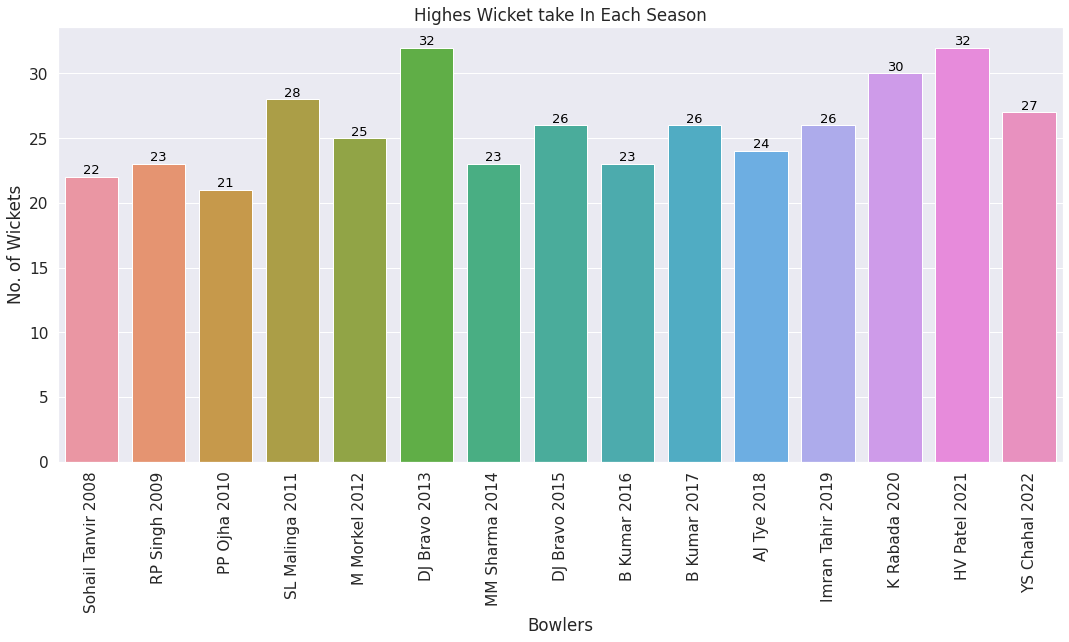

In [227]:
plt.figure(figsize=(18,8))
x=list(top_wicket.keys())
y=list(top_wicket.values())
graph = sns.barplot(x=x, y=y)
plt.title('Highes Wicket take In Each Season')
plt.xlabel('Bowlers')
plt.ylabel('No. of Wickets')
plt.xticks(rotation=90);
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', fontsize=13)

##**7.2** **Best Bowling Option in PowerPlay**


**Best Bowling Option in PowerPlay considering minmun balls bowled 30 and minimum innnings played 50**

In [228]:
best_bowling_options(match,min_balls=30, min_innings=50, phase = 'PP').head(10)

no of rows after all filters: 37


bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
52   B Kumar         145      1754.0  1745          55          1061  415   68    8       215    37     60.802292  31.890909  31.727273  6.030946  1.000000   0.694191  0.416010  1.000000  3.110201           
265  R Ashwin        113      1162.0  1054          46          521   381   39    4       99     43     49.430740  25.260870  22.913043  6.614801  0.388448   1.000000  0.900223  0.774551  3.063222           
383  Z Khan          99       1452.0  1292          52          725   342   57    3       195    23     56.114551  27.923077  24.846154  6.743034  0.619479   0.877206  0.794027  0.725035  3.015747           
339  Sandeep Sharma  102      1574.0  1374          54          745   367   58    5       199    40     54.221252  29.148148  25.444444  6.873362  0.642129   0.820700  0.761159  0.674710  2.898699           
220  MM Patel        59       762.0   654           29          375   144   21    7       99     23     57.339450  26.275862  22.551724  6.990826  0.223103   0.953184  0.920072  0.629353  2.725712           
323  SL Malinga      117      1166.0  1110          37          660   290   43    3       147    20     59.459459  31.513514  30.000000  6.302703  0.545866   0.711598  0.510898  0.895064  2.663427           
361  UT Yadav        116      1582.0  1260          53          703   304   50    7       215    38     55.793651  29.849057  23.773585  7.533333  0.594564   0.788371  0.852949  0.419870  2.655753           
331  SR Watson       89       986.0   834           34          476   198   37    4       139    18     57.074341  29.000000  24.529412  7.093525  0.337486   0.827533  0.811427  0.589697  2.566143           
97   DS Kulkarni     86       1271.0  1018          44          536   262   32    4       181    29     52.652259  28.886364  23.136364  7.491159  0.405436   0.832775  0.887955  0.436155  2.562321           
202  M Morkel        70       1077.0  906           36          545   195   44    8       146    20     60.154525  29.916667  25.166667  7.132450  0.415629   0.785252  0.776419  0.574667  2.551967

**Best Bowling Option in PowerPlay Innings 1**

In [229]:
best_bowling_options(match,innings= 1, phase = 'PP').head()

no of rows after all filters: 294


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
46   B Kumar     73       847.0  852           27          515   221   29    6       98     17     60.446009  31.370370  31.555556  5.964789  1.000000   0.820796  0.718821  0.704606  3.244222           
323  UT Yadav    72       952.0  792           34          432   207   32    3       124    24     54.545455  28.000000  23.294118  7.212121  0.837891   0.840467  0.803121  0.637183  3.118661           
73   D du Preez  1        2.0    12            3           10    2     0     0       0      0      83.333333  0.666667   4.000000   1.000000  0.013672   1.000000  1.000000  0.972973  2.986645           
183  M Morkel    44       684.0  582           26          350   129   30    2       94     11     60.137457  26.307692  22.384615  7.051546  0.677734   0.850344  0.812402  0.645862  2.986343           
342  Z Khan      51       758.0  702           22          396   188   32    1       100    11     56.410256  34.454545  31.909091  6.478632  0.767578   0.802794  0.715213  0.676831  2.962417

**Best Bowling Option in PowerPlay Innings 2**

In [230]:
 best_bowling_options(match,innings= 2, phase = 'PP').head()

no of rows after all filters: 284


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
42   B Kumar         72       907.0  893           28          546   194   39    2       117    20     61.142217  32.392857  31.892857  6.094065  1.000000   0.797055  0.668040  0.791179  3.256275           
229  R Ashwin        74       751.0  720           36          366   265   25    4       61     25     50.833333  20.861111  20.000000  6.258333  0.669118   0.890268  0.820513  0.783712  3.163611           
216  P Kumar         59       838.0  774           24          463   189   36    6       94     21     59.819121  34.916667  32.250000  6.496124  0.847426   0.776655  0.663462  0.772903  3.060447           
291  Sandeep Sharma  53       842.0  690           30          382   173   34    3       103    25     55.362319  28.066667  23.000000  7.321739  0.698529   0.832025  0.782051  0.735375  3.047981           
329  Z Khan          48       694.0  590           30          329   154   25    2       95     12     55.762712  23.133333  19.666667  7.057627  0.601103   0.871901  0.824786  0.747381  3.045171

##**7.3** **Best Bowling Options in Death Overs**

**Best Bowling Option in Death Over considering minmun balls bowled 30 and minimum innnings played 50**

In [231]:
best_bowling_options(match,min_balls=30, min_innings=50, phase = 'DO').head(10)

no of rows after all filters: 26


bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
308  SL Malinga  109      1196.0  917           90          364   392   84    3       81     41     39.694656  13.288889  10.188889  7.825518  0.860068   1.000000  0.806416  1.000000  3.666484           
85   DJ Bravo    125      1810.0  1115          102         405   422   130   4       129    88     36.322870  17.745098  10.931373  9.739910  1.000000   0.743569  0.710274  0.474478  2.928320           
315  SP Narine   90       924.0   703           55          279   280   54    2       52     50     39.687055  16.800000  12.781818  7.886202  0.569966   0.797954  0.470665  0.983342  2.821927           
152  K Rabada    55       671.0   426           49          185   142   35    1       56     33     43.427230  13.693878  8.693878   9.450704  0.249147   0.976695  1.000000  0.553868  2.779710           
7    A Nehra     60       620.0   419           46          150   173   36    1       44     30     35.799523  13.478261  9.108696   8.878282  0.129693   0.989103  0.946286  0.711004  2.776086           
67   CH Morris   65       836.0   586           55          207   249   56    3       61     33     35.324232  15.200000  10.654545  8.559727  0.324232   0.890026  0.746119  0.798451  2.758828           
50   B Kumar     118      1533.0  999           77          357   401   97    4       130    59     35.735736  19.909091  12.974026  9.207207  0.836177   0.619042  0.445777  0.620711  2.521707           
138  JJ Bumrah   109      1470.0  1026          70          373   424   104   4       112    55     36.354776  21.000000  14.657143  8.596491  0.890785   0.556266  0.227835  0.788359  2.463245           
101  DW Steyn    76       780.0   532           43          209   207   44    1       68     30     39.285714  18.139535  12.372093  8.796992  0.331058   0.720871  0.523719  0.733319  2.308967           
271  RP Singh    62       729.0   473           43          167   201   40    3       61     28     35.306554  16.953488  11.000000  9.247357  0.187713   0.789122  0.701387  0.609689  2.287911

**Best Bowling Options Innings 1 in Death Overs**

In [232]:
best_bowling_options(match,innings= 1, phase = 'DO').head()

no of rows after all filters: 255


bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR        Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
265  SL Malinga  55       700.0   516           53          198   223   50    2       46     25     38.372093  13.207547  9.735849   8.139535   0.883929   0.901740  0.869640  0.764565  3.419873           
38   B Kumar     65       938.0   578           49          211   219   65    3       81     36     36.505190  19.142857  11.795918  9.737024   0.941964   0.840074  0.822820  0.665751  3.270610           
68   DJ Bravo    67       1073.0  633           48          224   244   74    2       73     56     35.387046  22.354167  13.187500  10.170616  1.000000   0.806710  0.791193  0.638931  3.236834           
270  SP Narine   59       664.0   478           35          184   192   42    1       32     40     38.493724  18.971429  13.657143  8.334728   0.821429   0.841855  0.780519  0.752491  3.196294           
116  JJ Bumrah   56       821.0   558           36          196   232   64    2       60     31     35.125448  22.805556  15.500000  8.827957   0.875000   0.802020  0.738636  0.721982  3.137639

**Best Bowling Options Innings 2 in Death Overs**

In [233]:
best_bowling_options(match,innings= 2, phase = 'DO').head()

no of rows after all filters: 231


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
75   DJ Bravo    58       737.0  482           54          181   178   56    2       56     32     37.551867  13.648148  8.925926   9.174274  1.000000   0.917517  0.923040  0.701354  3.541911           
262  SL Malinga  54       496.0  401           37          166   169   34    1       35     16     41.396509  13.405405  10.837838  7.421446  0.916667   0.919200  0.898210  0.793608  3.527685           
120  JJ Bumrah   53       649.0  468           34          177   192   40    2       52     24     37.820513  19.088235  13.764706  8.320513  0.977778   0.879804  0.860199  0.746289  3.464069           
45   B Kumar     53       595.0  421           28          146   182   32    1       49     23     34.679335  21.250000  15.035714  8.479810  0.805556   0.864818  0.843692  0.737905  3.251970           
89   DW Steyn    42       399.0  286           24          121   110   16    0       35     17     42.307692  16.625000  11.916667  8.370629  0.666667   0.896880  0.884199  0.743651  3.191397

**Considering the RCB TEAM death over Hitter's 
Dinesh Karthik & GJ Maxwell as best Death Over  Hitter's as with the highest strike rate in the death overs in IPL 2022.
Best bowlers against these both Batsmen are listed below.**


In [234]:
best_bowling_options(match, min_balls = 12,phase = 'DO', striker=['KD Karthik', 'GJ Maxwell']).head(10)

no of rows after all filters: 20


bowler  innings  runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR        Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
37   DW Steyn        4        10.0  13            2           6     6     0     0       1      0      46.153846  5.000000   6.500000   4.615385   0.363636   1.000000  0.946154  1.000000  3.309790           
32   DJ Bravo        8        50.0  24            4           12    3     4     0       6      2      50.000000  12.500000  6.000000   12.500000  0.909091   0.921053  0.969231  0.451872  3.251246           
52   JJ Bumrah       8        69.0  37            3           13    14    3     0       7      3      35.135135  23.000000  12.333333  11.189189  1.000000   0.810526  0.676923  0.542998  3.030447           
17   B Kumar         8        47.0  29            2           11    11    3     0       4      2      37.931034  23.500000  14.500000  9.724138   0.818182   0.805263  0.576923  0.644846  2.845214           
113  SP Narine       6        41.0  23            2           9     6     3     0       4      2      39.130435  20.500000  11.500000  10.695652  0.636364   0.836842  0.715385  0.577308  2.765898           
112  SN Thakur       5        13.0  12            1           5     5     1     0       0      1      41.666667  13.000000  12.000000  6.500000   0.272727   0.915789  0.692308  0.868984  2.749808           
8    AB Dinda        5        25.0  13            2           6     5     0     0       3      1      46.153846  12.500000  6.500000   11.538462  0.363636   0.921053  0.946154  0.518717  2.749559           
26   CH Morris       6        34.0  16            3           4     4     3     0       3      2      25.000000  11.333333  5.333333   12.750000  0.181818   0.933333  1.000000  0.434492  2.549643           
15   Arshdeep Singh  5        24.0  16            1           8     4     3     0       3      0      50.000000  24.000000  16.000000  9.000000   0.545455   0.800000  0.507692  0.695187  2.548334           
79   Mohammed Shami  5        37.0  18            2           5     5     2     0       4      2      27.777778  18.500000  9.000000   12.333333  0.272727   0.857895  0.830769  0.463458  2.424849

**MS Dhoni is the all Season top noch IPL Death over Hitter- 
Best bowlers against MS Dhoni**

In [235]:
best_bowling_options(match, min_balls = 12,phase = 'DO', striker=['MS Dhoni']).head()

no of rows after all filters: 40


bowler  innings  runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR        Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
52   JJ Bumrah       10       47.0  38            3           17    17    5     0       1      2      44.736842  15.666667  12.666667  7.421053   1.0000     0.926740  0.842105  0.767269  3.536114           
143  Z Khan          10       60.0  34            6           14    7     6     0       4      4      41.176471  10.000000  5.666667   10.588235  0.8125     0.989011  1.000000  0.559640  3.361151           
42   HV Patel        4        9.0   12            1           5     5     2     0       0      0      41.666667  9.000000   12.000000  4.500000   0.2500     1.000000  0.857143  0.958763  3.065906           
80   MJ McClenaghan  5        22.0  15            1           9     7     0     0       0      2      60.000000  22.000000  15.000000  8.800000   0.5000     0.857143  0.789474  0.676870  2.823487           
107  RA Jadeja       4        24.0  13            1           9     2     1     0       0      3      69.230769  24.000000  13.000000  11.076923  0.5000     0.835165  0.834586  0.527603  2.697355

In [236]:
best_bowling_options(match, min_balls = 12, batting_team	 = 'Gujarat Titans',phase = 'DO').head()

no of rows after all filters: 35


bowler  innings  runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%   Avg     SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
6   B Kumar            7        76.0  62            8           22    28    8     1       5      1      35.483871  9.5   7.75   7.354839  1.000000   0.975248  0.963542  0.726932  3.665721           
45  Mustafizur Rahman  3        34.0  36            4           14    17    5     0       0      1      38.888889  8.5   9.00   5.666667  0.619048   0.985149  0.937500  0.864341  3.406037           
27  K Rabada           3        39.0  30            5           16    11    2     0       5      0      53.333333  7.8   6.00   7.800000  0.714286   0.992079  1.000000  0.690698  3.397063           
33  M Ashwin           2        8.0   12            1           7     5     1     0       0      0      58.333333  8.0   12.00  4.000000  0.285714   0.990099  0.875000  1.000000  3.150813           
67  Sandeep Sharma     3        40.0  30            4           10    10    5     0       5      0      33.333333  10.0  7.50   8.000000  0.428571   0.970297  0.968750  0.674419  3.042037

In [237]:
best_bowling_options(match, min_balls = 12,venue ='Narendra Modi Stadium, Ahmedabad').head()

no of rows after all filters: 37


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
19  M Prasidh Krishna  4        128.0  93            7           58    14    8     0       13     6      62.365591  18.285714  13.285714  8.258065  1.000000   0.866229  0.889610  0.482830  3.238670           
10  HH Pandya          1        17.0   24            3           14    7     1     0       2      0      58.333333  5.666667   8.000000   4.250000  0.214286   1.000000  0.969697  1.000000  3.183983           
12  Harpreet Brar      2        38.0   42            4           19    14    7     0       1      1      45.238095  9.500000   10.500000  5.428571  0.303571   0.959364  0.931818  0.847926  3.042680           
35  TA Boult           2        42.0   48            2           32    9     3     1       4      1      66.666667  21.000000  24.000000  5.250000  0.535714   0.837456  0.727273  0.870968  2.971411           
25  PJ Cummins         2        55.0   42            5           25    8     1     0       5      4      59.523810  11.000000  8.400000   7.857143  0.410714   0.943463  0.963636  0.534562  2.852376

In [238]:
best_bowling_options(match, min_balls = 12,phase = 'DO', striker= ['HH Pandya']).head()

no of rows after all filters: 10


bowler  innings  runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%   Avg    SR        Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
28  JC Archer       6        33.0  22            2           8     11    1     0       3      1      36.363636  16.5  11.0  9.000000   0.625      1.000000  1.000000  1.000000  3.625000           
14  CH Morris       4        33.0  20            1           5     11    0     0       1      3      25.000000  33.0  20.0  9.900000   0.250      0.802395  0.608696  0.864706  2.525797           
19  DJ Bravo        8        54.0  34            1           11    14    6     0       2      3      32.352941  54.0  34.0  9.529412   1.000      0.550898  0.000000  0.920415  2.471313           
35  K Rabada        7        50.0  25            1           10    10    1     1       2      4      40.000000  50.0  25.0  12.000000  0.875      0.598802  0.391304  0.549020  2.414126           
48  Mohammed Shami  5        43.0  21            1           7     5     2     0       4      3      33.333333  43.0  21.0  12.285714  0.500      0.682635  0.565217  0.506069  2.253921

In [239]:
best_bowling_options(match, min_balls = 12,phase = 'DO', striker= ['AD Russell']).head()

no of rows after all filters: 8


bowler  innings  runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR        Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
41  Mohammed Siraj  4        22.0  13            1           12    2     0     0       1      2      92.307692  22.000000  13.000000  10.153846  0.9        0.850909  0.633803  1.000000  3.384712           
15  CH Morris       3        25.0  13            3           7     2     1     0       2      2      53.846154  8.333333   4.333333   11.538462  0.4        1.000000  1.000000  0.857567  3.257567           
27  JJ Bumrah       5        44.0  24            1           10    8     1     0       5      2      41.666667  44.000000  24.000000  11.000000  0.7        0.610909  0.169014  0.912957  2.392881           
67  YS Chahal       3        27.0  12            1           3     3     1     0       4      1      25.000000  27.000000  12.000000  13.500000  0.0        0.796364  0.676056  0.655786  2.128206           
10  B Kumar         4        66.0  28            1           13    5     2     0       6      5      46.428571  66.000000  28.000000  14.142857  1.0        0.370909  0.000000  0.589657  1.960566

#**8.** **Best allrounders**

In [240]:
def best_allrounder_options(match, min_balls_bat = 150, min_balls_bowl = 250, bowling_team = None, batting_team = None, venue = None, innings = None, phase = None, bowlers = None, batters = None, worst = None ):
  
  # innings
  if innings != None:
    match = match[match.innings == innings]
  
  # phase
  if phase != None:
    match = match[match.phase == phase]

  # bowling team
  if bowling_team != None:
    match = match[match.bowling_team == bowling_team]

  # batting team
  if batting_team != None:
    match = match[match.batting_team == batting_team]

  # venue
  if venue != None:
    match = match[match.venue == venue]

  # bowlers - list
  if bowlers != None:
    match = match[match.bowler.isin(bowlers)]

  # batters - list
  if batters != None:
    match = match[match.striker.isin(batters)]
  
  # calculation batting
  match4 = playerStatistics(match)
  match4= match4[match4.balls >= min_balls_bat]

  match4['AVG_mnmx'] = minmax(match4.AVG)
  match4['sr_mnmx'] = minmax(match4.SR)
  match4['bpd_mnmx'] = minmax(match4.BPD)
  match4['bpb_mnmx'] = minmax_reverse(match4.BPB)

  match4['total_bat_score'] = match4['AVG_mnmx'] + match4['sr_mnmx'] + match4['bpd_mnmx']

  # calculation bowling
  match5 = playerStatistics_bowler(match)
  match5 = match5[match5.balls_bowled >= min_balls_bowl]


  # change inf values to some high number
  match5['Avg'].replace([np.inf, -np.inf], 100, inplace=True)
  match5['SR'].replace([np.inf, -np.inf], 100, inplace=True)

  match5['Dot%_mnmx'] = bowlers_minmax(match5.dots)
  match5['Avg_mnmx'] = bowlers_minmax_reverse(match5.Avg)
  match5['sr_mnmx'] = bowlers_minmax_reverse(match5.SR)
  match5['Eco_mnmx'] = bowlers_minmax_reverse(match5.Eco)

  match5['total_bowl_score'] = match5['Dot%_mnmx'] + match5['Avg_mnmx'] + match5['sr_mnmx'] + match5['Eco_mnmx']


  # merge bat, bowl matchs
  match4 = match4.rename(columns = {'striker':'player'})
  match5 = match5.rename(columns = {'bowler':'player'})

  match6 = match4[['player', 'total_bat_score']].merge(match5[['player', 'total_bowl_score']], on = 'player', how = 'outer')

  # output = sum(bat_score) + sum(bowl_scores)
  match6['final_score'] = match6['total_bat_score'] + match6['total_bowl_score']
  

  if worst != None:
    match6.sort_values('final_score', ascending = True, inplace = True)
  else:
    match6.sort_values('final_score', ascending = False, inplace = True)

  return match6


Considering the Batting & bowling scores and getting the best scores we can consider best all-Rounder. 

**Best Allrounders of IPL (2008-2022)**

In [241]:
All_rounder = best_allrounder_options(match )
All_rounder.head(20)

min max 7.590909090909091 48.01234567901235
min max 88.47352024922118 177.8846153846154
min max 7.2727272727272725 35.24691358024691


player  total_bat_score  total_bowl_score  final_score
176  SP Narine        1.076272         3.566167          4.642439   
179  SR Watson        1.675215         2.867520          4.542735   
8    AD Russell       1.914008         2.500310          4.414319   
148  RA Jadeja        1.394277         2.999792          4.394069   
75   JP Duminy        2.080764         2.304651          4.385415   
40   DJ Bravo         1.194928         3.108647          4.303574   
63   Harbhajan Singh  0.872440         3.381113          4.253553   
31   CH Morris        1.353523         2.880976          4.234500   
30   CH Gayle         2.164591         2.068590          4.233181   
2    A Symonds        1.900607         2.299880          4.200487   
158  Rashid Khan      0.801621         3.381841          4.183462   
205  YK Pathan        1.610610         2.503440          4.114050   
67   JA Morkel        1.366155         2.727493          4.093647   
138  R Ashwin         0.621461         3.441905          4.063366   
60   HH Pandya        1.692018         2.321450          4.013468   
113  MM Ali           1.329649         2.680064          4.009713   
80   KA Pollard       1.615468         2.348186          3.963655   
71   JH Kallis        1.425183         2.527250          3.952433   
15   AR Patel         1.013297         2.930271          3.943568   
64   IK Pathan        1.079037         2.782646          3.861683

In [242]:
fig = px.scatter(All_rounder.head(30), x="total_bat_score", y="total_bowl_score", color="player",labels={
                     "total_bat_score": "Batting Score",
                     "total_bowl_score": " Bowling Score" },  title ="Batting vs Bowling scores of All-Rounders")
fig.show()

In [243]:
fig = px.bar(All_rounder.head(20), x="player", y="final_score", color="player",text_auto='final_score',labels={
                     "player": "player",
                     "final_score": "Bat + Bowl Score" },  title ="Top 20 All-Rounders")
fig.show()

In [244]:
phase_wise = match.groupby(['striker','phase'])['runs_off_bat'].sum().reset_index().rename(columns = {'runs_off_bat':'runs_scored'})
phase_wise = phase_wise.sort_values("runs_scored", ascending = False)
phase_wise.head(10)

striker phase  runs_scored
1269  V Kohli         MO    3508       
1097  SK Raina        MO    3312       
1035  S Dhawan        PP    3157       
965   RG Sharma       MO    3102       
62    AB de Villiers  MO    3019       
290   DA Warner       PP    2892       
567   KD Karthik      MO    2698       
1034  S Dhawan        MO    2650       
137   AT Rayudu       MO    2602       
289   DA Warner       MO    2590

In [245]:
fig = px.bar(phase_wise.head(100), x="striker", y="runs_scored", color="phase", text_auto='runs_scored', labels={
                     "striker": "Batsmen",
                     "runs_scored": "Runs Scored" },  title ="Phase- wise Runs Scored")
fig.show()

#**9.**  **Considering Venue M.Chinnaswamy Stadium, best Batsman and Bowlers at this venue.**  


In [246]:
best_batting_options(match,venue = 'M.Chinnaswamy Stadium', min_innings = 10).head(10)

no of rows after all filters: 26
min max 16.210526315789473 92.6
min max 109.03010033444815 180.859375
min max 13.0 51.2


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
142  MS Dhoni        10       463   256    5           88    92    18    1       35     32     180.859375  92.600000  51.200000  3.820896  1.000000  1.000000  1.000000  1.000000  3.000000   
7    AB de Villiers  58       1960  1216   45          412   495   64    3       155    118    161.184211  43.555556  27.022222  4.454212  0.357969  0.726084  0.367074  0.823731  1.451127   
39   CH Gayle        44       1561  976    38          496   273   21    0       121    127    159.938525  41.078947  25.684211  3.935484  0.325548  0.708742  0.332047  0.968107  1.366337   
23   AT Rayudu       10       380   297    8           117   130   12    0       28     19     127.946128  47.500000  37.125000  6.319149  0.409605  0.263347  0.631545  0.304669  1.304496   
96   KA Pollard      10       230   154    6           67    67    5     0       16     14     149.350649  38.333333  25.666667  5.133333  0.289605  0.561339  0.331588  0.634713  1.182532   
166  Q de Kock       10       384   262    10          100   94    15    0       44     14     146.564885  38.400000  26.200000  4.517241  0.290478  0.522556  0.345550  0.806188  1.158583   
103  KL Rahul        12       344   243    9           93    95    17    1       32     14     141.563786  38.222222  27.000000  5.282609  0.288151  0.452931  0.366492  0.593166  1.107574   
237  V Kohli         72       2346  1689   64          628   681   108   5       213    97     138.898757  36.656250  26.390625  5.448387  0.267651  0.415828  0.350540  0.547025  1.034019   
31   BB McCullum     11       323   212    10          97    60    13    1       30     19     152.358491  32.300000  21.200000  4.326531  0.210624  0.603214  0.214660  0.859268  1.028497   
132  MK Pandey       12       352   275    9           121   102   14    1       34     13     128.000000  39.111111  30.555556  5.851064  0.299787  0.264097  0.459570  0.434950  1.023454

In [247]:
best_bowling_options(match,venue ='M.Chinnaswamy Stadium',min_innings = 10).head(10)

no of rows after all filters: 19


bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
229  YS Chahal       40       1093.0  847           51          351   354   46    2       71     53     41.440378  21.431373  16.607843  7.742621  1.000000   0.939322  0.950970  0.600782  3.491074           
176  S Aravind       19       437.0   367           25          186   126   14    0       50     10     50.681199  17.480000  14.680000  7.144414  0.431034   1.000000  1.000000  0.725028  3.156063           
231  Z Khan          25       727.0   553           28          261   171   34    1       88     18     47.197107  25.964286  19.750000  7.887884  0.689655   0.869713  0.871058  0.570611  3.001037           
168  R Vinay Kumar   24       669.0   505           27          209   187   31    0       62     26     41.386139  24.777778  18.703704  7.948515  0.510345   0.887933  0.897668  0.558018  2.853964           
60   DL Vettori      10       227.0   234           10          88    112   16    0       16     3      37.606838  22.700000  23.400000  5.820513  0.093103   0.919840  0.778230  1.000000  2.791174           
123  M Muralitharan  11       302.0   264           13          106   115   15    0       23     10     40.151515  23.230769  20.307692  6.863636  0.155172   0.911690  0.856875  0.783345  2.707082           
202  SR Watson       17       477.0   336           21          164   111   21    0       49     17     48.809524  22.714286  16.000000  8.517857  0.355172   0.919621  0.966429  0.439767  2.680989           
219  UT Yadav        21       656.0   448           25          205   149   18    1       66     29     45.758929  26.240000  17.920000  8.785714  0.496552   0.865479  0.917599  0.384133  2.663763           
172  RP Singh        12       340.0   258           15          119   86    15    0       37     11     46.124031  22.666667  17.200000  7.906977  0.200000   0.920352  0.935910  0.566645  2.622908           
150  P Kumar         18       565.0   392           17          202   107   16    1       57     28     51.530612  33.235294  23.058824  8.647959  0.486207   0.758058  0.786907  0.412745  2.443916

In [248]:
Teams_Runs_scored = match[match.venue == 'M.Chinnaswamy Stadium'].groupby(['batting_team'])['runs_off_bat'].sum().sort_values().reset_index().rename(columns = {'batting_team':'Teams','runs_off_bat':'Runs_scored'})
Teams_Runs_scored

Teams  Runs_scored
0   Kochi Tuskers Kerala         115        
1   Gujarat Titans               366        
2   Rising Pune Supergiant       782        
3   Rajasthan Royals             952        
4   Chennai Super Kings          1348       
5   Delhi Capitals               1559       
6   Mumbai Indians               1752       
7   Punjab Kings                 1765       
8   Sunrisers Hyderabad          1813       
9   Kolkata Knight Riders        1868       
10  Royal Challengers Bangalore  11689

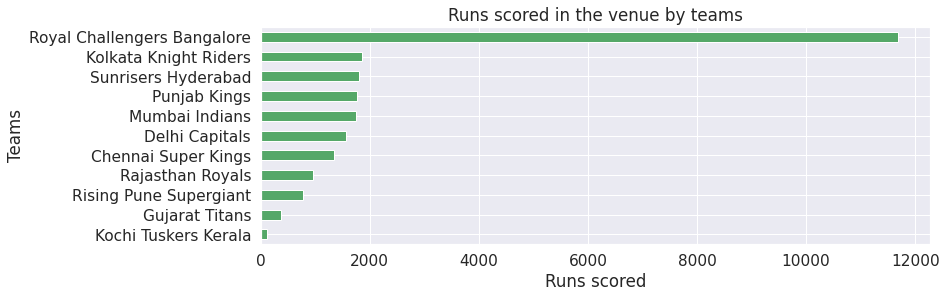

In [249]:
plt.figure(figsize = (12, 4))
match[match.venue == 'M.Chinnaswamy Stadium'].groupby(['batting_team'])['runs_off_bat'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('Runs scored in the venue by teams')
plt.xlabel('Runs scored')
plt.ylabel('Teams')
plt.show()


In [250]:
match.head(1)

match_id  season  start_date                  venue  innings  ball                 batting_team           bowling_team     striker non_striker      bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty wicket_type player_dismissed  other_wicket_type  other_player_dismissed               bowl_style bowling_style           bat_style batting_style  wides_cnt_balls  noballs_cnt_balls  noballs_cnt_balls_bowler  byes_cnt_balls  legbyes_cnt_balls  legal_ball  legal_ball_bowler  over_no  ball_no phase  isDot  isOne  isTwo  isThree  isFour  isSix  total_runs  isBowlerWk  isOut
0  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        6.8   Royal Challengers Bangalore  Kolkata Knight Riders  MV Boucher  CL White    AB Agarkar  4             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  6        8        MO    0      0      0      0        1       0      4.0         0           0

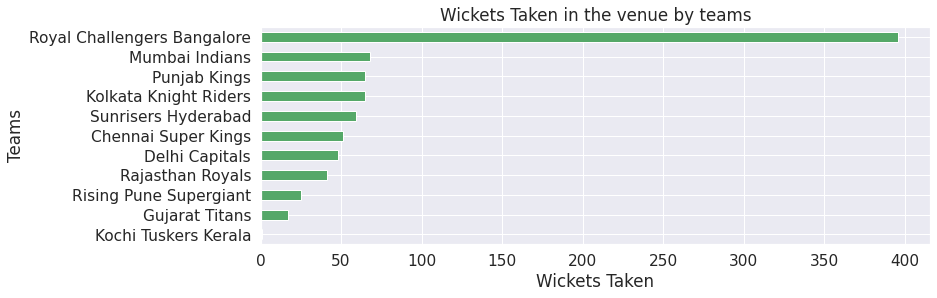

In [251]:
plt.figure(figsize = (12, 4))
match[match.venue == 'M.Chinnaswamy Stadium'].groupby(['bowling_team'])['isBowlerWk'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('Wickets Taken in the venue by teams')
plt.xlabel('Wickets Taken')
plt.ylabel('Teams')
plt.show()

##**9.1** **Considering Mumbai Indians as Opposition team, best Batsman and Bowlers against Mumbai Indians**

In [252]:
best_batting_options(match, min_balls = 150, min_innings = 20, bowling_team = 'Mumbai Indians').head(10)

no of rows after all filters: 16
min max 18.235294117647058 43.611111111111114
min max 115.30864197530863 148.11320754716982
min max 15.352941176470589 31.41176470588235


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
14   AB de Villiers  24       785   530    18          182   221   29    2       71     36     148.113208  43.611111  29.444444  4.953271  1.000000  1.000000  0.877493  1.000000  2.877493   
71   DA Warner       20       666   482    16          194   179   39    1       64     25     138.174274  41.625000  30.125000  5.415730  0.921732  0.697026  0.919872  0.843543  2.538630   
60   CH Gayle        20       708   534    17          281   167   13    1       62     44     132.584270  41.647059  31.411765  5.037736  0.922601  0.526623  1.000000  0.971424  2.449224   
265  S Dhawan        27       871   682    22          273   258   46    3       95     22     127.712610  39.590909  31.000000  5.829060  0.841573  0.378117  0.974359  0.703707  2.194050   
186  MK Pandey       22       709   548    19          192   244   42    1       57     25     129.379562  37.315789  28.842105  6.682927  0.751916  0.428932  0.839985  0.414830  2.020833   
196  MS Dhoni        34       746   576    21          242   230   42    0       57     34     129.513889  35.523810  27.428571  6.329670  0.681299  0.433027  0.751962  0.534343  1.866288   
336  YK Pathan       22       472   332    15          120   148   12    0       45     20     142.168675  31.466667  22.133333  5.107692  0.521417  0.818789  0.422222  0.947757  1.762428   
280  SK Raina        34       824   591    28          223   247   40    5       68     35     139.424704  29.428571  21.107143  5.737864  0.441100  0.735143  0.358320  0.734560  1.534564   
297  SV Samson       20       537   379    19          133   162   27    3       48     20     141.688654  28.263158  19.947368  5.573529  0.395174  0.804157  0.286100  0.790157  1.485431   
26   AM Rahane       22       625   516    20          214   201   30    4       70     12     121.124031  31.250000  25.800000  6.292683  0.512878  0.177274  0.650549  0.546856  1.340702

In [253]:
best_bowling_options(match,min_balls = 150, min_innings = 15,batting_team	 = 'Mumbai Indians').head(10)

no of rows after all filters: 15


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
48   B Kumar    16       354.0  330           19          179   100   25    0       33     9      54.242424  18.631579  17.368421  6.436364  0.539773   1.000000  0.792475  1.000000  3.332248           
79   DJ Bravo   22       616.0  464           33          182   201   32    1       54     18     39.224138  18.666667  14.060606  7.965517  0.556818   0.998396  1.000000  0.479050  3.034264           
266  SP Narine  20       523.0  475           23          206   194   21    1       42     18     43.368421  22.739130  20.652174  6.606316  0.693182   0.812170  0.586461  0.942101  3.033913           
309  YS Chahal  17       525.0  396           25          158   162   23    1       26     33     39.898990  21.000000  15.840000  7.954545  0.420455   0.891697  0.888365  0.482788  2.683304           
218  R Ashwin   31       723.0  642           24          260   292   30    3       36     34     40.498442  30.125000  26.750000  6.757009  1.000000   0.474428  0.203897  0.890763  2.569089           
111  IK Pathan  15       360.0  307           15          158   97    15    0       37     12     51.465798  24.000000  20.466667  7.035831  0.420455   0.754513  0.598099  0.795774  2.568840           
6    A Mishra   22       637.0  504           25          193   218   35    2       36     31     38.293651  25.480000  20.160000  7.583333  0.619318   0.686835  0.617338  0.609252  2.532744           
211  PP Chawla  21       594.0  433           25          173   162   29    0       47     29     39.953811  23.760000  17.320000  8.230947  0.505682   0.765487  0.795513  0.388624  2.455306           
181  MM Sharma  16       504.0  343           23          151   108   17    0       55     22     44.023324  21.913043  14.913043  8.816327  0.380682   0.849945  0.946520  0.189198  2.366345           
204  P Kumar    16       393.0  321           13          178   88    20    0       44     10     55.451713  30.230769  24.692308  7.345794  0.534091   0.469592  0.332992  0.690176  2.026851

##**9.2**  **Considering Chennai Super Kings as Opposition team, best Batsman and Bowlers against Chennai Super Kings**

In [254]:
best_batting_options(match,min_balls = 150, min_innings = 20,  bowling_team = 'Chennai Super Kings').head(10)

no of rows after all filters: 7
min max 23.130434782608695 44.73913043478261
min max 125.35211267605635 171.976401179941
min max 15.391304347826088 34.21739130434783


striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB  AVG_mnmx   sr_mnmx  bpd_mnmx  bpb_mnmx  total_score
253  S Dhawan        28       1029  787    23          296   340   49    3       114    21     130.749682  44.739130  34.217391  5.829630  1.000000  0.115767  1.000000  0.414332  2.115767   
129  KA Pollard      23       583   339    16          135   118   15    1       42     44     171.976401  36.437500  21.187500  3.941860  0.615820  1.000000  0.307881  1.000000  1.923701   
306  V Kohli         29       979   781    25          301   328   63    5       72     37     125.352113  39.160000  31.240000  7.165138  0.741811  0.000000  0.841848  0.000000  1.583658   
251  RV Uthappa      22       547   415    19          176   147   29    2       54     20     131.807229  28.789474  21.842105  5.608108  0.261887  0.138450  0.342652  0.483058  0.742989   
131  KD Karthik      28       647   479    23          191   173   38    2       71     18     135.073069  28.130435  20.826087  5.382022  0.231388  0.208496  0.288684  0.553199  0.728567   
235  RG Sharma       31       770   614    28          236   261   37    1       69     26     125.407166  27.500000  21.928571  6.463158  0.202213  0.001181  0.347245  0.217784  0.550639   
10   AB de Villiers  25       532   354    23          126   125   40    3       42     25     150.282486  23.130435  15.391304  5.283582  0.000000  0.534708  0.000000  0.583740  0.534708

In [255]:
best_bowling_options(match,min_balls = 150, min_innings = 15, batting_team	 = 'Chennai Super Kings').head(10)

no of rows after all filters: 13


bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
247  SL Malinga       21       590.0  489           31          244   180   24    3       53     16     49.897751  19.032258  15.774194  7.239264  1.000000   0.877487  0.959192  0.758903  3.595582           
193  PP Ojha          15       339.0  314           21          126   144   23    1       8      18     40.127389  16.142857  14.952381  6.477707  0.233766   1.000000  1.000000  0.974122  3.207889           
91   Harbhajan Singh  21       505.0  462           24          192   209   28    0       25     21     41.558442  21.041667  19.250000  6.558442  0.662338   0.792286  0.786597  0.951306  3.192527           
253  SP Narine        17       430.0  404           20          156   185   32    1       24     12     38.613861  21.500000  20.200000  6.386139  0.428571   0.772852  0.739424  1.000000  2.940848           
278  UT Yadav         15       382.0  306           14          156   94    16    1       44     10     50.980392  27.285714  21.857143  7.490196  0.428571   0.527533  0.657137  0.687989  2.301230           
192  PP Chawla        20       556.0  399           19          148   150   31    0       48     24     37.092732  29.263158  21.000000  8.360902  0.376623   0.443688  0.699699  0.441924  1.961934           
3    A Mishra         16       401.0  339           13          117   170   20    1       20     17     34.513274  30.846154  26.076923  7.097345  0.175325   0.376567  0.447599  0.799010  1.798501           
186  P Kumar          15       458.0  342           14          153   113   21    3       37     23     44.736842  32.714286  24.428571  8.035088  0.409091   0.297357  0.529450  0.534000  1.769898           
129  KA Pollard       16       386.0  265           14          94    133   15    0       31     13     35.471698  27.571429  18.928571  8.739623  0.025974   0.515419  0.802558  0.334896  1.678846           
40   B Kumar          17       437.0  386           11          195   125   25    2       34     17     50.518135  39.727273  35.090909  6.792746  0.681818   0.000000  0.000000  0.885091  1.566909

#**10.**  **Strength  Weakness of Player:**


##**10.1** **Batsman strength  & Weakness**

**lets Consider Two Top IPL batsman  based on the batting average & list down there Strenght & Weakness :** 

**Condition The Player must have played minimum 20 Innings.**

In [256]:
Bat_stat[Bat_stat.innings >= 20].sort_values("AVG", ascending = False).head(10)

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB   sr_mnmx  AVG_mnmx  bpd_mnmx  bpb_mnmx
248  KL Rahul        99       3889  2855   81          1040  1200  191   5       327    164    136.217163  48.012346  35.246914  5.814664  0.648306  0.862497  0.796440  0.943357
124  DA Warner       162      5881  4180   140         1633  1513  345   23      577    216    140.693780  42.007143  29.857143  5.271122  0.669612  0.754619  0.671096  0.949752
270  LMP Simmons     29       1079  852    27          402   269   52    2       109    44     126.643192  39.962963  31.555556  5.568627  0.602740  0.717898  0.710594  0.946251
463  SE Marsh        69       2477  1866   62          734   724   99    6       266    78     132.743837  39.951613  30.096774  5.424419  0.631775  0.717694  0.676669  0.947948
207  JC Buttler      81       2831  1891   71          775   628   132   4       278    135    149.709149  39.873239  26.633803  4.578692  0.712519  0.716286  0.596135  0.957898
224  JP Duminy       75       2029  1636   51          562   781   126   6       126    79     124.022005  39.784314  32.078431  7.980488  0.590265  0.714688  0.722754  0.917877
103  CH Gayle        141      4965  3333   125         1634  1012  91    3       405    357    148.964896  39.720000  26.664000  4.374016  0.708977  0.713533  0.596837  0.960306
25   AB de Villiers  170      5162  3403   130         1113  1417  268   17      413    251    151.689686  39.707692  26.176923  5.125000  0.721946  0.713312  0.585510  0.951471
321  MS Dhoni        205      4978  3682   127         1370  1509  333   15      346    229    135.198262  39.196850  28.992126  6.403478  0.643457  0.704135  0.650980  0.936430
301  MEK Hussey      58       1977  1612   51          643   648   96    11      198    52     122.642680  38.764706  31.607843  6.448000  0.583700  0.696372  0.711810  0.935906

In [257]:
match.head(1)

match_id  season  start_date                  venue  innings  ball                 batting_team           bowling_team     striker non_striker      bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty wicket_type player_dismissed  other_wicket_type  other_player_dismissed               bowl_style bowling_style           bat_style batting_style  wides_cnt_balls  noballs_cnt_balls  noballs_cnt_balls_bowler  byes_cnt_balls  legbyes_cnt_balls  legal_ball  legal_ball_bowler  over_no  ball_no phase  isDot  isOne  isTwo  isThree  isFour  isSix  total_runs  isBowlerWk  isOut
0  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        6.8   Royal Challengers Bangalore  Kolkata Knight Riders  MV Boucher  CL White    AB Agarkar  4             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  6        8        MO    0      0      0      0        1       0      4.0         0           0

**KL Rahul	& David Warner**

In [258]:
def best_batting_Scores(match, min_balls = 10, striker = None,  bowling_style = None, bowl_style= None,  season = None, bowling_team = None, venue = None, innings = None, phase = None, bowlers = None, worst = None, sorter = None ):
  
  # season
  if season != None:
    match = match[match.season == season]

  # season
  if striker != None:
    match = match[match.striker == striker]    

  # innings
  if innings != None:
    match = match[match.innings == innings]
  
  # phase
  if phase != None:
    match = match[match.phase == phase]

  # bowl type
  if bowling_style != None:
    match = match[match.bowling_style == bowling_style]

   # bowl style
  if bowl_style != None:
    match = match[match.bowl_style == bowl_style] 

  # bowling team
  if bowling_team != None:
    match = match[match.bowling_team == bowling_team]

  # venue
  if venue != None:
    match = match[match.venue == venue]

  # bowlers - list
  if bowlers != None:
    match = match[match.bowler.isin(bowlers)]
  
  # calculation
  match = playerStatistics(match)
  match = match[match.balls >= min_balls]

  # count of rows
  print("no of rows after all filters:", len(match))
  if len(match) == 0:
    print("No players found with these filters")
    return None
  elif len(match) == 1:
    print("only one player found with these filters")
    # preview df
    print(match.head())
    return None

  match['AVG_mnmx'] = minmax(match.AVG)
  match['sr_mnmx'] = minmax(match.SR)
  match['bpd_mnmx'] = minmax(match.BPD)
  match['bpb_mnmx'] = minmax_reverse(match.BPB)

  match['total_score'] = match['AVG_mnmx'] + match['sr_mnmx'] + match['bpd_mnmx']

  if sorter != None:
    match.sort_values(sorter, ascending = False, inplace = True)
    return match

  if worst != None:
    match.sort_values('total_score', ascending = True, inplace = True)
  else:
    match.sort_values('total_score', ascending = False, inplace = True)

  return match


###**10.1.1** **KL Rahul strength  & weakness!**

In [259]:
Bat_stat[(Bat_stat.striker == 'KL Rahul')]

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB   sr_mnmx  AVG_mnmx  bpd_mnmx  bpb_mnmx
248  KL Rahul  99       3889  2855   81          1040  1200  191   5       327    164    136.217163  48.012346  35.246914  5.814664  0.648306  0.862497  0.79644   0.943357

In [260]:
best_batting_Scores(match, striker = 'KL Rahul', phase = 'PP', sorter= 'AVG')

no of rows after all filters: 1
only one player found with these filters
    striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG   BPD       BPB
0  KL Rahul  88       1594  1274   26          599   405   60    3       172    62     125.117739  61.307692  49.0  5.444444


In [261]:
best_batting_Scores(match, striker = 'KL Rahul', phase = 'MO', sorter= 'AVG')

no of rows after all filters: 1
only one player found with these filters
    striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
0  KL Rahul  69       1743  1298   37          368   681   102   2       105    72     134.283513  47.108108  35.081081  7.333333


In [262]:
best_batting_Scores(match, striker = 'KL Rahul', phase = 'DO', sorter= 'AVG')

no of rows after all filters: 1
only one player found with these filters
    striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR   AVG      BPD     BPB
0  KL Rahul  33       552   283    16          73    114   29    0       50     30     195.053004  34.5  17.6875  3.5375


In [263]:
best_batting_Scores(match, striker = 'KL Rahul', bowling_style ='Spin')

no of rows after all filters: 1
only one player found with these filters
    striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
0  KL Rahul  71       1097  866    22          244   461   49    2       73     40     126.674365  49.863636  39.363636  7.663717


In [264]:
best_batting_Scores(match, striker = 'KL Rahul', bowling_style ='Pace' )

no of rows after all filters: 1
only one player found with these filters
    striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR    AVG    BPD       BPB
0  KL Rahul  99       2627  1851   50          736   684   134   3       241    117    141.923285  52.54  37.02  5.170391


In [265]:
best_batting_Scores(match, striker = 'KL Rahul', bowl_style=' Right-arm fast-medium ' )

no of rows after all filters: 1
only one player found with these filters
    striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG   BPD       BPB
0  KL Rahul  73       1085  759    22          302   287   51    2       96     51     142.951252  49.318182  34.5  5.163265


In [266]:
best_batting_Scores(match, striker = 'KL Rahul', bowl_style=' Right-arm fast ' )

no of rows after all filters: 1
only one player found with these filters
    striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
0  KL Rahul  45       624   447    11          187   143   40    1       68     21     139.597315  56.727273  40.636364  5.022472


In [267]:
best_batting_Scores(match, striker = 'KL Rahul', bowl_style=' Left-arm fast-medium ' )

no of rows after all filters: 1
only one player found with these filters
    striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR   AVG        BPD       BPB
0  KL Rahul  48       567   402    9           156   159   22    0       49     28     141.044776  63.0  44.666667  5.220779


In [268]:
best_batting_Scores(match, striker = 'KL Rahul', bowl_style=' Right-arm legbreak ' )

no of rows after all filters: 1
only one player found with these filters
    striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes         SR   AVG        BPD       BPB
0  KL Rahul  51       468   379    12          102   210   23    0       29     16     123.48285  39.0  31.583333  8.422222


In [269]:
KL = match[match['striker']=='KL Rahul'].groupby('season')['runs_off_bat'].sum().sort_values().reset_index().rename(columns = {'season':'Season','runs_off_bat':'Runs_scored'})
KL

Season  Runs_scored
0  2013    20         
1  2015    142        
2  2014    166        
3  2016    397        
4  2019    593        
5  2022    616        
6  2021    626        
7  2018    659        
8  2020    670

In [270]:
KL = match[match['striker']=='KL Rahul'].groupby('season')['runs_off_bat'].sum().reset_index()
trace = go.Scatter(x = KL['season'], y = KL['runs_off_bat'],
 mode = 'lines + markers',
 marker = {'color': 'red'})
data = [trace]
layout = go.Layout(title = 'Year by Year Performance',
 xaxis = {'title': 'Season'},
 yaxis = {'title': 'Total Runs'})
fig = go.Figure(data = data, layout = layout)

fig.show()

In [271]:
balls_faced=match[match.striker == 'KL Rahul'].groupby(['bowl_style'])['ball_no'].count().reset_index().rename(columns = {'bowl_style':'Bowling_style','ball_no':'Balls_Faced'})
balls_faced

Bowling_style  Balls_Faced
0   Left-arm chinaman       17         
1   Left-arm fast-medium    414        
2   Left-arm orthodox       224        
3   Right-arm fast          460        
4   Right-arm fast-medium   789        
5   Right-arm legbreak      380        
6   Right-arm medium        252        
7   Right-arm offbreak      248        
8  Others                   17

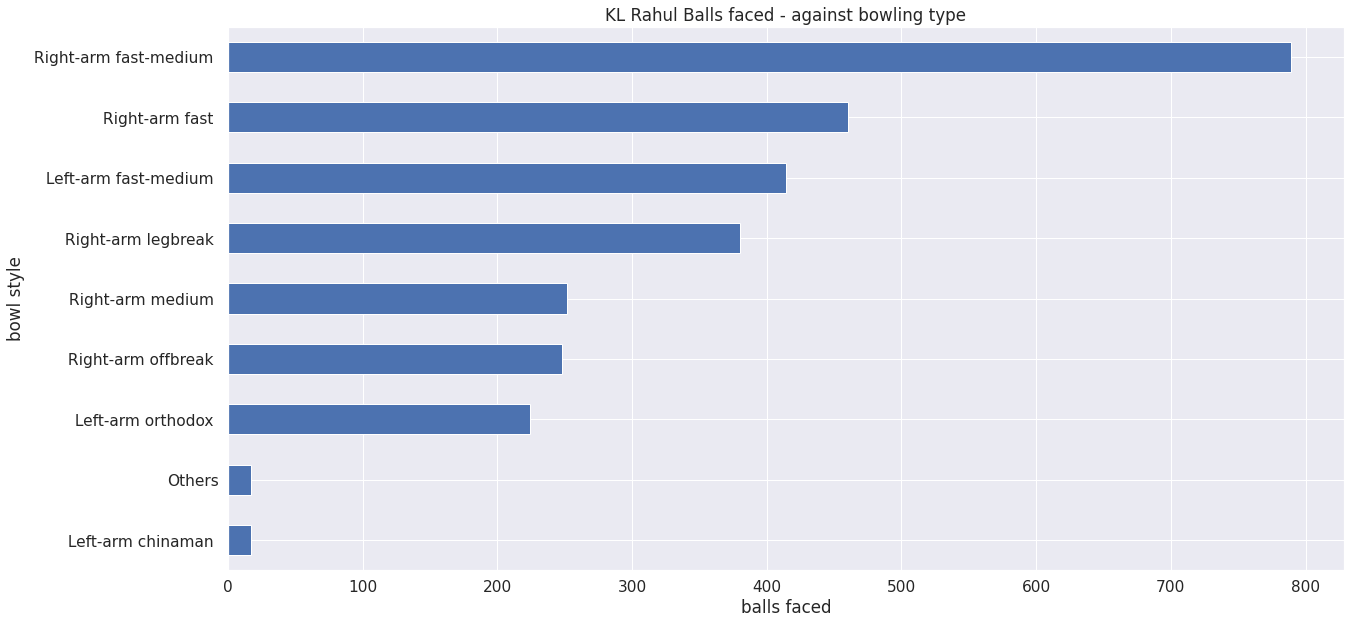

In [272]:
plt.figure(figsize = (20, 10))
match[match.striker == 'KL Rahul'].groupby(['bowl_style'])['ball_no'].count().sort_values().plot(kind = 'barh')
plt.title ('KL Rahul Balls faced - against bowling type')
plt.xlabel('balls faced')
plt.ylabel('bowl style')
plt.show()

In [273]:
Runs_scored= match[match.striker == 'KL Rahul'].groupby(['bowl_style'])['runs_off_bat'].sum().reset_index().rename(columns = {'bowl_style':'Bowling_style','runs_off_bat':'Runs_scored'})
Runs_scored

Bowling_style  Runs_scored
0   Left-arm chinaman       33         
1   Left-arm fast-medium    567        
2   Left-arm orthodox       238        
3   Right-arm fast          624        
4   Right-arm fast-medium   1085       
5   Right-arm legbreak      468        
6   Right-arm medium        351        
7   Right-arm offbreak      358        
8  Others                   21

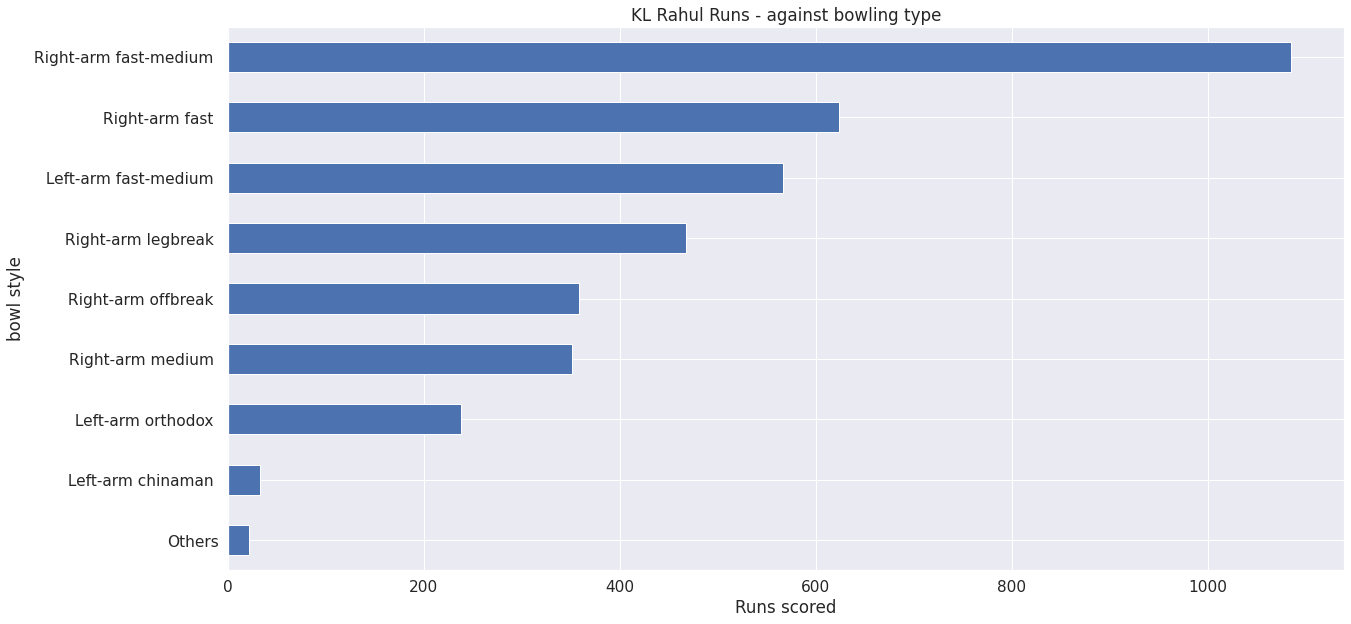

In [274]:
#Overall faced 2855 balls
plt.figure(figsize = (20, 10))
match[match.striker == 'KL Rahul'].groupby(['bowl_style'])['runs_off_bat'].sum().sort_values().plot(kind = 'barh')
plt.title('KL Rahul Runs - against bowling type')
plt.xlabel('Runs scored')
plt.ylabel('bowl style')
plt.show()

In [275]:
Dismissal_count=match[(match.player_dismissed == 'KL Rahul') & (match.wicket_type != 'run out')]['bowl_style'].value_counts().reset_index().rename(columns = {'index':'Bowling_style','bowl_style':'Dismissals_Count'})
Dismissal_count

Bowling_style  Dismissals_Count
0   Right-arm fast-medium   22              
1   Right-arm legbreak      12              
2   Right-arm fast          11              
3   Left-arm fast-medium    9               
4   Right-arm medium        8               
5   Right-arm offbreak      6               
6   Left-arm orthodox       2               
7  Others                   1               
8   Left-arm chinaman       1

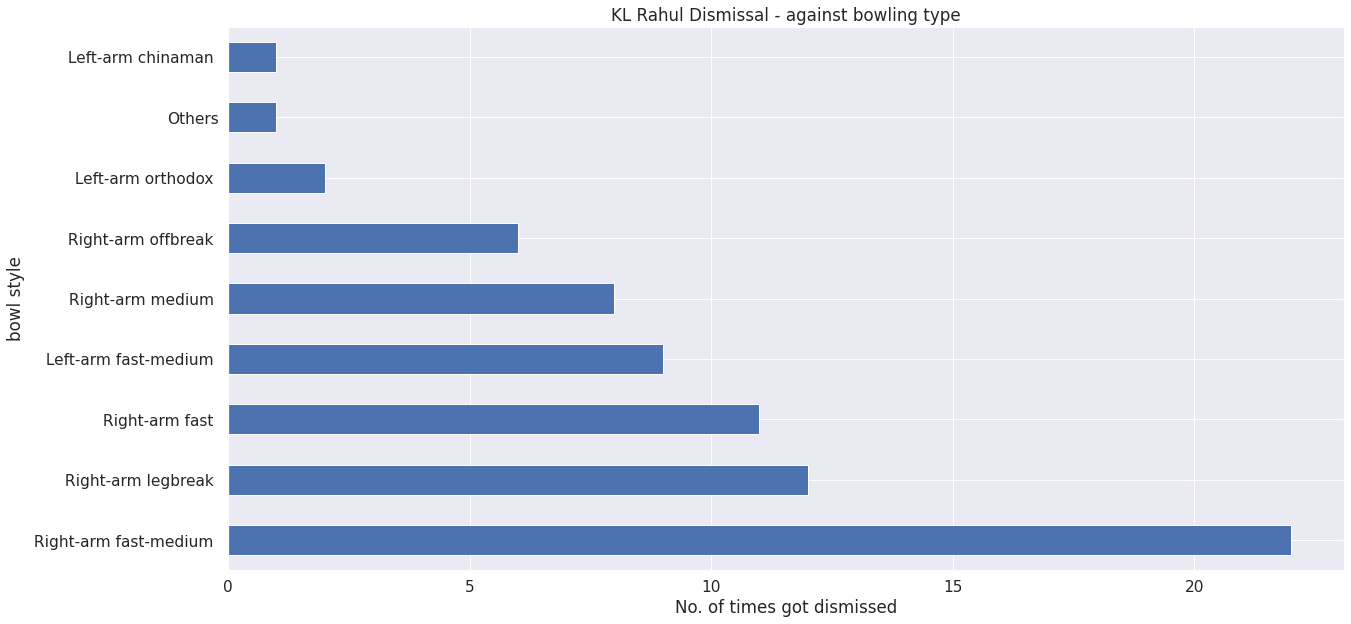

In [276]:
plt.figure(figsize = (20,10))
match[(match.player_dismissed == 'KL Rahul') & (match.wicket_type != 'run out')]['bowl_style'].value_counts().plot(kind = 'barh')
plt.title('KL Rahul Dismissal - against bowling type')
plt.xlabel('No. of times got dismissed')
plt.ylabel('bowl style')
plt.show()

In [277]:
match[match.striker == 'KL Rahul'].groupby(['phase'])['runs_off_bat'].sum().sort_values()

phase
DO    552 
PP    1594
MO    1743
Name: runs_off_bat, dtype: int64

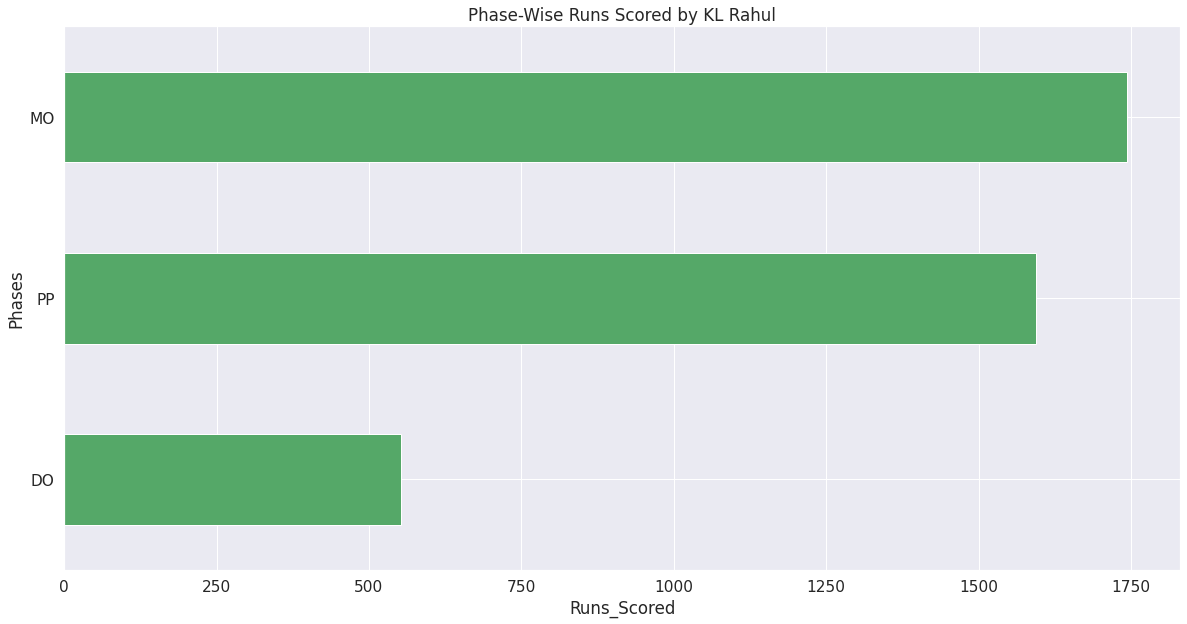

In [278]:
plt.figure(figsize = (20, 10))
match[match.striker == 'KL Rahul'].groupby(['phase'])['runs_off_bat'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('Phase-Wise Runs Scored by KL Rahul')
plt.xlabel('Runs_Scored')
plt.ylabel('Phases')
plt.show()

####**KL RAHUL Batting Statistics Against Different Bowling Type**

In [279]:
frames = [balls_faced,Runs_scored,Dismissal_count]

In [280]:
Kl_stat = pd.concat(frames, axis=1)
Kl_stat

Bowling_style  Balls_Faced            Bowling_style  Runs_scored            Bowling_style  Dismissals_Count
0   Left-arm chinaman       17            Left-arm chinaman       33            Right-arm fast-medium   22              
1   Left-arm fast-medium    414           Left-arm fast-medium    567           Right-arm legbreak      12              
2   Left-arm orthodox       224           Left-arm orthodox       238           Right-arm fast          11              
3   Right-arm fast          460           Right-arm fast          624           Left-arm fast-medium    9               
4   Right-arm fast-medium   789           Right-arm fast-medium   1085          Right-arm medium        8               
5   Right-arm legbreak      380           Right-arm legbreak      468           Right-arm offbreak      6               
6   Right-arm medium        252           Right-arm medium        351           Left-arm orthodox       2               
7   Right-arm offbreak      248           Right-arm offbreak      358          Others                   1               
8  Others                   17           Others                   21            Left-arm chinaman       1

In [281]:
Bowling_style = ['Left-arm chinaman', 'Left-arm fast-medium	', 'Left-arm orthodox', 'Right-arm fast', 'Right-arm fast-medium', 'Right-arm legbreak',
          'Right-arm medium', 'Right-arm offbreak', 'Others']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=Bowling_style,
    y=[17, 414, 224, 460, 789, 380, 252, 248, 17],
    name='Balls_Faced',
    marker_color='blue'

))
fig.add_trace(go.Bar(
    x=Bowling_style,
    y=[33, 567, 238, 624, 1085, 468, 351, 358, 21],
    name='Runs_scored',
    marker_color='green'
))

fig.add_trace(go.Bar(
    x=Bowling_style,
    y=[1, 9, 2, 11, 22, 12, 8, 6, 1],
    name='Dismissals_Count',
    marker_color='red'
))

text_auto= True,
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

**KL Rahul Strengths**
- **KL Rahul has best batting average in Power play overs 61.30 AVG & Batting Average of 47.10 in middle over's**
- **KL Rahul has best batting average of 52.54 against Pace**  
-**KL Rahul has batting average against of 49.86 against Spin**
- **KL Rahul has got Strike rate of 195.05  at the Death overs
& 125.11 at Powe ply and 134.28 in the middle overs**
- **KL Rahul has Strike Rate of 141.92 against Pace**.
-**KL Rahul has Strike Rate of 126.67 against Spin**
-**KL Rahul has strike rate of 141.04 against Left-arm fast-medium**
-**KL Rahul has Batting Average of 60 against Left-arm fast-medium**


**KL Rahul Weakness**

- **Overall KL Rahul has been dismissed 81 times out of which 37 time has been dismissed in Middle overs. 45.67 % got dismissed in middle over.**
- **Most of the time he got dismissed between  (9-14) Overs**
- **KL Rahul has been dismissed by Right- Arm fast-medium 27.16% when compared to other bowling types** 
- **KL Rahul has faced 789 balls and got dismissed 22 times by Right- Arm fast-medium**


In [282]:
best_batting_Scores(match, striker = 'KL Rahul', bowlers =['JJ Bumrah'])

no of rows after all filters: 1
only one player found with these filters
    striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR   AVG   BPD       BPB
0  KL Rahul  12       143   112    2           48    37    15    0       13     4      127.678571  71.5  56.0  6.588235


**Considerning bumrah as the best bolwing attack for KL Rahul**
- **KL Rahul got dismissed twice by Bumrah**
- **KL Rahul got has got beaten (48 dot balls out of 112 balls faced)**
- **KL Rahul has got 71.5  batting AVG against Bumrah.**
- **KL Rahul has got 127.67  batting AVG against Bumrah.**

In [283]:
Dismissed_kl = match[match.striker == 'KL Rahul'].groupby(['bowler'])['player_dismissed'].count().reset_index().rename(columns = {'bowler':'Bowler','player_dismissed':'Dismissal_Count'})
Dismissed_kl.head()

Bowler  Dismissal_Count
0  A Mishra  0              
1  A Nehra   1              
2  A Nortje  0              
3  A Zampa   1              
4  AB Dinda  1

In [284]:
Dismissed_kl.drop(Dismissed_kl[(Dismissed_kl['Dismissal_Count'] <2)].index, inplace=True)
Dismissed_kl

Bowler  Dismissal_Count
8    AR Patel           2              
25   C Sakariya         2              
38   DS Kulkarni        4              
48   Harbhajan Singh    3              
58   JJ Bumrah          2              
68   K Rabada           2              
79   L Ngidi            2              
87   M Prasidh Krishna  2              
90   MJ McClenaghan     2              
93   MM Sharma          2              
96   Mohammed Shami     2              
107  PP Chawla          2              
122  Rashid Khan        3              
133  SN Thakur          2              
134  SP Narine          2              
140  TA Boult           2              
151  YS Chahal          2

**KL Rahul has been dismissed 4 times by DS Kulkarni &  3 times by Rashid Khan & Harbhajan Singh in IPL**

In [285]:
fig = px.bar(Dismissed_kl, x="Bowler", y="Dismissal_Count",color="Bowler", text_auto='Dismissal_Count',
               labels={
                     "bowler": "Bowlers",
                     "Dismissal_Count": "Dismissal_Count" },  title =" Most No. of times KL Rahul has been Dismissed by the Bolwer's in IPL")
fig.show()

###**10.1.2** **David Warner strength  & Weakness**

In [286]:
Bat_stat[(Bat_stat.striker == 'DA Warner')]

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes         SR        AVG        BPD       BPB   sr_mnmx  AVG_mnmx  bpd_mnmx  bpb_mnmx
124  DA Warner  162      5881  4180   140         1633  1513  345   23      577    216    140.69378  42.007143  29.857143  5.271122  0.669612  0.754619  0.671096  0.949752

In [287]:
best_batting_Scores(match, striker = 'DA Warner', phase = 'PP', sorter= 'AVG')

no of rows after all filters: 1
only one player found with these filters
     striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
0  DA Warner  153      2892  2106   62          1020  568   124   19      370    89     137.321937  46.645161  33.967742  4.588235


In [288]:
best_batting_Scores(match, striker = 'DA Warner', phase = 'MO', sorter= 'AVG')

no of rows after all filters: 1
only one player found with these filters
     striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
0  DA Warner  96       2590  1862   59          553   873   195   3       169    107    139.097744  43.898305  31.559322  6.746377


In [289]:
best_batting_Scores(match, striker = 'DA Warner', phase = 'DO', sorter= 'AVG')

no of rows after all filters: 1
only one player found with these filters
     striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR   AVG        BPD       BPB
0  DA Warner  30       399   212    14          60    72    26    1       38     20     188.207547  28.5  15.142857  3.655172


In [290]:
best_batting_Scores(match, striker = 'DA Warner', bowling_style ='Spin')

no of rows after all filters: 1
only one player found with these filters
     striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes         SR        AVG        BPD       BPB
0  DA Warner  121      2052  1476   37          511   620   137   2       153    90     139.02439  55.459459  39.891892  6.074074


In [291]:
best_batting_Scores(match, striker = 'DA Warner', bowling_style ='Pace')

no of rows after all filters: 1
only one player found with these filters
     striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD    BPB
0  DA Warner  156      3473  2483   91          1054  805   194   19      391    109    139.871124  38.164835  27.285714  4.966


In [292]:
best_batting_Scores(match, striker = 'DA Warner', bowl_style=' Right-arm fast-medium ' )

no of rows after all filters: 1
only one player found with these filters
     striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
0  DA Warner  110      1630  1153   42          484   376   88    8       187    51     141.370338  38.809524  27.452381  4.844538


In [293]:
best_batting_Scores(match, striker = 'DA Warner', bowl_style=' Right-arm fast ' )

no of rows after all filters: 1
only one player found with these filters
     striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR    AVG    BPD    BPB
0  DA Warner  74       863   609    25          266   178   52    6       96     29     141.707718  34.52  24.36  4.872


In [294]:
best_batting_Scores(match, striker = 'DA Warner', bowl_style=' Left-arm fast-medium ' )

no of rows after all filters: 1
only one player found with these filters
     striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR   AVG        BPD       BPB
0  DA Warner  57       498   379    15          172   126   29    2       53     16     131.398417  33.2  25.266667  5.492754


In [295]:
best_batting_Scores(match, striker = 'DA Warner', bowl_style=' Right-arm legbreak ' )

no of rows after all filters: 1
only one player found with these filters
     striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD       BPB
0  DA Warner  63       668   449    14          127   200   54    0       51     26     148.775056  47.714286  32.071429  5.831169


In [296]:
DA = match[match['striker']=='DA Warner'].groupby('season')['runs_off_bat'].sum().sort_values().reset_index().rename(columns = {'season':'Season','runs_off_bat':'Runs_Scored'})
DA

Season  Runs_Scored
0   2009    163        
1   2021    195        
2   2012    256        
3   2010    282        
4   2011    324        
5   2013    410        
6   2022    432        
7   2014    528        
8   2020    548        
9   2015    562        
10  2017    641        
11  2019    692        
12  2016    848

In [297]:
DA = match[match['striker']=='DA Warner'].groupby('season')['runs_off_bat'].sum().reset_index()
trace = go.Scatter(x = DA['season'], y = DA['runs_off_bat'],
 mode = 'lines + markers',
 marker = {'color': 'red'})
data = [trace]
layout = go.Layout(title = 'Year by Year Performance',
 xaxis = {'title': 'Season'},
 yaxis = {'title': 'Total Runs'})
fig = go.Figure(data = data, layout = layout)

fig.show()

In [298]:
Da_balls_faced = match[match.striker == 'DA Warner'].groupby(['bowl_style'])['ball_no'].count().reset_index().rename(columns = {'bowl_style':'Bowling_style','ball_no':'Balls Faced'})
Da_balls_faced

Bowling_style  Balls Faced
0    Left-arm chinaman       79         
1    Left-arm fast           22         
2    Left-arm fast-medium    398        
3    Left-arm medium         7          
4    Left-arm orthodox       219        
5    Right-arm fast          628        
6    Right-arm fast-medium   1194       
7    Right-arm legbreak      458        
8    Right-arm medium        324        
9    Right-arm offbreak      757        
10  Others                   28

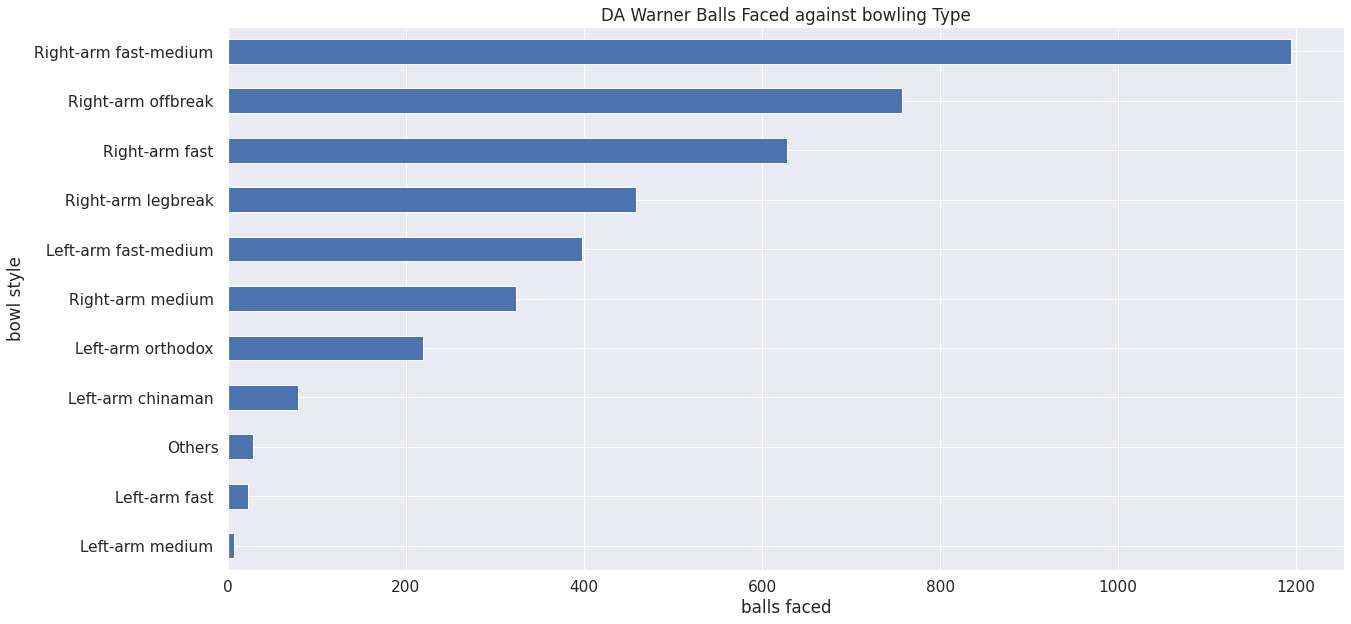

In [299]:
plt.figure(figsize = (20, 10))
match[match.striker == 'DA Warner'].groupby(['bowl_style'])['ball_no'].count().sort_values().plot(kind = 'barh')
plt.title ('DA Warner Balls Faced against bowling Type')
plt.xlabel('balls faced')
plt.ylabel('bowl style')
plt.show()

In [300]:
DA_Runs_scored = match[match.striker == 'DA Warner'].groupby(['bowl_style'])['runs_off_bat'].sum().reset_index().rename(columns = {'bowl_style':'Bowling_style','runs_off_bat':'Runs_Scored'})
DA_Runs_scored

Bowling_style  Runs_Scored
0    Left-arm chinaman       106        
1    Left-arm fast           51         
2    Left-arm fast-medium    498        
3    Left-arm medium         10         
4    Left-arm orthodox       321        
5    Right-arm fast          863        
6    Right-arm fast-medium   1630       
7    Right-arm legbreak      668        
8    Right-arm medium        421        
9    Right-arm offbreak      957        
10  Others                   50

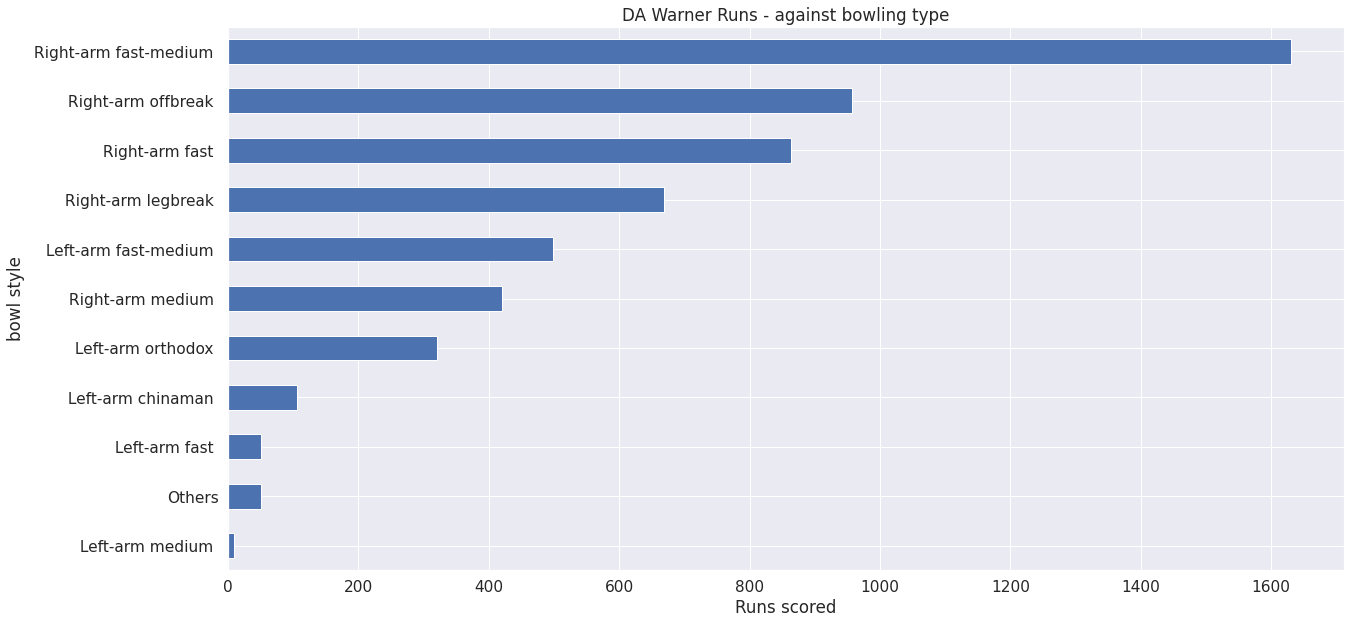

In [301]:
#Overall faced 4180 balls
plt.figure(figsize = (20, 10))
match[match.striker == 'DA Warner'].groupby(['bowl_style'])['runs_off_bat'].sum().sort_values().plot(kind = 'barh')
plt.title('DA Warner Runs - against bowling type')
plt.xlabel('Runs scored')
plt.ylabel('bowl style')
plt.show()

In [302]:
DA_dismissals = match[(match.player_dismissed == 'DA Warner') & (match.wicket_type != 'run out')]['bowl_style'].value_counts().reset_index().rename(columns = {'index':'Bowling_style','bowl_style':'Dismissals_Count'})
DA_dismissals

Bowling_style  Dismissals_Count
0   Right-arm fast-medium   40              
1   Right-arm fast          25              
2   Right-arm offbreak      16              
3   Left-arm fast-medium    15              
4   Right-arm legbreak      13              
5   Right-arm medium        7               
6   Left-arm orthodox       3               
7   Left-arm chinaman       3               
8   Left-arm fast           1               
9   Left-arm medium         1

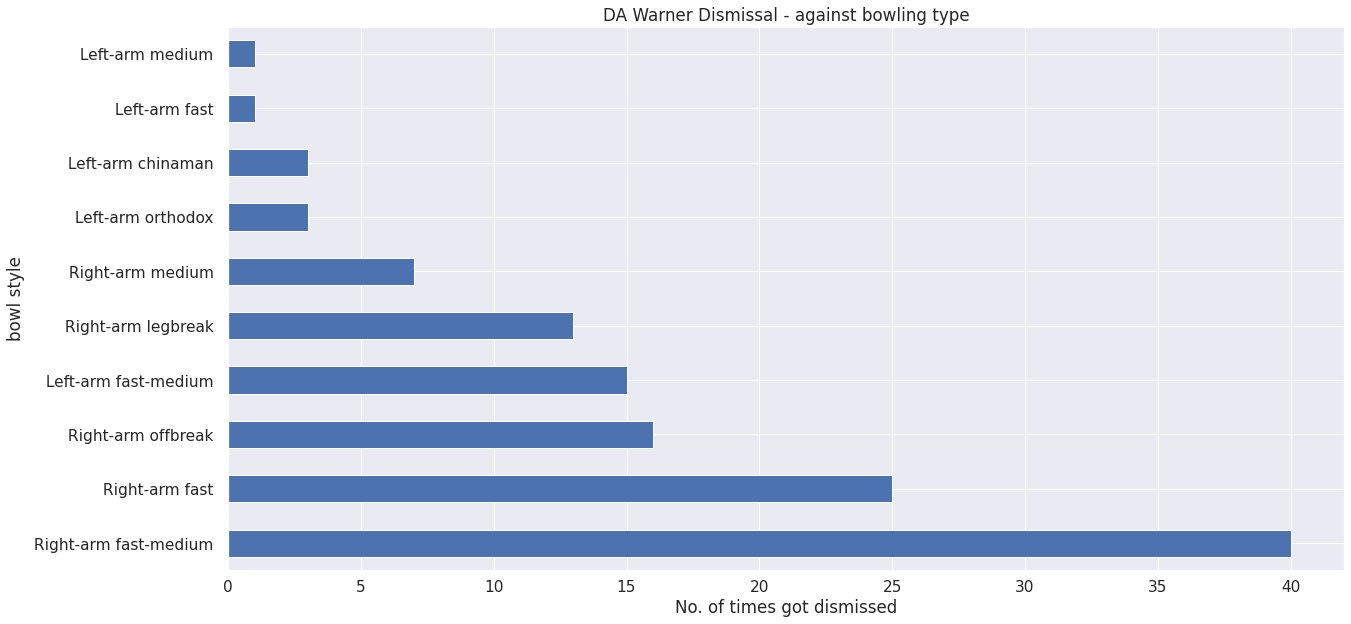

In [303]:
plt.figure(figsize = (20,10))
match[(match.player_dismissed == 'DA Warner') & (match.wicket_type != 'run out')]['bowl_style'].value_counts().plot(kind = 'barh')
plt.title('DA Warner Dismissal - against bowling type')
plt.xlabel('No. of times got dismissed')
plt.ylabel('bowl style')
plt.show()

In [304]:
match[match.striker == 'DA Warner'].groupby(['phase'])['runs_off_bat'].sum().sort_values()

phase
DO    399 
MO    2590
PP    2892
Name: runs_off_bat, dtype: int64

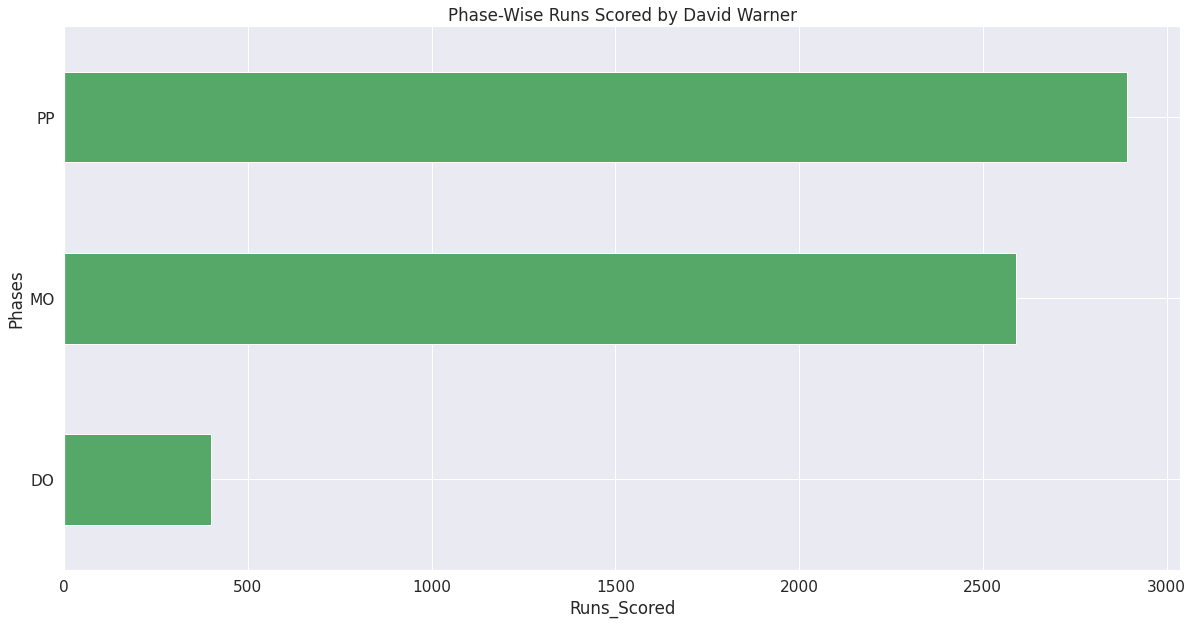

In [305]:
plt.figure(figsize = (20, 10))
match[match.striker == 'DA Warner'].groupby(['phase'])['runs_off_bat'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('Phase-Wise Runs Scored by David Warner')
plt.xlabel('Runs_Scored')
plt.ylabel('Phases')
plt.show()

#### **David Warner Batting Statistic's Against Different Bowling Types**

In [306]:
frames = [Da_balls_faced,DA_Runs_scored,DA_dismissals]
DA_stat = pd.concat(frames, axis=1)
DA_stat

Bowling_style  Balls Faced            Bowling_style  Runs_Scored            Bowling_style  Dismissals_Count
0    Left-arm chinaman       79            Left-arm chinaman       106           Right-arm fast-medium   40.0            
1    Left-arm fast           22            Left-arm fast           51            Right-arm fast          25.0            
2    Left-arm fast-medium    398           Left-arm fast-medium    498           Right-arm offbreak      16.0            
3    Left-arm medium         7             Left-arm medium         10            Left-arm fast-medium    15.0            
4    Left-arm orthodox       219           Left-arm orthodox       321           Right-arm legbreak      13.0            
5    Right-arm fast          628           Right-arm fast          863           Right-arm medium        7.0             
6    Right-arm fast-medium   1194          Right-arm fast-medium   1630          Left-arm orthodox       3.0             
7    Right-arm legbreak      458           Right-arm legbreak      668           Left-arm chinaman       3.0             
8    Right-arm medium        324           Right-arm medium        421           Left-arm fast           1.0             
9    Right-arm offbreak      757           Right-arm offbreak      957           Left-arm medium         1.0             
10  Others                   28           Others                   50           NaN                     NaN

**David Warner Strengths**
- **David Warner has best batting average in Power Play 46.64AVG  & Middle overs 43.89 AVG**
- **David Warner has best batting average against Spin 55.45 AVG**  
- **David Warner has batting average against Pace is 38.16** 
-**David Warner has batting Strike Rate of 139 against Spin**
-**David Warner has batting Strike Rate of 139.87 against Pace**
- **David Warner has got Strike rate of 183.38 at the Death overs**
-**David Warner has got Strike rate of 148.77 against Right-arm-break**
-**David Warner has got Batting Average of 47.71 against Right-arm-break**

**David Warner Weakness**

- **Overall David Warner has been dismissed 140 times out of which 62 time has been dismissed in power Play overs (44.28 %)  & 59 times in middle over (42.12%)
 most of the time got dismissed in Power play. (1-5)**
- **David Warner has been dismissed by Right- Arm fast-medium  28.57% when compared to other bowling types** 
- **David Warner has faced 1194 balls by  and got dismissed 40 times**

In [307]:
best_batting_Scores(match, striker = 'DA Warner', bowlers =['SP Narine'])

no of rows after all filters: 1
only one player found with these filters
     striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR   AVG   BPD   BPB
0  DA Warner  15       176   112    2           44    35    10    1       16     9      157.142857  88.0  56.0  4.48


**Considerning SP Narine- A best spiner against best batsman With Spin**

**DA Warner got dismissed twice by SP Narine**

**DA Warner got has got beaten (44 dot balls out of 112 balls faced)**

**DA Warner has got 88 batting AVG against SP Narine**

**DA Warner has got 88 batting Strike rate of 157.14 against SP Narine.**

In [308]:
Dismissed_DA = match[match.striker == 'DA Warner'].groupby(['bowler'])['player_dismissed'].count().reset_index().rename(columns = {'bowler':'Bowler','player_dismissed':'Dismissal_Count'})
Dismissed_DA

Bowler  Dismissal_Count
0    A Ashish Reddy     0              
1    A Choudhary        1              
2    A Kumble           1              
3    A Mishra           3              
4    A Mithun           0              
5    A Nehra            0              
6    A Nortje           1              
7    A Singh            1              
8    A Symonds          0              
9    AB Agarkar         1              
10   AB Dinda           2              
11   AC Thomas          0              
12   AD Mathews         0              
13   AD Russell         1              
14   AF Milne           0              
15   AJ Tye             0              
16   AK Markram         0              
17   AM Nayar           0              
18   AN Ahmed           0              
19   AR Patel           2              
20   AS Joseph          1              
21   AS Rajpoot         0              
22   Ankit Sharma       0              
23   Ankit Soni         0              
24   Anureet Singh      1              
25   Arshdeep Singh     0              
26   Avesh Khan         0              
27   Azhar Mahmood      0              
28   B Kumar            0              
29   B Lee              0              
30   BA Bhatt           0              
31   BA Stokes          2              
32   BE Hendricks       1              
33   BJ Hodge           0              
34   BW Hilfenhaus      3              
35   Basil Thampi       0              
36   C de Grandhomme    0              
37   CH Gayle           0              
38   CH Morris          1              
39   CJ Anderson        1              
40   CJ Jordan          0              
41   CK Langeveldt      0              
42   CR Brathwaite      1              
43   CR Woakes          1              
44   CRD Fernando       1              
45   CV Varun           1              
46   D Wiese            0              
47   DE Bollinger       0              
48   DJ Bravo           1              
49   DJ Hooda           0              
50   DJ Hussey          0              
51   DJ Muthuswami      0              
52   DJG Sammy          0              
53   DL Chahar          1              
54   DR Sams            1              
55   DR Smith           0              
56   DS Kulkarni        2              
57   DT Christian       0              
58   DW Steyn           2              
59   FA Allen           1              
60   GJ Maxwell         1              
61   Gurkeerat Singh    0              
62   HF Gurney          0              
63   HH Pandya          0              
64   HR Shokeen         0              
65   HV Patel           0              
66   Harbhajan Singh    4              
67   Harmeet Singh      0              
68   Harshit Rana       0              
69   I Sharma           1              
70   IC Pandey          1              
71   Imran Tahir        0              
72   Iqbal Abdulla      0              
73   J Botha            0              
74   J Yadav            1              
75   JA Morkel          1              
76   JC Archer          2              
77   JD Unadkat         1              
78   JDP Oram           0              
79   JH Kallis          2              
80   JJ Bumrah          0              
81   JL Pattinson       1              
82   JO Holder          0              
83   JP Behrendorff     0              
84   JP Duminy          2              
85   JP Faulkner        1              
86   JR Hazlewood       0              
87   JW Hastings        1              
88   Joginder Sharma    0              
89   K Gowtham          0              
90   K Rabada           3              
91   KA Jamieson        1              
92   KA Pollard         0              
93   KC Cariappa        0              
94   KH Pandya          0              
95   KJ Abbott          0              
96   KK Cooper          0              
97   KMA Paul           0              
98   KP Appanna         0              
99   KP Pieterse

In [309]:
Dismissed_DA.drop(Dismissed_DA[(Dismissed_DA['Dismissal_Count'] <=2)].index, inplace=True)
Dismissed_DA

Bowler  Dismissal_Count
3    A Mishra         3              
34   BW Hilfenhaus    3              
66   Harbhajan Singh  4              
90   K Rabada         3              
105  L Balaji         3              
139  P Kumar          3              
150  R Ashwin         4              
169  Ravi Bishnoi     3              
197  Sandeep Sharma   3              
211  UT Yadav         5

**David warner has been dismissed by Umesh Yadav 5 times & 4 times by R Ashwin & Harbajan singh.**

In [310]:
fig = px.bar(Dismissed_DA, x="Bowler", y="Dismissal_Count",color="Bowler", text_auto='Dismissal_Count',
               labels={
                     "bowler": "Bowlers",
                     "Dismissal_Count": "Dismissal_Count" },  title ="Most No. of times DA Warner has been Dismissed by the Bolwer's in IPL")
fig.show()

**Performance Comparison between KL Rahul & DA Warner**

In [311]:
trace = go.Scatter(x = KL['season'], y = KL['runs_off_bat'],
 mode = 'lines + markers',
 marker = {'color': 'green'}, name = 'KL Rahul')
trace_1 = go.Scatter(x = DA['season'], y = DA['runs_off_bat'],
 mode = 'lines + markers',
 marker = {'color': 'red'}, name = 'DA Warner')
data = [trace, trace_1]
layout = go.Layout(title = 'Year by Year Performance',
 xaxis = {'title': 'Season'},
 yaxis = {'title': 'Total Runs'})
fig = go.Figure(data = data, layout = layout)

fig.show()

In [1]:
VK = match[match['striker']=='V Kohli'].groupby('season')['runs_off_bat'].sum().reset_index()

RS = match[match['striker']=='RG Sharma'].groupby('season')['runs_off_bat'].sum().reset_index()

NameError: ignored

In [ ]:
trace_5 = go.Scatter(x = VK['season'], y = VK['runs_off_bat'],
 mode = 'lines + markers',
 marker = {'color': 'green'}, name = 'Virat kholi')
trace_6 = go.Scatter(x = RS['season'], y = RS['runs_off_bat'],
 mode = 'lines + markers',
 marker = {'color': 'red'}, name = 'Rohit Sharma')
data = [trace_5, trace_6]
layout = go.Layout(title = 'Year by Year Performance',
 xaxis = {'title': 'Season'},
 yaxis = {'title': 'Total Runs'})

fig = go.Figure(data = data, layout = layout)

fig.show()

##**10.2** **Bowlers strength  & Weakness**

**lets Consider Two Top IPL Bowler  based on the  Eocnomy  & list down there Strenght & Weakness :** 

**Condition The Player must have bowled minimum 150 balls to be bowled.**

In [312]:
  match.batting_style.unique()

array(['RHB', 'LHB', nan, ' -- '], dtype=object)

In [313]:
def best_bowling_scores(match, min_balls = 12, season = None, batting_team	 = None, venue = None, innings = None, phase = None, bowler= None, batting_style= None, worst = None, sorter = None):
  
  # season
  if season != None:
    match = match[match.season == season]

  # innings
  if innings != None:
    match = match[match.innings == innings]
  
  # phase
  if phase != None:
    match = match[match.phase == phase]

  # Batting team
  if batting_team != None:
    match = match[match.batting_team == batting_team]

  # venue
  if venue != None:
    match = match[match.venue == venue]

 # bowlers - list
  if bowler != None:
    match = match[match.bowler.isin(bowler)]

 # batting style - list
  if batting_style != None:
    match = match[match.batting_style == batting_style]
  
  # calculation
  match = playerStatistics_bowler(match)
  match = match[match.balls_bowled >= min_balls]

   # count of rows
  print("no of rows after all filters:", len(match))
  if len(match) == 0:
    print("No players found with these filters")
    return None
  elif len(match) == 1:
    print("only one player found with these filters")
    # preview df
    print(match.head())
    return None

  # change inf values to some high number
  match['Avg'].replace([np.inf, -np.inf], 100, inplace=True)
  match['SR'].replace([np.inf, -np.inf], 100, inplace=True)

  match['Dot%_mnmx'] = bowlers_minmax(match.dots)
  match['Avg_mnmx'] = bowlers_minmax_reverse(match.Avg)
  match['sr_mnmx'] = bowlers_minmax_reverse(match.SR)
  match['Eco_mnmx'] = bowlers_minmax_reverse(match.Eco)

  match['total_score_bowlers'] = match['Dot%_mnmx'] + match['Avg_mnmx'] + match['sr_mnmx'] + match['Eco_mnmx']

  if sorter != None:
    if (sorter.lower() == 'eco') or (sorter.lower() == 'avg') or (sorter.lower() == 'sr') :
      match.sort_values(sorter, ascending = True, inplace = True)
    else:
      match.sort_values(sorter, ascending = False, inplace = True)

    return match

  if worst != None:
    match.sort_values('total_score_bowlers', ascending = True, inplace = True)
  else:
    match.sort_values('total_score_bowlers', ascending = False, inplace = True)

  return match

In [314]:
best_bowling_scores(match,min_balls= 1500).head(10)

no of rows after all filters: 42


bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  total_score_bowlers
394  SL Malinga       122      3371.0  2827          170         1357  1022  187   7       314    86     48.001415  19.829412  16.629412  7.154581  0.794684   1.000000  0.975291  0.710032  3.480006           
356  Rashid Khan      92       2333.0  2195          112         911   959   111   2       155    81     41.503417  20.830357  19.598214  6.377221  0.385885   0.943400  0.721639  1.000000  3.050923           
402  SP Narine        147      3820.0  3457          152         1468  1410  227   8       263    134    42.464565  25.131579  22.743421  6.630026  0.896425   0.700180  0.452915  0.905699  2.955219           
469  YS Chahal        130      3624.0  2856          166         1129  1242  171   10      209    179    39.530812  21.831325  17.204819  7.613445  0.585701   0.886798  0.926128  0.538867  2.937495           
63   B Kumar          146      3971.0  3262          154         1581  1054  223   12      400    112    48.467198  25.785714  21.181818  7.304108  1.000000   0.663190  0.586337  0.654255  2.903783           
178  JJ Bumrah        120      3379.0  2742          145         1218  984   213   12      305    101    44.420131  23.303448  18.910345  7.393873  0.667278   0.803554  0.780410  0.620772  2.872013           
7    A Mishra         154      3976.0  3245          166         1244  1415  248   6       228    176    38.335901  23.951807  19.548193  7.351618  0.691109   0.766892  0.725912  0.636533  2.820447           
109  DJ Bravo         158      4360.0  3120          183         1225  1291  269   6       349    155    39.262821  23.825137  17.049180  8.384615  0.673694   0.774055  0.939426  0.251208  2.638382           
149  Harbhajan Singh  160      4030.0  3416          150         1390  1468  185   12      296    145    40.690867  26.866667  22.773333  7.078454  0.824931   0.602066  0.450359  0.738428  2.615785           
128  DW Steyn         95       2508.0  2176          97          1159  638   129   13      283    54     53.262868  25.855670  22.432990  6.915441  0.613199   0.659235  0.479438  0.799235  2.551106

**Considering two bowlers - spinner &   Pace Bowlers based on their metrics (total scores) -** **Rashid Khan & Bhuvaneshwar Kumar**
**Not considering the SL Malinga as he has been retired from IPL**

###**10.2.1**  **Rashid Khan Strenght & weakness**

In [315]:
match.head(1)

match_id  season  start_date                  venue  innings  ball                 batting_team           bowling_team     striker non_striker      bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty wicket_type player_dismissed  other_wicket_type  other_player_dismissed               bowl_style bowling_style           bat_style batting_style  wides_cnt_balls  noballs_cnt_balls  noballs_cnt_balls_bowler  byes_cnt_balls  legbyes_cnt_balls  legal_ball  legal_ball_bowler  over_no  ball_no phase  isDot  isOne  isTwo  isThree  isFour  isSix  total_runs  isBowlerWk  isOut
0  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        6.8   Royal Challengers Bangalore  Kolkata Knight Riders  MV Boucher  CL White    AB Agarkar  4             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  6        8        MO    0      0      0      0        1       0      4.0         0           0

In [316]:
bowl_stat[(bowl_stat.bowler == 'Rashid Khan')]

bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx
356  Rashid Khan  92       2333.0  2195          112         911   959   111   2       155    81     41.503417  20.830357  19.598214  6.377221  0.415034   0.846836  0.221407  0.822855

In [317]:
best_bowling_scores(match,phase = 'PP', bowler=['Rashid Khan'])

no of rows after all filters: 1
only one player found with these filters
        bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR     Eco
0  Rashid Khan  30       242.0  192           9           89    65    10    1       18     13     46.354167  26.888889  21.333333  7.5625


In [318]:
best_bowling_scores(match,phase = 'MO', bowler=['Rashid Khan'])

no of rows after all filters: 1
only one player found with these filters
        bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco
0  Rashid Khan  91       1840.0  1793          89          730   814   90    1       118    57     40.713887  20.674157  20.146067  6.157278


In [319]:
best_bowling_scores(match,phase = 'DO', bowler=['Rashid Khan'])

no of rows after all filters: 1
only one player found with these filters
        bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg    SR       Eco
0  Rashid Khan  34       251.0  210           14          92    80    11    0       19     11     43.809524  17.928571  15.0  7.171429


In [320]:
best_bowling_scores(match, bowler=['Rashid Khan'],batting_style = 'RHB')

no of rows after all filters: 1
only one player found with these filters
        bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes      Dot%        Avg         SR       Eco
0  Rashid Khan  92       1553.0  1477          71          597   669   77    1       95     53     40.41977  21.873239  20.802817  6.308734


In [321]:
best_bowling_scores(match, bowler=['Rashid Khan'],batting_style = 'LHB')

no of rows after all filters: 1
only one player found with these filters
        bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco
0  Rashid Khan  75       681.0  629           36          276   253   28    1       54     24     43.879173  18.916667  17.472222  6.496025


In [322]:
match[(match.bowler == 'Rashid Khan') & (match.wicket_type != 'run out')] .groupby(['batting_style']).count()

match_id  season  start_date  venue  innings  ball  batting_team  bowling_team  striker  non_striker  bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty  wicket_type  player_dismissed  other_wicket_type  other_player_dismissed  bowl_style  bowling_style  bat_style  wides_cnt_balls  noballs_cnt_balls  noballs_cnt_balls_bowler  byes_cnt_balls  legbyes_cnt_balls  legal_ball  legal_ball_bowler  over_no  ball_no  phase  isDot  isOne  isTwo  isThree  isFour  isSix  total_runs  isBowlerWk  isOut
batting_style                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
LHB            633       633     633         633    633      633   633           633           633      633          633     633           633     7      0        1     12       0        36           36                0                  0                       633         633            633        633              633                633                       633             633                633         633                633      633      633    633    633    633    633      633     633    633         633         633  
RHB            1488      1488    1488        1488   1488     1488  1488          1488          1488     1488         1488    1488          1488    15     0        5     19       0        71           71                0                  0                       1488        1488           1488       1488             1488               1488                      1488            1488               1488        1488               1488     1488     1488   1488   1488   1488   1488     1488    1488   1488        1488        1488

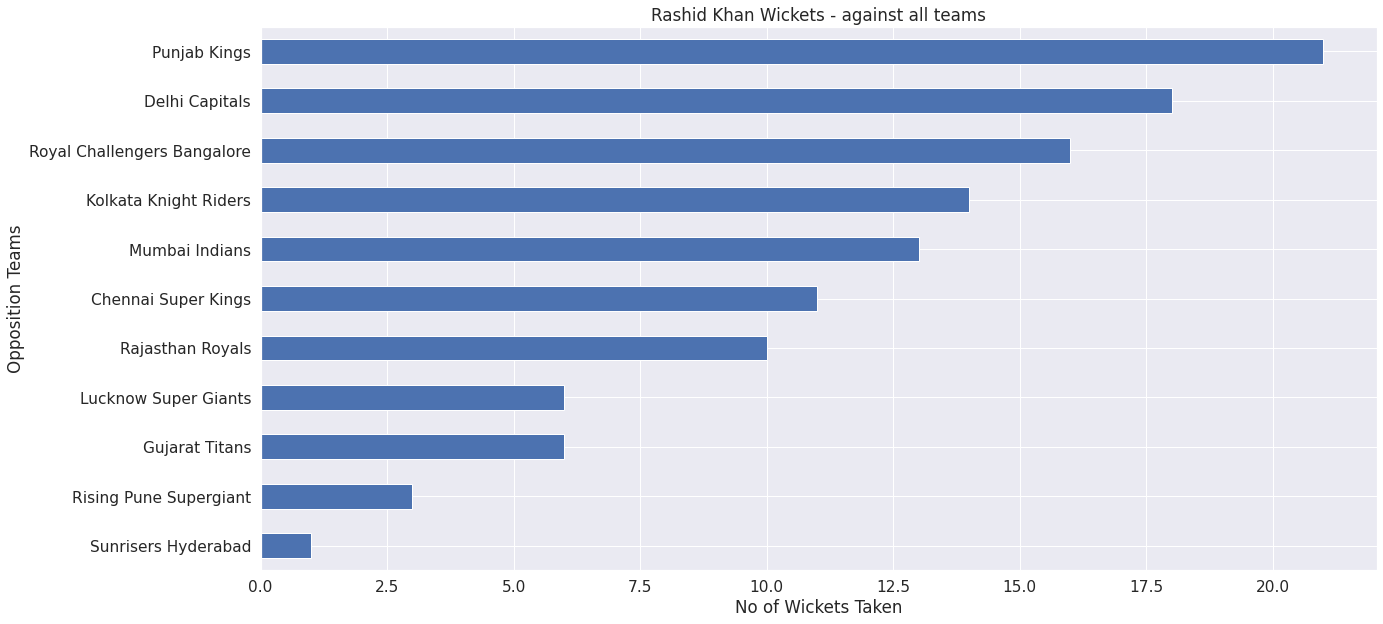

In [323]:
plt.figure(figsize = (20, 10))
match[match.bowler == 'Rashid Khan'].groupby(['batting_team'])['isOut'].sum().sort_values().plot(kind = 'barh')
plt.title('Rashid Khan Wickets - against all teams')
plt.xlabel('No of Wickets Taken')
plt.ylabel('Opposition Teams')
plt.show()

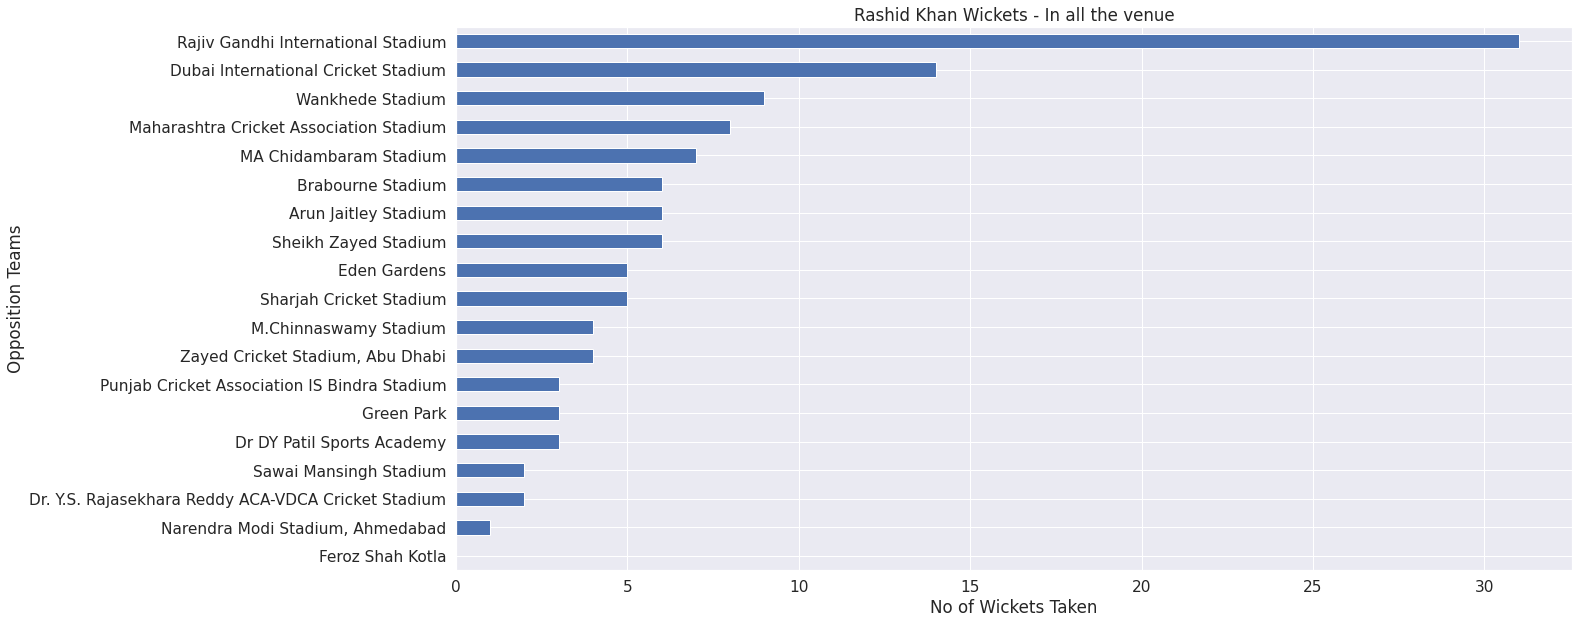

In [324]:
plt.figure(figsize = (20, 10))
match[match.bowler == 'Rashid Khan'].groupby(['venue'])['isOut'].sum().sort_values().plot(kind = 'barh')
plt.title('Rashid Khan Wickets - In all the venue')
plt.xlabel('No of Wickets Taken')
plt.ylabel('Opposition Teams')
plt.show()

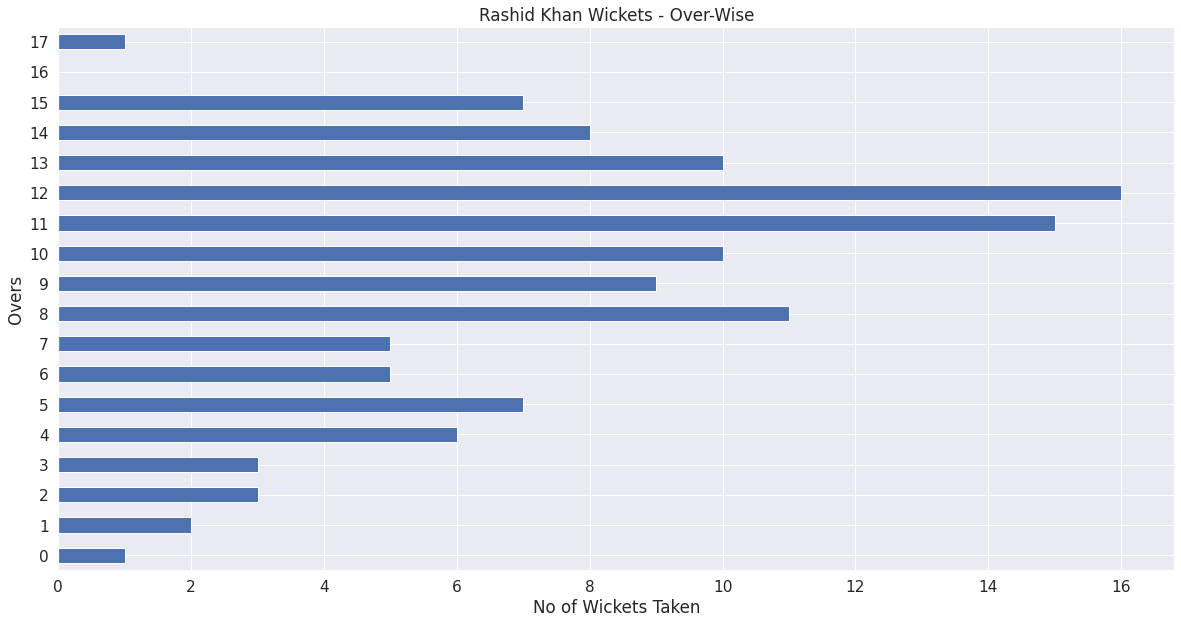

In [325]:
plt.figure(figsize = (20, 10))
match[match.bowler == 'Rashid Khan'].groupby(['over_no'])['isOut'].sum().reset_index().sort_values('over_no')['isOut'].plot(kind = 'barh')
plt.title('Rashid Khan Wickets - Over-Wise')
plt.xlabel('No of Wickets Taken')
plt.ylabel('Overs')
plt.show()

**Phase-wise Wickets Taken by Rashid Khan**

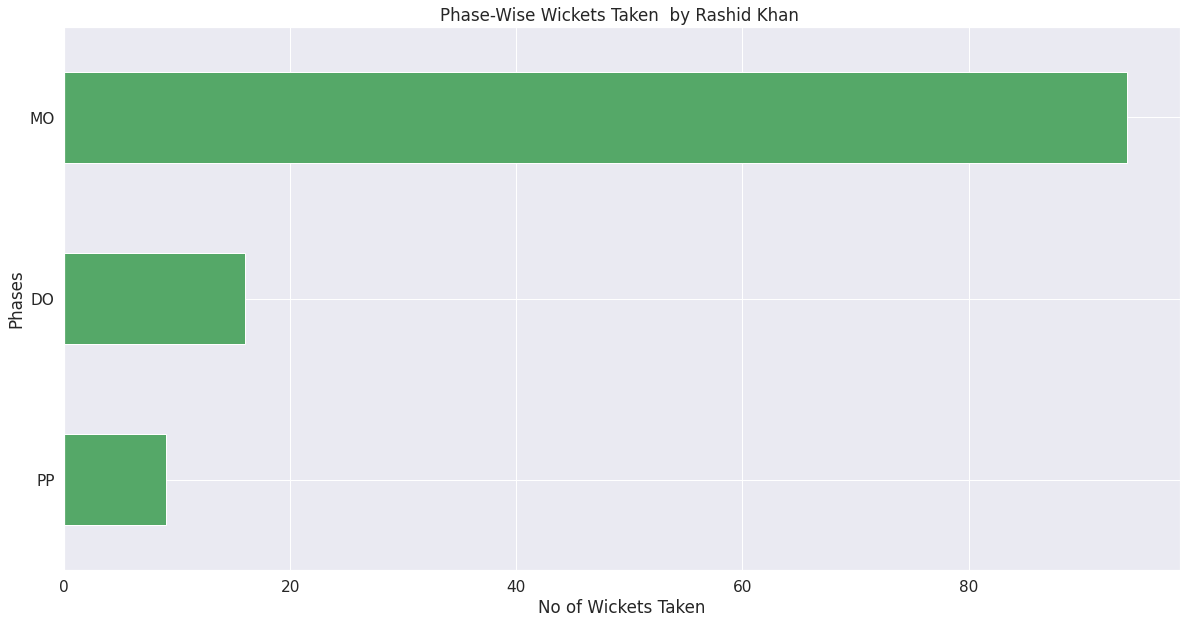

In [326]:
plt.figure(figsize = (20, 10))
match[match.bowler == 'Rashid Khan'].groupby(['phase'])['isOut'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('Phase-Wise Wickets Taken  by Rashid Khan ')
plt.xlabel('No of Wickets Taken')
plt.ylabel('Phases')
plt.show()

In [327]:
Rashid_runs = match[match.bowler == 'Rashid Khan'].groupby(['striker'])['runs_off_bat'].sum().reset_index().rename(columns = {'striker':'Batsmen','runs_off_bat':'Runs_Scored'})
Rashid_runs

Batsmen  Runs_Scored
0    A Badoni           16         
1    AB de Villiers     45         
2    AD Mathews         2          
3    AD Russell         11         
4    AJ Finch           37         
5    AK Markram         19         
6    AM Rahane          41         
7    AR Patel           7          
8    AS Rajpoot         2          
9    AT Rayudu          79         
10   Abhishek Sharma    47         
11   Avesh Khan         12         
12   BA Stokes          11         
13   BB McCullum        2          
14   BCJ Cutting        4          
15   C Munro            1          
16   C de Grandhomme    33         
17   CA Ingram          2          
18   CA Lynn            23         
19   CH Gayle           54         
20   CH Morris          3          
21   CJ Anderson        2          
22   CJ Jordan          0          
23   D Padikkal         18         
24   DA Miller          6          
25   DJ Bravo           2          
26   DJ Hooda           28         
27   DR Smith           18         
28   DS Kulkarni        1          
29   DT Christian       1          
30   E Lewis            0          
31   EJG Morgan         20         
32   F du Plessis       19         
33   FA Allen           2          
34   G Gambhir          7          
35   GJ Maxwell         49         
36   Gurkeerat Singh    11         
37   HE van der Dussen  0          
38   HH Pandya          27         
39   HV Patel           6          
40   Harbhajan Singh    0          
41   Harpreet Brar      2          
42   IR Jaggi           2          
43   Ishan Kishan       74         
44   JC Buttler         30         
45   JDS Neesham        9          
46   JJ Roy             1          
47   JM Sharma          3          
48   JO Holder          1          
49   JP Faulkner        2          
50   JR Philippe        3          
51   K Rabada           1          
52   KA Pollard         26         
53   KC Cariappa        9          
54   KD Karthik         31         
55   KH Pandya          16         
56   KK Nair            12         
57   KL Rahul           18         
58   KM Jadhav          6          
59   KS Williamson      6          
60   LS Livingstone     26         
61   Lalit Yadav        10         
62   M Prasidh Krishna  1          
63   M Shahrukh Khan    4          
64   M Vohra            39         
65   MA Agarwal         23         
66   MC Henriques       5          
67   MK Lomror          13         
68   MK Pandey          12         
69   MK Tiwary          3          
70   MM Ali             52         
71   MM Sharma          1          
72   MP Stoinis         6          
73   MS Dhoni           24         
74   Mandeep Singh      7          
75   Mohammed Shami     0          
76   Mohammed Siraj     0          
77   Mujeeb Ur Rahman   9          
78   N Jagadeesan       4          
79   N Pooran           13         
80   N Rana             75         
81   NM Coulter-Nile    1          
82   NT Ellis           1          
83   NV Ojha            0          
84   P Ray Barman       5          
85   P Simran Singh     1          
86   PA Patel           2          
87   PBB Rajapaksa      7          
88   PJ Sangwan         0          
89   PP Chawla          4          
90   PP Shaw            22         
91   Q de Kock          28         
92   R Ashwin           8          
93   R Parag            6          
94   R Powell           3          
95   R Tewatia          12         
96   RA Jadeja          18         
97   RA Tripathi        35         
98   RD Chahar          7          
99   RD Gaikwad         53         
100  RG Sharma          23         
101  RK Singh           11         
102  RM Patidar         12         
103  RR Pant            87         
104  RV Uthappa         64         
105  S Dhawan           53         
106  S Dube             4          
107  S Gopal            8          
108  SA Yadav           33         
109  SE Marsh           11         
110  SE Rutherford 

In [328]:
Rashid_runs.drop(Rashid_runs[(Rashid_runs['Runs_Scored']< 50)].index, inplace=True)
Rashid_runs

Batsmen  Runs_Scored
9    AT Rayudu     79         
19   CH Gayle      54         
43   Ishan Kishan  74         
70   MM Ali        52         
80   N Rana        75         
99   RD Gaikwad    53         
103  RR Pant       87         
104  RV Uthappa    64         
105  S Dhawan      53         
116  SR Watson     82         
117  SS Iyer       83         
120  SV Samson     81         
129  V Kohli       54

In [329]:
fig = px.bar(Rashid_runs, x="Batsmen", y="Runs_Scored",color="Batsmen", text_auto='Runs_Scored',
               labels={
                     "Batsmen": "Batsmen",
                     "Runs_Scored": "Runs_Scored" },  title ="Most Runs Scored by Batsmen Against Rashid Khan in IPL")
fig.show()

In [330]:
Rashid_wc = match[match.bowler == 'Rashid Khan'].groupby(['striker'])['player_dismissed'].count().reset_index().rename(columns = {'striker':'Batsmen','player_dismissed':'Dismissals'})

In [331]:
Rashid_wc.drop(Rashid_wc[(Rashid_wc['Dismissals']<=2)].index, inplace=True)
Rashid_wc

Batsmen  Dismissals
1    AB de Villiers  3         
19   CH Gayle        3         
23   D Padikkal      3         
26   DJ Hooda        4         
32   F du Plessis    3         
44   JC Buttler      3         
54   KD Karthik      3         
55   KH Pandya       3         
57   KL Rahul        3         
60   LS Livingstone  3         
70   MM Ali          3         
100  RG Sharma       3         
103  RR Pant         3         
105  S Dhawan        4         
111  SK Raina        3

In [332]:
fig = px.bar(Rashid_wc, x="Batsmen", y="Dismissals",color="Batsmen", text_auto='Dismissals',
               labels={
                     "Batsmen": "Batsmen",
                     "Dismissals": "Dismissals_Count" },  title ="Most no. of times Dismissal's of Batsmen by  Rashid Khan in IPL")
fig.show()

In [333]:
bowl_stat.loc[bowl_stat['bowler'] == 'Rashid Khan']

bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx
356  Rashid Khan  92       2333.0  2195          112         911   959   111   2       155    81     41.503417  20.830357  19.598214  6.377221  0.415034   0.846836  0.221407  0.822855

**Strength & Weakness of Rashid Khan**

**Strength's**
- **Rashid Khan has the Economy of 6.308734 against the Right hand bastman
& 6.49 Against Left hand batsman**
- **Rashid khan has taken 79.56% of wickets in the middle overs.
Most of the times has taken wickets between (11-14) Overs**
- **Rashid Khan has the economy of 6 between (6-15) overs**
- **Rashid Khan has dismissed  71 Right hand batsman(63.40%) out of 112 dismissal's**
- **Rashid Khan is Best for middle over's as you can see above that he has taken more wickets in Middle over's - He is best to break the partnership**
-  **Rashid Kahan has a Bowling average of 18.91 against Left hand batsman**

**Weakness**

-  **Rashid Khan has dismissed  36 Left hand batsman(32.14%) out of 112 dismissal's**
- **Rashid Khan has a Bowling Average of 21.87% against Right hand batsman**

- **Rashid Khan takes wicket for every 20 balls against right hand batsman**
- **Rashid Khan takes only 6% of wicket in the 1-6 overs (power play)**
- **Rashid Khan takes only 12.5% of wickets in the Death Overs**
-**Rashid Khan has Economy of 7.5 & 7.1 In Power Play & Death Overs Respectively**





###**10.2.2** **Bhuvaneshwar Kumar strength & weakness**

In [334]:
bowl_stat[(bowl_stat.bowler == 'B Kumar')]

bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx  sr_mnmx  Eco_mnmx
63  B Kumar  146      3971.0  3262          154         1581  1054  223   12      400    112    48.467198  25.785714  21.181818  7.304108  0.484672   0.810399  0.24026  0.797108

In [335]:
best_bowling_scores(match,phase = 'PP', bowler=['B Kumar'])

no of rows after all filters: 1
only one player found with these filters
    bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco
0  B Kumar  145      1754.0  1745          55          1061  415   68    8       215    37     60.802292  31.890909  31.727273  6.030946


In [336]:
best_bowling_scores(match,phase = 'MO', bowler=['B Kumar'])

no of rows after all filters: 1
only one player found with these filters
    bowler  innings   runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR      Eco
0  B Kumar  78       684.0  518           22          163   238   58    0       55     16     31.467181  31.090909  23.545455  7.92278


In [337]:
best_bowling_scores(match,phase = 'DO', bowler=['B Kumar'])

no of rows after all filters: 1
only one player found with these filters
    bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco
0  B Kumar  118      1533.0  999           77          357   401   97    4       130    59     35.735736  19.909091  12.974026  9.207207


In [338]:
best_bowling_scores(match, bowler=['B Kumar'],batting_style = 'RHB')

no of rows after all filters: 1
only one player found with these filters
    bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco
0  B Kumar  146      2683.0  2263          110         1106  720   155   9       276    71     48.873177  24.390909  20.572727  7.113566


In [339]:
best_bowling_scores(match, bowler=['B Kumar'],batting_style = 'LHB')

no of rows after all filters: 1
only one player found with these filters
    bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%   Avg         SR       Eco
0  B Kumar  124      1178.0  918           38          448   297   58    3       119    36     48.801743  31.0  24.157895  7.699346


In [340]:
match[(match.bowler == 'B Kumar') & (match.wicket_type != 'run out')] .groupby(['batting_style']).count()

match_id  season  start_date  venue  innings  ball  batting_team  bowling_team  striker  non_striker  bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty  wicket_type  player_dismissed  other_wicket_type  other_player_dismissed  bowl_style  bowling_style  bat_style  wides_cnt_balls  noballs_cnt_balls  noballs_cnt_balls_bowler  byes_cnt_balls  legbyes_cnt_balls  legal_ball  legal_ball_bowler  over_no  ball_no  phase  isDot  isOne  isTwo  isThree  isFour  isSix  total_runs  isBowlerWk  isOut
batting_style                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
 --            9         9       9           9      9        9     9             9             9        9            9       9             9       1      0        0     0        0        0            0                 0                  0                       9           9              9          9                9                  9                         9               9                  9           9                  9        9        9      9      9      9      9        9       9      9           9           9    
LHB            957       957     957         957    957      957   957           957           957      957          957     957           957     41     2        3     23       0        38           38                0                  0                       957         957            957        957              957                957                       957             957                957         957                957      957      957    957    957    957    957      957     957    957         957         957  
RHB            2332      2332    2332        2332   2332     2332  2332          2332          2332     2332         2332    2332          2332    68     8        4     49       0        110          110               0                  0                       2332        2332           2332       2332             2332               2332                      2332            2332               2332        2332               2332     2332     2332   2332   2332   2332   2332     2332    2332   2332        2332        2332

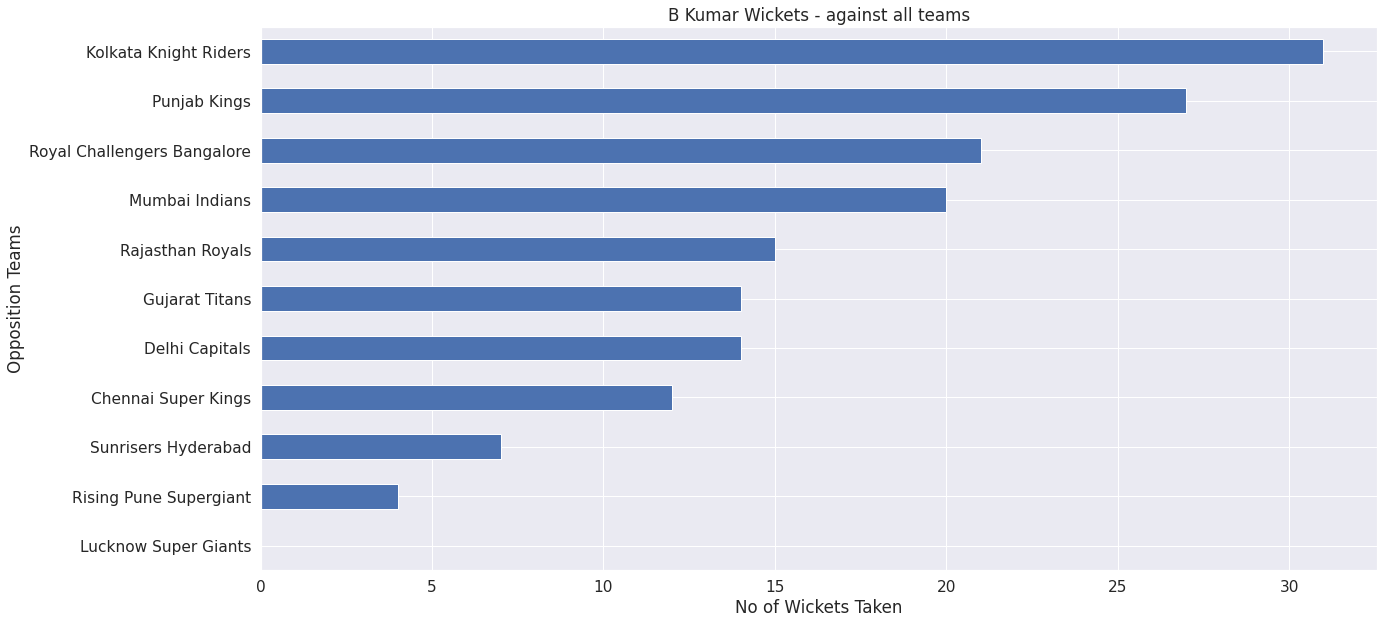

In [341]:
plt.figure(figsize = (20, 10))
match[match.bowler == 'B Kumar'].groupby(['batting_team'])['isOut'].sum().sort_values().plot(kind = 'barh')
plt.title('B Kumar Wickets - against all teams')
plt.xlabel('No of Wickets Taken')
plt.ylabel('Opposition Teams')
plt.show()

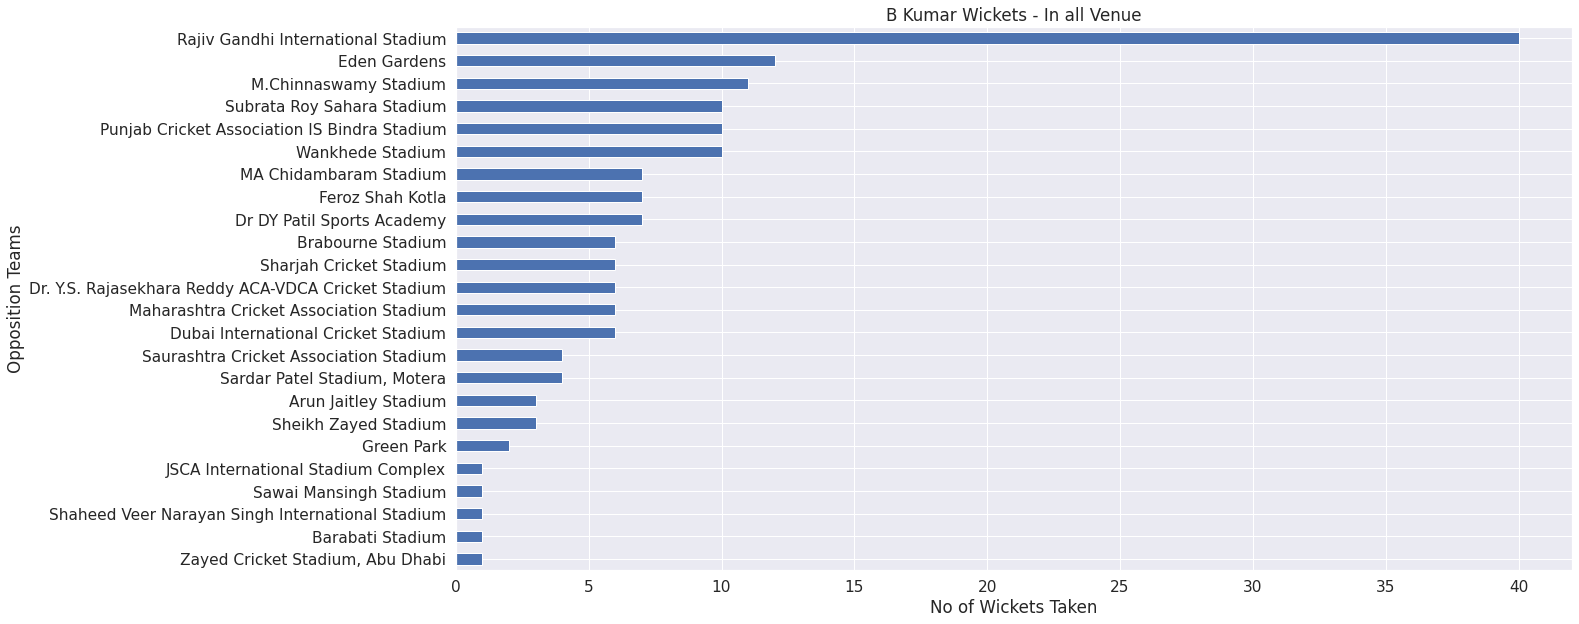

In [342]:
plt.figure(figsize = (20, 10))
match[match.bowler == 'B Kumar'].groupby(['venue'])['isOut'].sum().sort_values().plot(kind = 'barh')
plt.title('B Kumar Wickets - In all Venue')
plt.xlabel('No of Wickets Taken')
plt.ylabel('Opposition Teams')
plt.show()

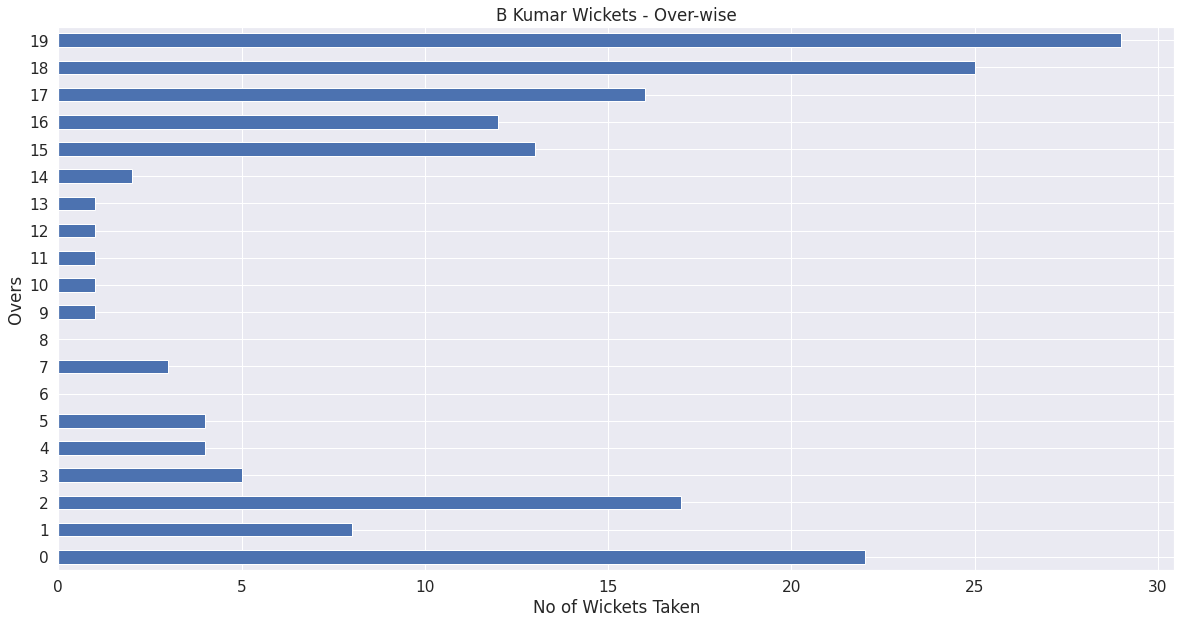

In [343]:
plt.figure(figsize = (20, 10))
match[match.bowler == 'B Kumar'].groupby(['over_no'])['isOut'].sum().reset_index().sort_values('over_no')['isOut'].plot(kind = 'barh')
plt.title('B Kumar Wickets - Over-wise')
plt.xlabel('No of Wickets Taken')
plt.ylabel('Overs')
plt.show()

**Phases-wise Wickets Taken by Bhuvaneshwar Kumar**

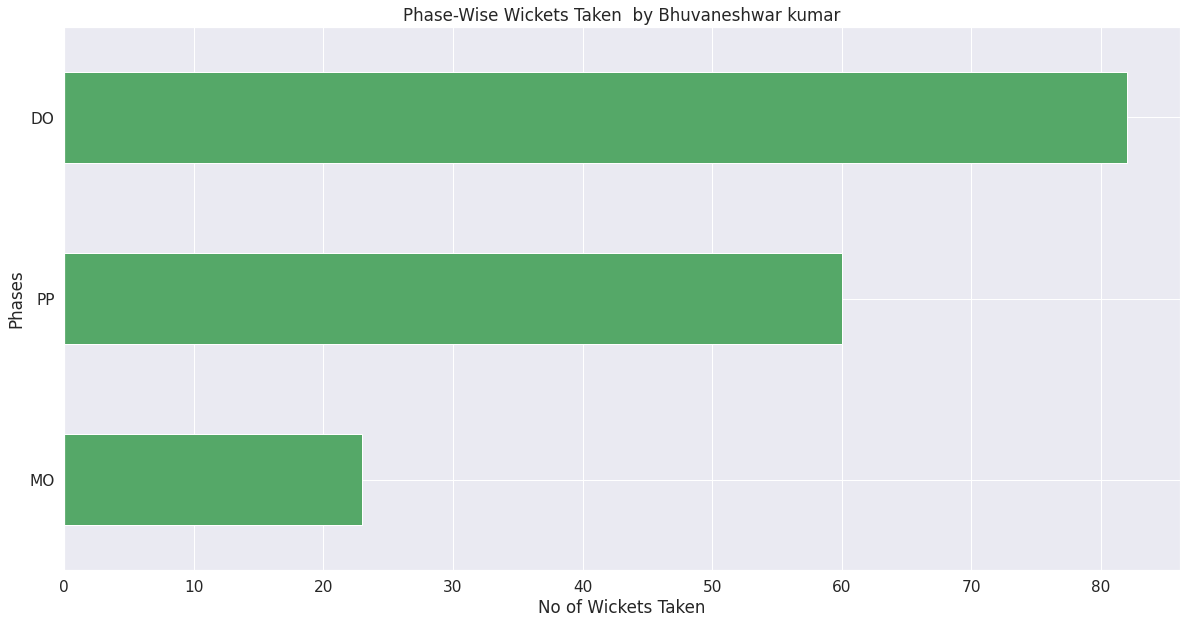

In [344]:
plt.figure(figsize = (20, 10))
match[match.bowler == 'B Kumar'].groupby(['phase'])['isOut'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('Phase-Wise Wickets Taken  by Bhuvaneshwar kumar')
plt.xlabel('No of Wickets Taken')
plt.ylabel('Phases')
plt.show()

In [345]:
Bhuvaneshwar_run = match[match.bowler == 'B Kumar'].groupby(['striker'])['runs_off_bat'].sum().reset_index().rename(columns ={'striker':'Batsmen','runs_off_bat':'Runs_Scored'})

In [346]:
Bhuvaneshwar_run.drop(Bhuvaneshwar_run[(Bhuvaneshwar_run['Runs_Scored']< 50)].index, inplace=True)
Bhuvaneshwar_run

Batsmen  Runs_Scored
3    AB de Villiers  68         
7    AD Russell      63         
11   AM Rahane       90         
14   AT Rayudu       84         
32   CH Gayle        131        
58   F du Plessis    70         
59   G Gambhir       84         
91   KD Karthik      74         
94   KL Rahul        93         
121  MS Dhoni        94         
134  PA Patel        65         
152  RA Jadeja       54         
156  RG Sharma       65         
160  RR Pant         79         
163  RV Uthappa      86         
168  S Dhawan        50         
177  SK Raina        79         
185  SR Watson       78         
190  SV Samson       111        
205  V Kohli         75         
214  YK Pathan       50

In [347]:
fig = px.bar(Bhuvaneshwar_run, x="Batsmen", y="Runs_Scored",color="Batsmen", text_auto='Runs_Scored',
               labels={
                     "Batsmen": "Batsmen",
                     "Runs_Scored": "Runs_Scored" },  title ="Most Runs Scored by Batsmen Against Bhuvaneshwar kumar in IPL")
fig.show()

In [348]:
Bhuvaneshwar_wc = match[match.bowler == 'B Kumar'].groupby(['striker'])['player_dismissed'].count().reset_index().rename(columns = {'striker':'Batsmen','player_dismissed':'Dismissals'})

In [349]:
Bhuvaneshwar_wc.drop(Bhuvaneshwar_wc[(Bhuvaneshwar_wc['Dismissals']<=2)].index, inplace=True)
Bhuvaneshwar_wc

Batsmen  Dismissals
3    AB de Villiers   3         
11   AM Rahane        6         
51   DR Smith         3         
63   GJ Maxwell       3         
88   KA Pollard       3         
114  MK Pandey        4         
115  MK Tiwary        3         
134  PA Patel         7         
175  SE Marsh         3         
177  SK Raina         3         
185  SR Watson        4         
186  SS Iyer          3         
190  SV Samson        3         
195  Shakib Al Hasan  3         
205  V Kohli          4         
214  YK Pathan        4

In [350]:
fig = px.bar(Bhuvaneshwar_wc, x="Batsmen", y="Dismissals",color="Batsmen", text_auto='Dismissals',
               labels={
                     "Batsmen": "Batsmen",
                     "Dismissals": "Dismissals_Count" },  title ="Most no. of times Dismissal's of Batsmen by Bhuvaneshwar kumar in IPL")
fig.show()

In [351]:
bowl_stat.loc[bowl_stat['bowler'] == 'B Kumar']

bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR       Eco  Dot%_mnmx  Avg_mnmx  sr_mnmx  Eco_mnmx
63  B Kumar  146      3971.0  3262          154         1581  1054  223   12      400    112    48.467198  25.785714  21.181818  7.304108  0.484672   0.810399  0.24026  0.797108

**Strength & Weakness of Bhuvaneshwar Kumar**

**Strength**
- **Bhuvaneshwar Kumar has the Economy of 7.11 against the Right hand bastman & 7.7 Against Left Hand Batsman**
- **Bhuvaneshwar Kumar has taken 50% of wickets in the death overs & 35.71% in the power Play Overs**

- **Most of the Wickets are Taken between (15-20) Overs**
- **Bhuvaneshwar Kumar has the economy of 6.03 between (1-6) overs (Power play)**
- **Bhuvaneshwar Kumar has dismissed  110 Right hand batsman(71.42%) out of 154 dismissal's**
- **Bhuvaneshwar is best for Power play & Death Over's as you can see he has taken more wickets in Power play and death over's**

**Weakness**

-  **Bhuvaneshwar Kumar has dismissed  38 Left hand batsman(24.67%) out of 154 dismissal's**
- **Bhuvaneshwar Kumar has a Bowling Average of 31% against Left hand batsman & 24.39 against Right hand batsman**

- **Bhuvaneshwar Kumar takes wicket for every 24 balls against Left hand batsman**
- **Bhuvaneshwar Kumar takes only 5.84% of wicket in the 6-15 overs (Middle overs)**

**Comparing Two Pace Bowler's to see their performance thought the IPL Tournment (2008-2022)**

In [352]:
BK= match[match['bowler']=='B Kumar'].groupby('season')['isBowlerWk'].sum().reset_index()
JJ = match[match['bowler']=='JJ Bumrah'].groupby('season')['isBowlerWk'].sum().reset_index()
trace_4 = go.Scatter(x = BK['season'], y = BK['isBowlerWk'],
 mode = 'lines + markers',
 marker = {'color': 'green'}, name = 'B Kumar')
trace_5 = go.Scatter(x = JJ['season'], y = JJ['isBowlerWk'],
 mode = 'lines + markers',
 marker = {'color': 'red'}, name = 'JJ Bumrah')
data = [trace_4, trace_5]
layout = go.Layout(title = 'Year by Year Performance',
 xaxis = {'title': 'Season'},
 yaxis = {'title': 'Total wickets Taken'})
fig = go.Figure(data = data, layout = layout)
fig.show()

**Comparing Two Spin Bowler's to see their performance thought the IPL Tournment (2008-2022)**

In [353]:
SP= match[match['bowler']=='SP Narine'].groupby('season')['isBowlerWk'].sum().reset_index()
RK = match[match['bowler']=='Rashid Khan'].groupby('season')['isBowlerWk'].sum().reset_index()
trace_7 = go.Scatter(x = BK['season'], y = BK['isBowlerWk'],
 mode = 'lines + markers',
 marker = {'color': 'green'}, name = 'SP Narine')
trace_8 = go.Scatter(x = JJ['season'], y = JJ['isBowlerWk'],
 mode = 'lines + markers',
 marker = {'color': 'red'}, name = 'Rashid Khan')
data = [trace_7, trace_8]
layout = go.Layout(title = 'Year by Year Performance',
 xaxis = {'title': 'Season'},
 yaxis = {'title': 'Total wickets Taken'})
fig = go.Figure(data = data, layout = layout)
fig.show()

#**11.** **IPL's Best Finisher & Best bowler Analysis** 


**MS Dhoni's  performance against all teams:**

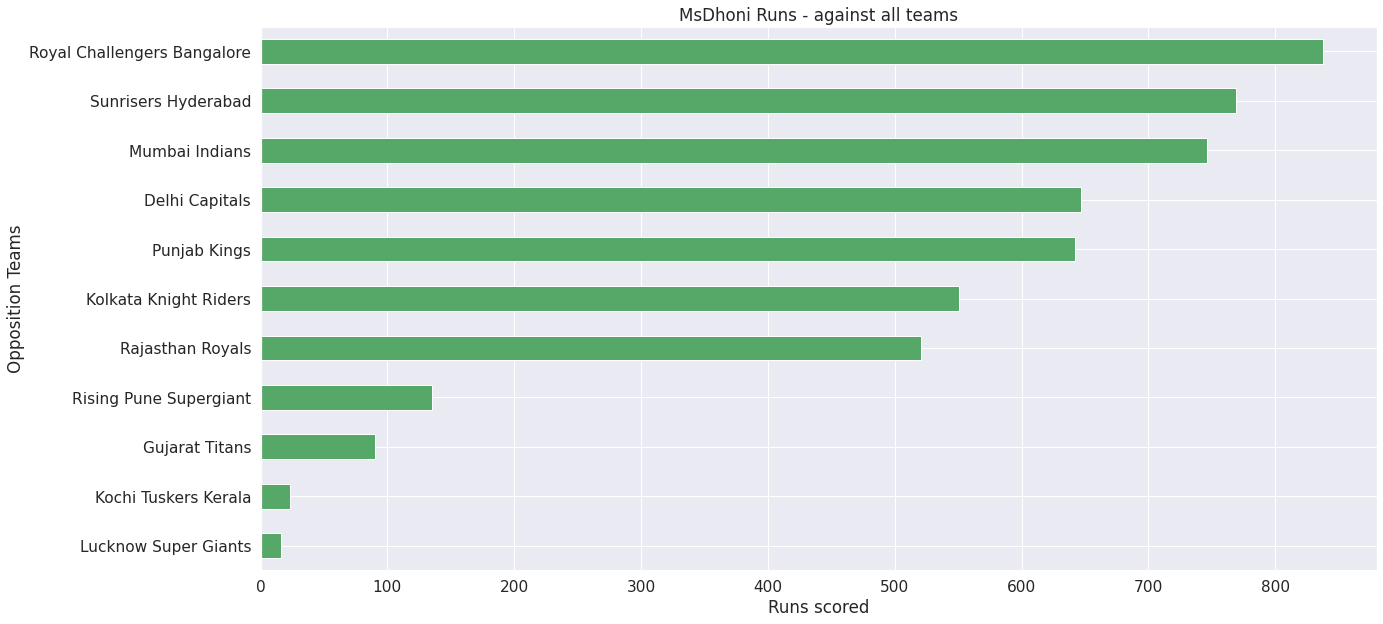

In [354]:
plt.figure(figsize = (20, 10))
match[match.striker == 'MS Dhoni' ].groupby(['bowling_team'])['runs_off_bat'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('MsDhoni Runs - against all teams')
plt.xlabel('Runs scored')
plt.ylabel('Opposition Teams')
plt.show()

In [355]:
match.head()

match_id  season  start_date                  venue  innings  ball                 batting_team           bowling_team     striker non_striker      bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty wicket_type player_dismissed  other_wicket_type  other_player_dismissed               bowl_style bowling_style           bat_style batting_style  wides_cnt_balls  noballs_cnt_balls  noballs_cnt_balls_bowler  byes_cnt_balls  legbyes_cnt_balls  legal_ball  legal_ball_bowler  over_no  ball_no phase  isDot  isOne  isTwo  isThree  isFour  isSix  total_runs  isBowlerWk  isOut
0  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        6.8   Royal Challengers Bangalore  Kolkata Knight Riders  MV Boucher  CL White    AB Agarkar  4             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  6        8        MO    0      0      0      0        1       0      4.0         0           0    
1  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        2.7   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   AB Dinda    1             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  2        7        PP    0      1      0      0        0       0      1.0         0           0    
2  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        3.1   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   I Sharma    2             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  3        1        PP    0      0      1      0        0       0      2.0         0           0    
3  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        3.2   Royal Challengers Bangalore  Kolkata Knight Riders  W Jaffer    JH Kallis   I Sharma    1             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  3        2        PP    0      1      0      0        0       0      1.0         0           0    
4  335982    2008    18-04-2008  M.Chinnaswamy Stadium  2        3.3   Royal Challengers Bangalore  Kolkata Knight Riders  JH Kallis   W Jaffer    I Sharma    0             0      NaN    NaN      NaN   NaN      NaN       NaN         NaN             NaN                NaN                       Right-arm fast-medium   Pace           Right Handed Bat   RHB           1                1                  1                         1               1                  1           1                  3        3        PP    1      0      0      0        0       0      0.0         0           0

In [356]:
player_df_latest = match[match['striker']=='MS Dhoni']
player_runs_against_bowlers = player_df_latest.groupby('bowler')['runs_off_bat'].sum().reset_index().sort_values(by='runs_off_bat',ascending=False)
player_runs_against_bowlers = player_runs_against_bowlers[:10]
player_runs_against_bowlers

bowler  runs_off_bat
64   DW Steyn    111         
89   JD Unadkat  105         
105  KA Pollard  100         
162  PP Ojha     98          
243  YS Chahal   97          
30   B Kumar     94          
208  SL Malinga  89          
161  PP Chawla   82          
227  TA Boult    82          
78   IK Pathan   80

In [357]:
fig = px.bar(player_runs_against_bowlers , x="bowler", y="runs_off_bat",
                hover_data=['bowler'],color='bowler',labels={
                     "bowler": "Bowlers",
                     "runs_off_bat": "Runs" },  title ="Most Runs scored  Against Different Bowlers (Top 10)")
fig.show()

## 11.1 MS Dhoni's  performance against all Venue's:


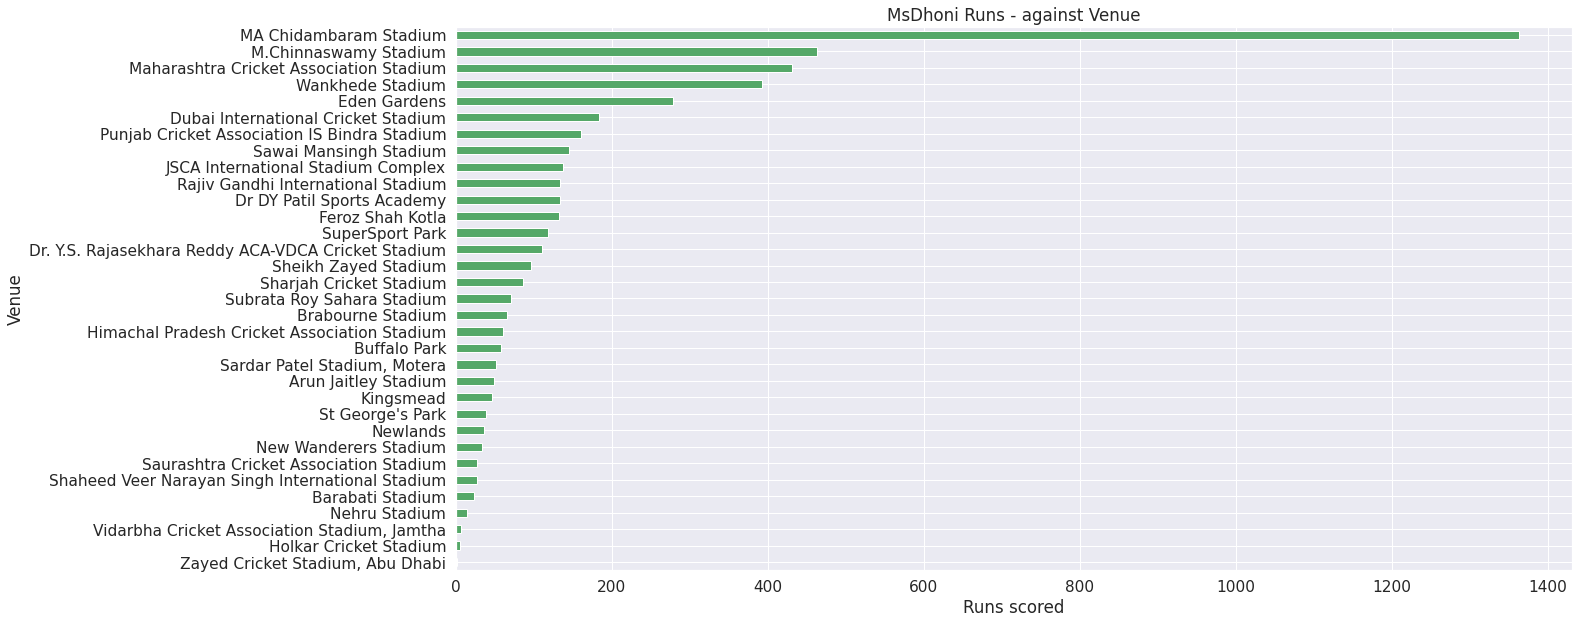

In [358]:
plt.figure(figsize = (20, 10))
match[match.striker == 'MS Dhoni'].groupby(['venue'])['runs_off_bat'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('MsDhoni Runs - against Venue')
plt.xlabel('Runs scored')
plt.ylabel('Venue')
plt.show()

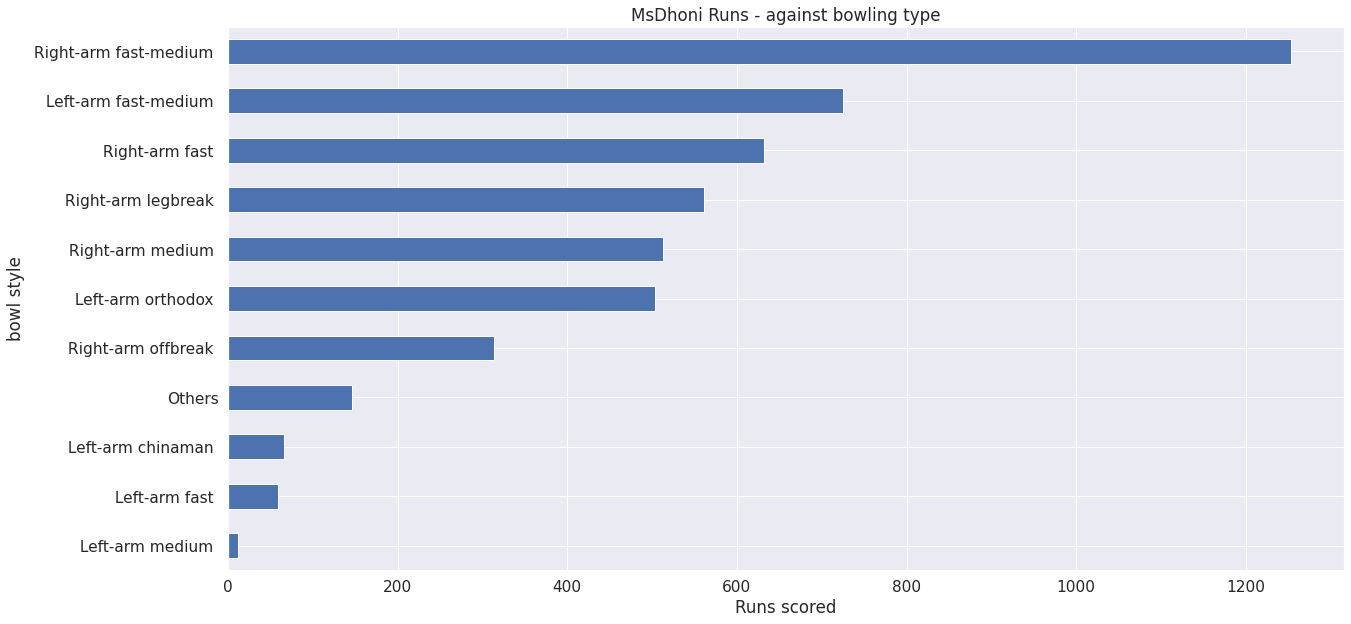

In [359]:
plt.figure(figsize = (20, 10))
match[match.striker == 'MS Dhoni'].groupby(['bowl_style'])['runs_off_bat'].sum().sort_values().plot(kind = 'barh')
plt.title('MsDhoni Runs - against bowling type')
plt.xlabel('Runs scored')
plt.ylabel('bowl style')
plt.show()

In [360]:
VK = match[match['striker']=='V Kohli'].groupby('season')['runs_off_bat'].sum().reset_index()

MS = match[match['striker']=='MS Dhoni'].groupby('season')['runs_off_bat'].sum().reset_index()

In [361]:
trace_2 = go.Scatter(x = VK['season'], y = VK['runs_off_bat'],
 mode = 'lines + markers',
 marker = {'color': 'green'}, name = 'Virat kholi')
trace_3 = go.Scatter(x = MS['season'], y = MS['runs_off_bat'],
 mode = 'lines + markers',
 marker = {'color': 'red'}, name = 'MS Dhoni')
data = [trace_2, trace_3]
layout = go.Layout(title = 'Year by Year Performance',
 xaxis = {'title': 'Season'},
 yaxis = {'title': 'Total Runs'})

fig = go.Figure(data = data, layout = layout)

fig.show()


## 11.2 JJ Bumrah Performance against all teams in IPL

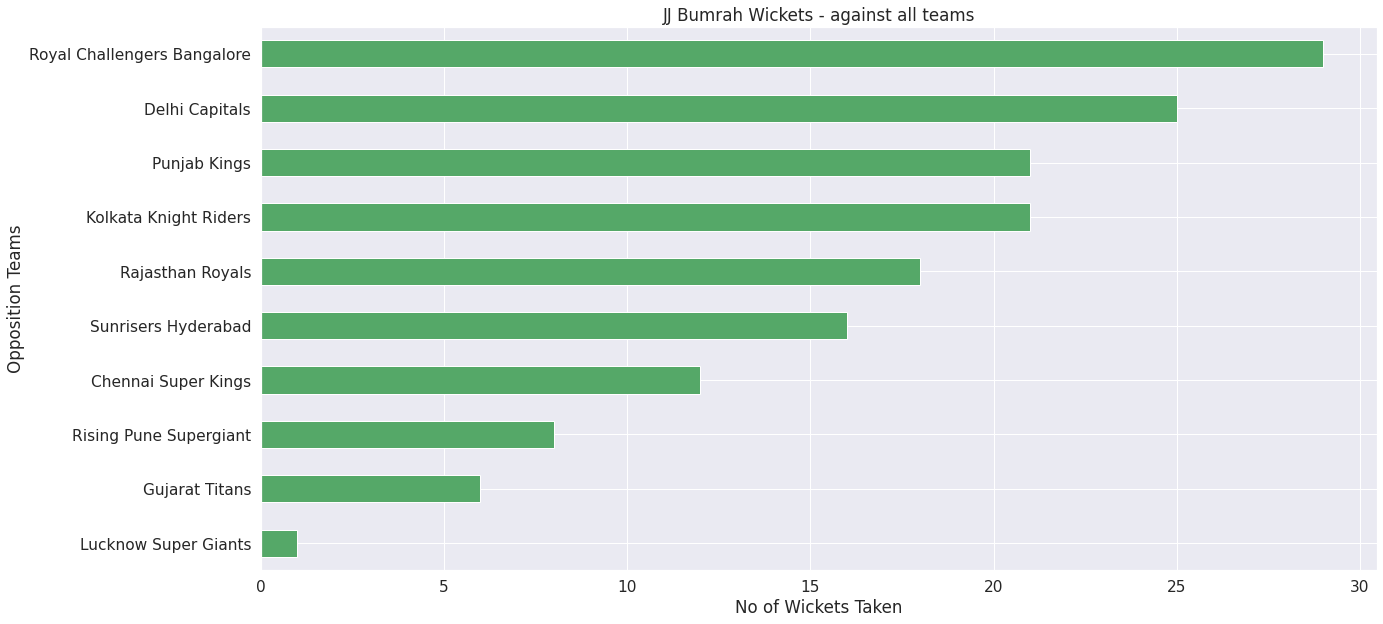

In [362]:
plt.figure(figsize = (20, 10))
match[match.bowler == 'JJ Bumrah'].groupby(['batting_team'])['isOut'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('JJ Bumrah Wickets - against all teams')
plt.xlabel('No of Wickets Taken')
plt.ylabel('Opposition Teams')
plt.show()

**Phase-wise Wickets Taken By JJ Bumrah**

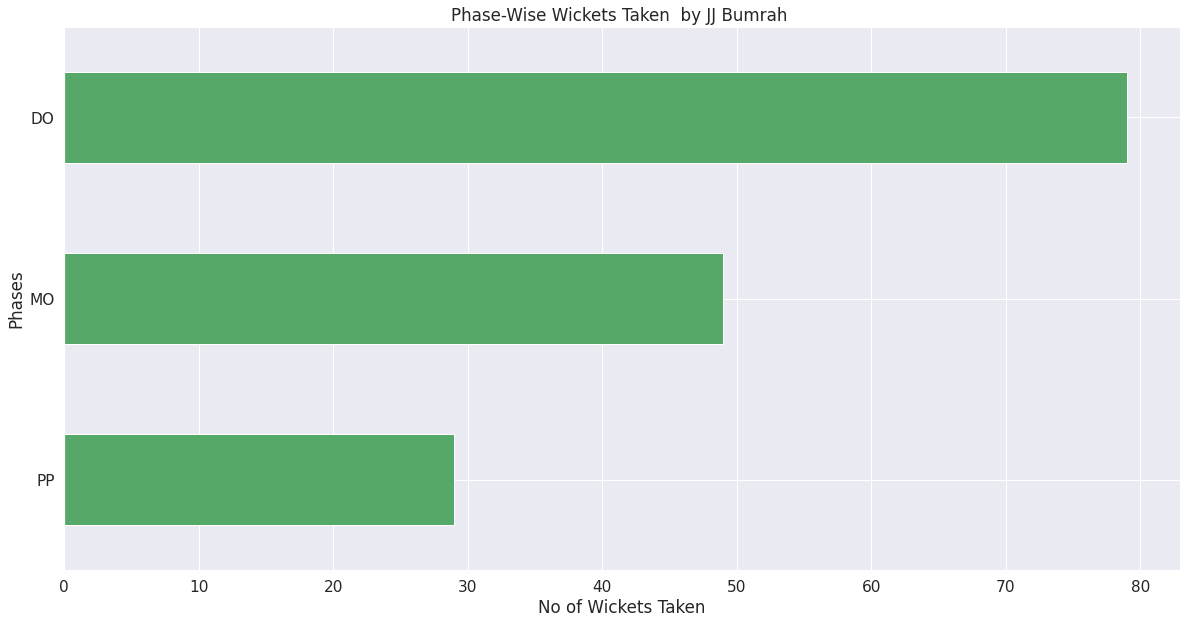

In [363]:
plt.figure(figsize = (20, 10))
match[match.bowler == 'JJ Bumrah'].groupby(['phase'])['isOut'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('Phase-Wise Wickets Taken  by JJ Bumrah ')
plt.xlabel('No of Wickets Taken')
plt.ylabel('Phases')
plt.show()

**JJ Bumrah's  performance against all Venue's**

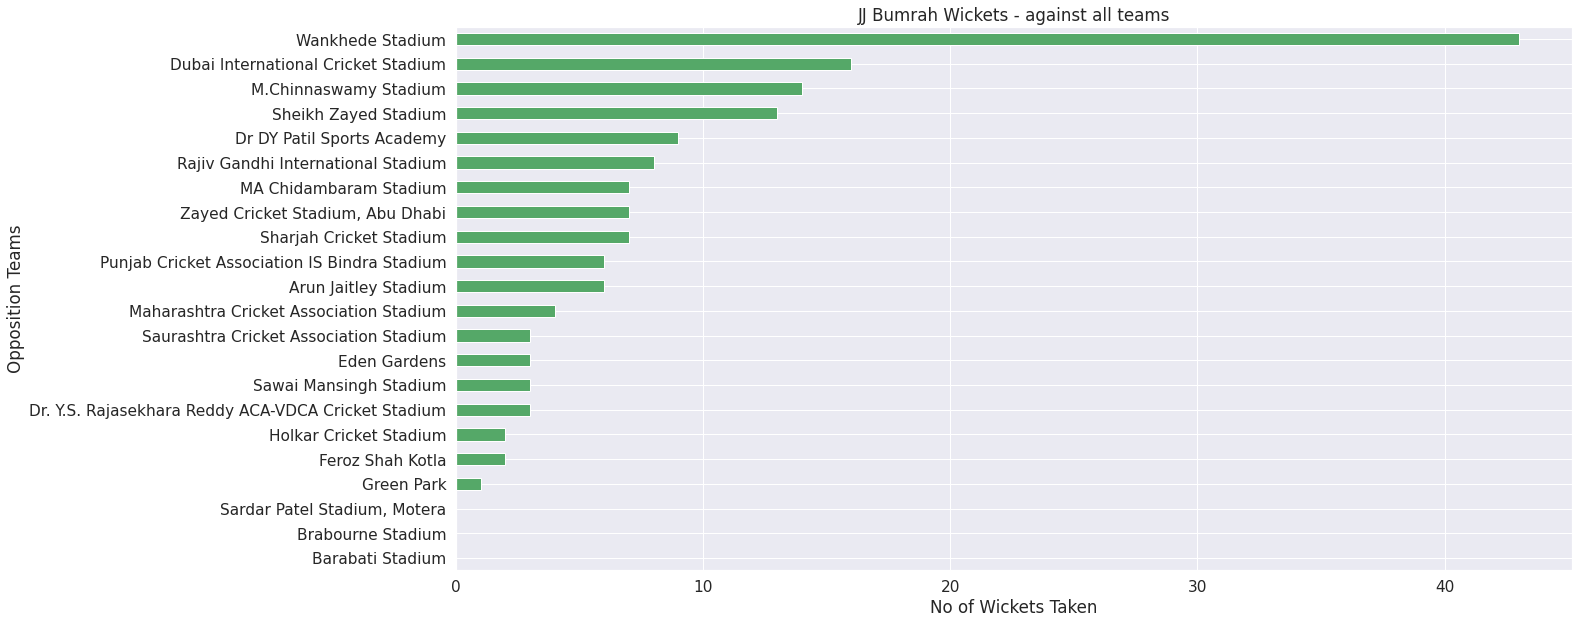

In [364]:
plt.figure(figsize = (20, 10))
match[match.bowler == 'JJ Bumrah'].groupby(['venue'])['isOut'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('JJ Bumrah Wickets - against all teams')
plt.xlabel('No of Wickets Taken')
plt.ylabel('Opposition Teams')
plt.show()

In [365]:
match[(match.bowler == 'JJ Bumrah') & (match.wicket_type != 'run out')] .groupby(['batting_style']).count()

match_id  season  start_date  venue  innings  ball  batting_team  bowling_team  striker  non_striker  bowler  runs_off_bat  extras  wides  noballs  byes  legbyes  penalty  wicket_type  player_dismissed  other_wicket_type  other_player_dismissed  bowl_style  bowling_style  bat_style  wides_cnt_balls  noballs_cnt_balls  noballs_cnt_balls_bowler  byes_cnt_balls  legbyes_cnt_balls  legal_ball  legal_ball_bowler  over_no  ball_no  phase  isDot  isOne  isTwo  isThree  isFour  isSix  total_runs  isBowlerWk  isOut
batting_style                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
 --            4         4       4           4      4        4     4             4             4        4            4       4             4       0      0        0     1        0        0            0                 0                  0                       4           4              4          4                4                  4                         4               4                  4           4                  4        4        4      4      4      4      4        4       4      4           4           4    
LHB            808       808     808         808    808      808   808           808           808      808          808     808           808     23     3        2     21       0        40           40                0                  0                       808         808            808        808              808                808                       808             808                808         808                808      808      808    808    808    808    808      808     808    808         808         808  
RHB            1934      1934    1934        1934   1934     1934  1934          1934          1934     1934         1934    1934          1934    39     25       4     35       0        99           99                0                  0                       1934        1934           1934       1934             1934               1934                      1934            1934               1934        1934               1934     1934     1934   1934   1934   1934   1934     1934    1934   1934        1934        1934

In [366]:
Bumrah_run = match[match.bowler == 'JJ Bumrah'].groupby(['striker'])['runs_off_bat'].sum().reset_index().rename(columns ={'striker':'Batsmen','runs_off_bat':'Runs_Scored'})

In [367]:
Bumrah_run.drop(Bumrah_run[(Bumrah_run['Runs_Scored']< 50)].index, inplace=True)
Bumrah_run

Batsmen  Runs_Scored
2    AB de Villiers  125        
4    AD Russell      56         
13   AT Rayudu       60         
39   DA Warner       54         
52   F du Plessis    61         
67   JC Buttler      56         
73   JP Duminy       70         
81   KD Karthik      61         
83   KL Rahul        143        
99   MK Pandey       69         
104  MS Dhoni        60         
135  RV Uthappa      54         
137  S Dhawan        105        
144  SK Raina        50         
151  SPD Smith       68         
153  SS Iyer         59         
169  V Kohli         140        
174  WP Saha         62

In [368]:
fig = px.pie(Bumrah_run,values='Runs_Scored', names='Batsmen', title='Most Runs Scored by Batsmen Against Bumrah in IPL',
             hover_data=['Batsmen'])
fig.show()

In [369]:
Bumrah_wc = match[match.bowler == 'JJ Bumrah'].groupby(['striker'])['player_dismissed'].count().reset_index().rename(columns = {'striker':'Batsmen','player_dismissed':'Dismissals'})

In [370]:
Bumrah_wc.drop(Bumrah_wc[(Bumrah_wc['Dismissals']<=2)].index, inplace=True)
Bumrah_wc

Batsmen  Dismissals
2    AB de Villiers  3         
4    AD Russell      4         
10   AR Patel        4         
40   DJ Bravo        4         
55   GJ Maxwell      5         
94   MA Agarwal      3         
102  MP Stoinis      3         
104  MS Dhoni        4         
133  RR Pant         6         
135  RV Uthappa      3         
136  Rashid Khan     4         
148  SO Hetmyer      3         
151  SPD Smith       3         
152  SR Watson       3         
169  V Kohli         4

In [371]:
fig = px.pie(Bumrah_wc,values='Dismissals', names='Batsmen', title='Most no. of times Dismissals of Batsmen by Bumrah in IPL',
             hover_data=['Batsmen'])
fig.show()

#**12.** **KMeans - Clustering**

**Elbow method
Steps in elbow method:**

**Initialize k with a range of values for the no. of clusters.
For each value of k,
perform the k-means clustering**
**compute the sum of squared distances of samples to the nearest cluster centre
Plot a graph of k versus the sum of squared distances**

In [372]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [373]:
match.wicket_type.unique()

array([nan, 'caught', 'bowled', 'run out', 'lbw', 'stumped',
       'retired hurt', 'caught and bowled', 'hit wicket',
       'obstructing the field', 'retired out'], dtype=object)

In [374]:
custom_colors = ["#023e8a", "#0096c7","#90e0ef","#ff5400","#ffbd00"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))

In [375]:
Bat_stat.head()

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD        BPB   sr_mnmx  AVG_mnmx  bpd_mnmx  bpb_mnmx
0  A Ashish Reddy  23       280   193    15          61    83    20    1       16     15     145.077720  18.666667  12.866667  6.225806   0.690477  0.335329  0.275969  0.938520
1  A Badoni        11       161   130    8           57    53    11    0       11     7      123.846154  20.125000  16.250000  7.222222   0.589428  0.361527  0.354651  0.926797
2  A Chopra        6        53    71     6           45    21    2     0       7      0      74.647887   8.833333   11.833333  10.142857  0.355276  0.158683  0.251938  0.892437
3  A Choudhary     3        25    20     1           4     13    1     0       1      1      125.000000  25.000000  20.000000  10.000000  0.594920  0.449102  0.441860  0.894118
4  A Flintoff      3        62    53     2           24    23    2     1       5      2      116.981132  31.000000  26.500000  7.571429   0.556755  0.556886  0.593023  0.922689

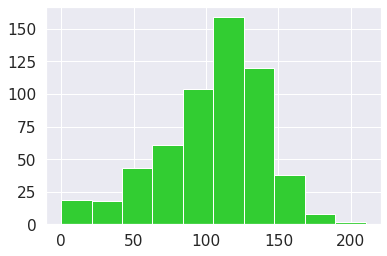

In [376]:
Bat_stat["SR"].hist(color="limegreen")

##**12.1**  **Applying K-means on Batsmen**

In [377]:
import plotly.express as px
fig = px.scatter(Bat_stat, x="SR", y='AVG',
                hover_data=['striker'], labels={
                     "SR": "Strike Rate of the Batsmen",
                     "AVG": "Batting Average of Batsmen" },  title ="IPL Batsmen")
fig.show()

The distribution of the Batsmen appears to be in largely five clusters:
under 500 runs - highest density of dots
500 - 1000 runs
1000 - 2000 runs
2000 - 3000 runs
above 3000 runs

In [378]:
def elbow_method(X):
    distortions = [] 
    inertias = [] 
    mapping1 = {} 
    mapping2 = {} 
    K = range(2,10) 

    for k in K:  
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)     

        distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 
                          'euclidean'),axis=1)) / X.shape[0]) 
        inertias.append(kmeans.inertia_) 

        mapping1[k] = sum(np.min(cdist(X, kmeans.cluster_centers_, 
                     'euclidean'),axis=1)) / X.shape[0] 
        mapping2[k] = kmeans.inertia_ 

    print("Distortion")
    for key,val in mapping1.items(): 
        print(str(key)+' : '+str(val)) 

    print("Inertia")
    for key,val in mapping2.items(): 
        print(str(key)+' : '+str(val)) 

    plt.plot(K, distortions, 'bx-',color=custom_colors[3]) 
    plt.xlabel('Values of K') 
    plt.ylabel('Distortion') 
    plt.xticks(K)
    plt.title('Elbow Method using Distortion') 
    plt.show() 

    plt.plot(K, inertias, 'bx-',color=custom_colors[4]) 
    plt.xlabel('Values of K') 
    plt.ylabel('Inertia') 
    plt.xticks(K)
    plt.title('Elbow Method using Inertia') 
    plt.show()

Distortion
2 : 19.317697588397667
3 : 14.975304224487626
4 : 12.706094785807203
5 : 11.111522167847495
6 : 9.696640062013852
7 : 8.696657014406528
8 : 8.154844565360449
9 : 7.685788497482535
Inertia
2 : 305926.83895684825
3 : 177882.99484336487
4 : 124537.75833357399
5 : 90749.0449646985
6 : 69717.72796106877
7 : 56888.31397122549
8 : 49687.392444790356
9 : 43773.941144874654


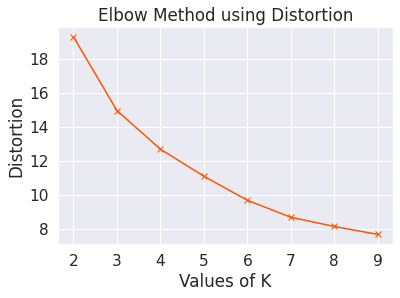

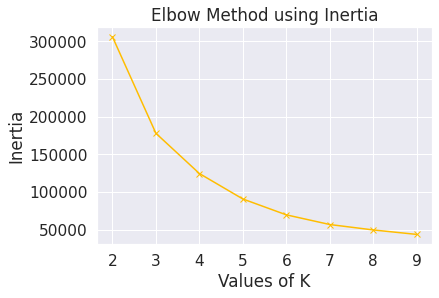

In [379]:
elbow_method(Bat_stat[["SR", "AVG"]])

In [380]:
def scores(X):
    K = range(3,8) 

    for k in K:  
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X) 
        y_hat = kmeans.predict(X)
        labels = kmeans.labels_
        
        a = metrics.silhouette_score(X, labels, metric = 'euclidean')
        b = metrics.calinski_harabasz_score(X, labels)
        
        print("k={0}, Silhouette score={1}, Calinski harabasz score={2}".format(k,a, b))

In [381]:
scores(Bat_stat[["SR", "AVG"]])

k=3, Silhouette score=0.4679613967559147, Calinski harabasz score=1036.9013695162948
k=4, Silhouette score=0.4323211712145845, Calinski harabasz score=1066.659597045972
k=5, Silhouette score=0.42833581917706026, Calinski harabasz score=1141.8437171469727
k=6, Silhouette score=0.43402287658567296, Calinski harabasz score=1228.1898507070912
k=7, Silhouette score=0.4026868653197146, Calinski harabasz score=1273.4095123472416


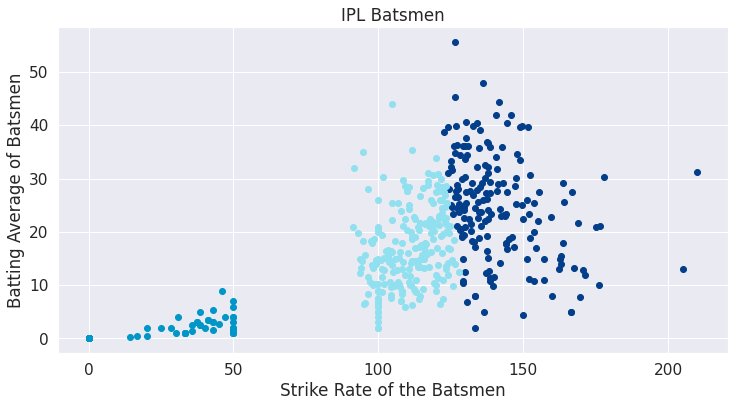

In [398]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(Bat_stat[["SR", "AVG"]])
Bat_stat["cluster"] = kmeans.labels_

fig = plt.figure(figsize=(12,6))

colors = custom_colors

for r in range(1,6):
    clustered_Batsmen = Bat_stat[Bat_stat["cluster"] == r]
    plt.scatter(clustered_Batsmen["SR"], clustered_Batsmen["AVG"], color=colors[r-1])
    
plt.title("IPL Batsmen")
plt.xlabel("Strike Rate of the Batsmen")
plt.ylabel("Batting Average of Batsmen")
plt.show()

clustering approaches:
1. Avg vs SR

In [383]:
Bat_stat.tail(10).sort_values(by='cluster')

striker  innings  runs  balls  dismissals  dots  ones  twos  threes  fours  sixes          SR        AVG        BPD        BPB   sr_mnmx  AVG_mnmx  bpd_mnmx  bpb_mnmx  cluster
566  YV Takawale      10       192   178    8           100   41    12    0       26     3      107.865169  24.000000  22.250000  6.137931   0.513369  0.431138  0.494186  0.939554  0      
562  Y Venugopal Rao  52       985   836    44          355   341   53    1       77     37     117.822967  22.386364  19.000000  7.333333   0.560762  0.402150  0.418605  0.925490  1      
563  YBK Jaiswal      23       547   406    23          177   133   14    2       62     22     134.729064  23.782609  17.652174  4.833333   0.641224  0.427232  0.387260  0.954902  1      
564  YK Pathan        153      3204  2241   110         872   877   155   5       262    159    142.971888  29.127273  20.372727  5.323040   0.680454  0.523244  0.450529  0.949141  1      
570  Yuvraj Singh     126      2750  2120   111         976   741   119   3       217    149    129.716981  24.774775  19.099099  5.792350   0.617370  0.445056  0.420909  0.943619  1      
565  YS Chahal        17       37    86     7           57    28    3     1       0      0      43.023256   5.285714   12.285714  86.000000  0.204763  0.094953  0.262458  0.000000  2      
567  Yash Dayal       1        0     1      1           1     0     0     0       0      0      0.000000    0.000000   1.000000   1.000000   0.000000  0.000000  0.000000  1.000000  2      
569  Younis Khan      1        3     7      1           4     3     0     0       0      0      42.857143   3.000000   7.000000   7.000000   0.203972  0.053892  0.139535  0.929412  2      
568  Yashpal Singh    4        47    66     4           39    20    2     1       5      0      71.212121   11.750000  16.500000  13.200000  0.338924  0.211078  0.360465  0.856471  4      
571  Z Khan           27       117   141    14          74    47    7     0       11     2      82.978723   8.357143   10.071429  10.846154  0.394925  0.150128  0.210963  0.884163  4

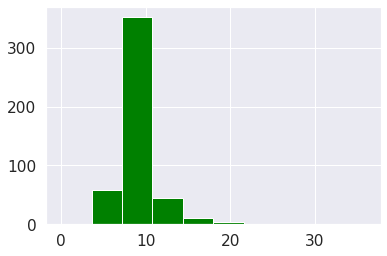

In [384]:
bowl_stat["Eco"].hist(color="green")

##**12.2** **Applying K-means on Bowlers** 

In [385]:
# players below economy rate of 4  are the star bowlers.
# Similarly, bowlers with economy rates above 12.5 are not likely to be good candidates for bowling.
# They are most likely batsmen, and thus, they too can be ignored.


In [386]:
fig = px.scatter(bowl_stat, x="SR", y='Eco',
                hover_data=['bowler'], labels={
                     "SR": "Strike Rate of the Bowler",
                     "Eco": "Bowling Economy of the Bowler" },  title ="IPL Bowlers")
fig.show()

Distortion
2 : 5.748177299933467
3 : 4.576404146916184
4 : 3.7987829580441987
5 : 3.304569825671533
6 : 2.977992227621989
7 : 2.6274337252632813
8 : 2.4174581777012003
9 : 2.244508651568619
Inertia
2 : 26407.1892226236
3 : 16318.557461245971
4 : 11076.236004344391
5 : 7999.730397293443
6 : 6486.70276590052
7 : 5266.227268765775
8 : 4261.628091928214
9 : 3678.004431856767


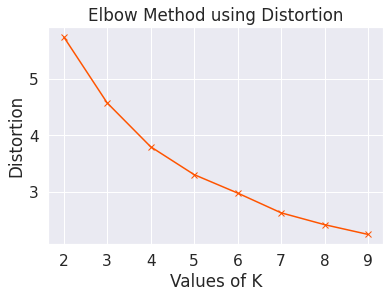

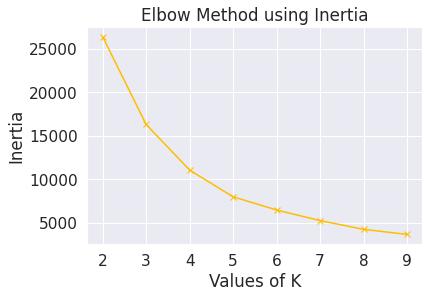

In [387]:
elbow_method(bowl_stat[["SR", "Eco"]])

In [388]:
scores(bowl_stat[["SR", "Eco"]])

k=3, Silhouette score=0.4428399357816777, Calinski harabasz score=632.5952734236336
k=4, Silhouette score=0.48649251389543996, Calinski harabasz score=698.8593230604708
k=5, Silhouette score=0.45933657708255204, Calinski harabasz score=765.0841467371217
k=6, Silhouette score=0.43450275986253645, Calinski harabasz score=777.7324885303593
k=7, Silhouette score=0.43946829390138464, Calinski harabasz score=811.8100303257792


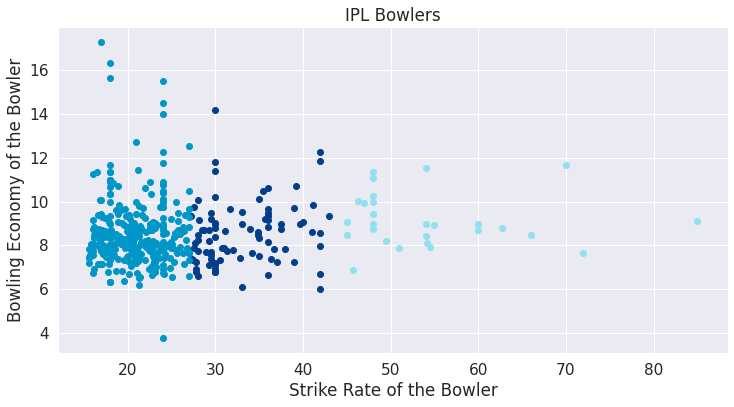

In [392]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(bowl_stat[["SR", "Eco"]])
bowl_stat["cluster"] = kmeans.labels_

fig = plt.figure(figsize=(12,6))

colors = custom_colors

for r in range(1,5):
    clustered_Bowlers = bowl_stat[bowl_stat["cluster"] == r]
    plt.scatter(clustered_Bowlers["SR"], clustered_Bowlers["Eco"], color=colors[r-1])
    
plt.title("IPL Bowlers")
plt.xlabel("Strike Rate of the Bowler")
plt.ylabel("Bowling Economy of the Bowler")
    
plt.show()

Clustering approach:
1. Bowl SR vs Eco.

In [390]:
bowl_stat = bowl_stat.sort_values(by = 'cluster')
bowl_stat.tail()

bowler  innings    runs  balls_bowled  dismissals  dots  ones  twos  threes  fours  sixes       Dot%        Avg         SR        Eco  Dot%_mnmx  Avg_mnmx   sr_mnmx  Eco_mnmx  cluster
208  KK Cooper      25       757.0   576           33          233   222   62    0       59     23     40.451389  22.939394  17.454545  7.885417   0.404514   0.831328  0.195887  0.780961  3      
207  KK Ahmed       34       1101.0  778           48          352   245   52    5       112    43     45.244216  22.937500  16.208333  8.491003   0.452442   0.831342  0.181052  0.764139  3      
202  KA Pollard     107      2180.0  1488          69          518   711   108   2       169    78     34.811828  31.594203  21.565217  8.790323   0.348118   0.767690  0.244824  0.755824  3      
216  KS Williamson  2        31.0    18            0           2     11    2     0       1      2      11.111111  inf        18.000000  10.333333  0.111111   0.264706  0.202381  0.712963  3      
472  Z Khan         99       2782.0  2200          102         1005  743   142   9       312    64     45.681818  27.274510  21.568627  7.587273   0.456818   0.799452  0.244865  0.789242  3